## sigMF RF single and multi-classification; 12 classes

#### Added multiclass function for dividing batches for mixing to create 1, 2 or 3 classes

In [1]:
import itertools as it
# import posixpath
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy
import glob
import json
from os import walk
import pickle
import json
import pathlib
import random
from timeit import default_timer as timer
import time
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
global GPU, fft, Fs, center_freq, fft_val, Fs_test, loss, batches, eps, var_noise, mean_noise, top
global c1_coeff, c2_coeff, a, r1_c1, r2_c1, r1_c2, r2_c2, compare
a = 1
compare = .5
r1_c2 = 1
r2_c2 = 20e0
top = .975
var_noise = 8.78e-09
# mean_noise = 10 # worked pretty good
mean_noise = 1
eps = 1e-15
Fs = 1000000
fft = 1024
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz
center_freq_live = 428.00e6 # when SDR doing 25MSPS with center at 428MHz
# batches = 128
plt.style.use('default')
GPU = 1
cuda = "cuda:1"
device = torch.device(cuda)
print('Torch version =', torch.__version__, 'CUDA version =', torch.version.cuda)
print('CUDA Device:', device)
print('Is cuda available? =',torch.cuda.is_available())

Torch version = 1.6.0 CUDA version = 10.2
CUDA Device: cuda:1
Is cuda available? = True


In [2]:
!. /home/david/prefix-3.8/setup_env.sh

#### Machine paths

In [3]:
# path = "/media/david/Elements/sigMF_ML/RF/RF_class/data/" # path to external drive
path = "/media/david/Extreme Pro/data/combined_data/training_data/" # path to external drive
path_ram = "/home/david/sigMF_ML/RF/ramdisk/"
path_usrp = "/home/david/prefix-3.8/"
# path_1msps = "/home/david/sigMF_ML/RF/RF_class/data_1msps/" # ACE
# path_25msps = "/home/david/sigMF_ML/RF/RF_class/data_25msps/" # ACE
path_1msps = "/media/david/Extreme Pro/data/seperate_data/data_1msps/" # External extreme drive
path_25msps = "/media/david/Extreme Pro/data/seperate_data/data_25msps/" # External extreme drive
path_fig = "/home/david/sigMF_ML/RF/RF_class/figures/" # ACE
path_val = "/home/david/sigMF_ML/RF/RF_class/testing_data/" # ACE
path_save = "/home/david/sigMF_ML/RF/RF_class/saved/" # ACE
path_test = "/home/david/sigMF_ML/RF/RF_class/testing_data/" # ACE
path_test_1msps = "/media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps/" # external drive
path_test_5msps = "/media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps/" # external drive
path_test_10msps = "/media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps/" # external drive
path_test_25msps = "/media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps/" # external drive
# path_test_1msps = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/" # ACE
# path_test_5msps = "/home/david/sigMF_ML/RF/RF_class/testing_data_5msps/" # ACE
# path_test_10msps = "/home/david/sigMF_ML/RF/RF_class/testing_data_10msps/" # ACE
# path_test_25msps = "/home/david/sigMF_ML/RF/RF_class/testing_data_25msps/" # ACE
path_validation = "/home/david/sigMF_ML/RF/RF_class/validation/" # multiclass validation
path_val_1msps = "/home/david/sigMF_ML/RF/RF_class/val_1msps/" # multiclass validation
path_val_5msps = "/home/david/sigMF_ML/RF/RF_class/val_5msps/" # multiclass validation
path_val_10msps = "/home/david/sigMF_ML/RF/RF_class/val_10msps/" # multiclass validation
path_val_25msps = "/home/david/sigMF_ML/RF/RF_class/val_25msps/" # multiclass validation
# print(path)

In [4]:
print(path_test)

os.chdir(path_test)
data_files_test = sorted(glob.glob('*.sigmf-data'))
meta_files_test = sorted(glob.glob('*.sigmf-meta'))

/home/david/sigMF_ML/RF/RF_class/testing_data/


## Functions 

In [5]:
# START OF FUNCTIONS ****************************************************
def meta_encoder(meta_list, num_classes): 
    a = np.asarray(meta_list, dtype=int)
#    print('a = ', a)
    return a 

def save_model(epoch, loss, iter_batch):
    rf_model = 'ResNet50_multiclass_20220202_mix_autosave_GPU1_1class_1e3_rev1'
    PATH = path_save+rf_model
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,}, PATH+'_train-epoch-{}-batch-{}.pt'.format(epoch, iter_batch)) 
    
    torch.save(model.state_dict(), PATH+'_inference-epoch-{}-batch-{}.pt'.format(epoch, iter_batch))
    
# def load_model():
#     rf_model = 'ResNet50_20210405_autosave'
#     PATH = path_save+rf_model
#     device = torch.device("cuda:0")
#     model = resnet50(4, 12)
#     model.load_state_dict(torch.load(PATH))
#     model.to(device)
#     model.train() 
#     return model

def load_model():
    rf_model = 'ResNet50_multiclass_20211212_autosave_GPU0'
    PATH = path_save+rf_model
    device = torch.device(cuda)
    model = resnet50(4, 12)
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)
    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    model.to(device)
    model.train() 
    return model, optimizer

def load_model2(rf_model):
#     rf_model = 'ResNet50_v58_20210212_4D_autosave'
    PATH = path_save+rf_model
    device = torch.device(cuda)
#     model = resnet50(4, 12)
    model.load_state_dict(torch.load(PATH))
    model.to(device)
    model.eval()
    return model

def load_model_original():
    rf_model = 'ResNet50_20210430_mix2_score'
    PATH = path_save+rf_model
    device = torch.device(cuda)
#     model = resnet50(4, 12)
    model.load_state_dict(torch.load(PATH))
    model.to(device)
    model.eval() 

def gpu_test_file(db,msps): # THIS IS ACTUALLY USED FOR LIVE TESTING
    if (msps == 1):
        w1 = fft*msps
    elif (msps == 5):
        w1 = fft*msps
    elif (msps == 10):
        w1 = fft*msps
    elif (msps == 25):
        w1 = fft*msps
#     print('gpu_test file function')    
    I = db[0::2]
    Q = db[1::2]
    w = fft*msps
#     print('Sample Rate = ',w,'MSPS')
    den = 2
#     print('window length = ', w1)
    win = torch.hamming_window(w1, periodic=True, dtype=None, layout=torch.strided, requires_grad=False).cuda(GPU)
    I_stft = torch.stft(torch.tensor(I).cuda(GPU), n_fft=w, hop_length=w//den, win_length=w1, window=win, center=True, normalized=True, onesided=False)
    Q_stft = torch.stft(torch.tensor(Q).cuda(GPU), n_fft=w, hop_length=w//den, win_length=w1, window=win, center=True, normalized=True, onesided=False)
    X_stft = I_stft[...,0] + Q_stft[...,0] + I_stft[...,1] + -1*Q_stft[...,1]
#     print('X shape =', X_stft.shape)
#     print('I shape =', I_stft.shape, 'Q shape = ', Q_stft.shape )
    Z_stft = torch.cat((I_stft,Q_stft),2)
#     print('Before: Final gpu_test file Z shape =', Z_stft.shape)
#     Z_stft = torch.cat((Z_stft[w//2:,:,:],Z_stft[:w//2,:,:])) # NOT SURE I NEED TO DO THIS...
#     print('After: Final gpu_test file Z shape =', Z_stft.shape)
    Z_stft = Z_stft[:w//2,:,:] # throw bottom 1/2 away
#     print('FINAL Z shape =', Z_stft.shape)
    torch.cuda.empty_cache()
    return Z_stft # Returning 4D

def gpu_test_live(db,msps):
#     I = db[0:10000000:2]
#     Q = db[1:10000000:2]      
    print('gpu_test live function')    
    if (msps == 1):
        w1 = fft*msps
    elif (msps == 5):
        w1 = fft*msps
    elif (msps == 10):
        w1 = fft*msps
    elif (msps == 25):
        w1 = fft*msps     
    I = db[0::2]
    Q = db[1::2]
    w = fft*msps
    print('Sample Rate = ',w,'MSPS')
    den = 2
    win = torch.hann_window(w1, periodic=True, dtype=None, layout=torch.strided, requires_grad=False).cuda(GPU)
    I_stft = torch.stft(torch.tensor(I).cuda(GPU), n_fft=w, hop_length=w//den, win_length=w1, window=win, center=True, normalized=True, onesided=True)
    Q_stft = torch.stft(torch.tensor(Q).cuda(GPU), n_fft=w, hop_length=w//den, win_length=w1, window=win, center=True, normalized=True, onesided=True)
    Z_stft = torch.cat((I_stft,Q_stft),2)
#     print('gpu_test live IQ shape =', Z_stft.shape)
    Z_stft = torch.cat((Z_stft[w//2:,:,:],Z_stft[:w//2,:,:])) # NOT SURE I NEED TO DO THIS...
    Z_stft = Z_stft[10:w//2,:,:]# throw bottom 1/2 away
    print('FINAL gpu_test LIVE IQ shape =', Z_stft.shape)
    torch.cuda.empty_cache()
    return Z_stft # Returning 4D and plot

def iq_read(data_files): # USING GPU to perform STFT
    print('iq_read function**********')
    data_IQ_list = []
    data_IQ_temp = []
    for file in data_files:
        db = np.fromfile(file, dtype="float32")
#         stft = gpu(db).detach().cpu().numpy()
        print('iq_read function')
        stft, stft_plot = gpu_test_file(db)
        stft = stft.detach().cpu().numpy()
        stft_plot = stft_plot.detach().cpu().numpy()
        stft_plot = 10*np.log10(np.abs(stft_plot+eps))
        plt.imshow(stft_plot)
        plt.pcolormesh(stft_plot)
#         plt.imshow(stft, aspect='auto', origin='lower')
        plt.show()
        data_IQ_temp.append(stft)
    data_IQ_list = np.array(data_IQ_temp)
    return data_IQ_list

def iq_read_test_file(data_files,msps): # USING GPU to perform STFT
    data_IQ_list = []
    data_IQ_temp = []
    print('iq_read_test file')
    for file in data_files:
        db = np.fromfile(file, dtype="float32")
        stft = gpu_test_file(db,msps)
        X_stft = stft[...,0] + stft[...,1] + stft[...,2] - stft[...,3]
        stft_plot = 20*np.log10(np.abs(X_stft.detach().cpu().numpy()+eps))
        print('imshow method')
        plt.imshow(stft_plot, vmin=-70, vmax=5, aspect='auto', origin='lower')
        plt.show()
        data_IQ_temp.append(stft.detach().cpu().numpy())
    data_IQ_list = np.array(data_IQ_temp)
    return data_IQ_list

def iq_read_test_live_old(data_files,msps): # USING GPU to perform STFT
#     iq_cpu_plot(data_files) #checking with cpu complex plotting
    data_IQ_list = []
    data_IQ_temp = []
    print('iq_read_test live: remarked out plotting')
    for file in data_files:
        db = np.fromfile(file, dtype="float32")
        stft = gpu_test_live(db,msps)
        # *************************************************************************
        X_stft = stft[...,0] + stft[...,1] + stft[...,2] - stft[...,3]
        stft_plot = 20*np.log10(np.abs(X_stft.detach().cpu().numpy()+eps))       
        print('iq_read_test live imshow method')
        plt.imshow(stft_plot, vmin=-70, vmax=5, aspect='auto', origin='lower')
        plt.show()
        # *************************************************************************
        data_IQ_temp.append(stft.detach().cpu().numpy())
    data_IQ_list = np.array(data_IQ_temp)
    return data_IQ_list

def iq_read_test_live(data_files,msps): # 20210611 memory saver update
    print('iq_read_test_live')
#     print('file is =', data_files, type(data_files))
    for file in data_files:
        db = np.fromfile(file, dtype="float32")
        print('db = ', db.shape)
    #     stft = gpu_test_file(db,msps).detach().cpu().numpy()
        stft = gpu_test_file(db,msps)
        X_stft = stft[...,0] + stft[...,1] + stft[...,2] - stft[...,3]
        stft_plot = 20*np.log10(np.abs(X_stft.detach().cpu().numpy()+eps))
        print('imshow method')
        plt.imshow(stft_plot, vmin=-70, vmax=5, aspect='auto', origin='lower')
        plt.show()
    #     data_IQ_temp.append(stft.detach().cpu().numpy())
    return stft

def iq_read_test_live_combine(data_files,msps): # 20211025 memory saver update
#     print('iq_read_test_live combined')
#     print('file is =', data_files, type(data_files))
    if msps==1:
        db = np.zeros(20000000)
    if msps==5:
        db = np.zeros(50000000)  # 49999996  
    if msps==10:
        db = np.zeros(100000000)
    elif msps==25:
        db = np.zeros(250000000)    
    for file in data_files:
        temp = np.fromfile(file, dtype="float32")
#         print('read file shape = ', temp.shape)
        if (len(db) > len(temp)):
            N = np.abs(len(db)-len(temp))
#             print('N = ', N)
            temp = np.pad(temp, (0, N), 'constant')
#             print('new file length = ', len(temp))
        db = db + temp
#         print('db = ', db.shape)
    #     stft = gpu_test_file(db,msps).detach().cpu().numpy()
    stft = gpu_test_file(db,msps)
#     X_stft = stft[...,0] + stft[...,1] + stft[...,2] - stft[...,3]
#     stft_plot = 20*np.log10(np.abs(X_stft.detach().cpu().numpy()+eps))
#     print('imshow method')
#     plt.imshow(stft_plot, vmin=-70, vmax=5, aspect='auto', origin='lower')
#     plt.show()
    #     data_IQ_temp.append(stft.detach().cpu().numpy())
    return stft

def read_meta(meta_files):
    meta_list = []
    for meta in meta_files:
        all_meta_data = json.load(open(meta))
        meta_list.append(all_meta_data['global']["core:class"])
    meta_list = list(map(int, meta_list))
    return meta_list

def read_num_val(x):
    x = len(meta_list_val)
    return x

#**************************** Print historgram subplots ******************************
def histo_plots(inputs):
    fig=plt.figure(figsize=(8,8))
    ncols = 2
    nrows = 2
    print('make torch inputs')
    print('inputs shape for histogram1 = ', inputs.shape)
    inputs = 10*np.log10(np.abs(inputs.cpu()+eps))
    for x in range(4):
#         print('x = ', x, 'inputs shape for histogram2 = ', inputs[:,:,x].shape)
        flat_inputs = torch.flatten(inputs[:,:,x], start_dim=0, end_dim=-1).numpy()
#         print('type = ', type(flat_inputs))
#         print('x = ', x, 'flat_input max = ', np.amax(flat_inputs))
#         print('inputs are: ', flat_inputs.shape)
        fig.add_subplot(nrows, ncols, x+1)
        plt.hist(flat_inputs, bins=5000)
        plt.gca().set(title='Frequency Histogram', ylabel='Frequency');
        plt.xlim(-100, 10)
#         plt.ylim(0, 40000)
    return flat_inputs
#*************************************************************************************    
#**************************** Print historgram subplots ******************************
def histo_stats(inputs):
#     print('make torch inputs')
#     print('inputs shape for histogram1 = ', inputs.shape)
    mean = np.zeros(4)
    std = np.zeros(4)
    for x in range(4):
#         print('x = ', x, 'inputs shape for histogram2 = ', inputs[:,:,x].shape)
        flat_inputs = torch.flatten(inputs[:,:,x], start_dim=0, end_dim=-1).numpy()
#         print('inputs are: ', flat_inputs.shape)
        mean[x] = flat_inputs.mean()
        std[x] = flat_inputs.std()
#         print('mean = ', mean, 'std = ', std)
    return mean, std
#**************************** Print historgram freq stats ******************************
def histo_stats_freq_file(inputs,msps):
    mean = inputs.mean()
    std = inputs.std()
    print("mean Freq = {0:9,.2f}".format(mean))
    print("std Freq = {0:9,.2f}".format(std))
    print('length of inputs = ', len(inputs))
#     plt.hist(inputs, 30, facecolor='blue', align='mid')
    if (msps==25):
        plt.hist(inputs, 30, range=[428.0, 440.0], facecolor='blue', align='mid')
    elif (msps==1):
        plt.hist(inputs, 30, range=[433.65, 434.15], facecolor='blue', align='mid')
    elif (msps==5):
        plt.hist(inputs, 30, range=[433.00, 435.50], facecolor='blue', align='mid')         
    elif (msps==10):
        plt.hist(inputs, 30, range=[433.00, 438.00], facecolor='blue', align='mid')        
    else:
        print('WRONG SAMPLE RATE CHOSEN')
    plt.gca().set(title='Frequency Histogram', ylabel='Frequency'); 
    plt.show()
def histo_stats_freq_live(inputs,msps):
    mean = inputs.mean()
    std = inputs.std()
    print("mean Freq = {0:9,.2f}".format(mean))
    print("std Freq = {0:9,.2f}".format(std))
    print('length of inputs = ', len(inputs))
#     plt.hist(inputs, 30, facecolor='blue', align='mid')
    if (msps==25):
        plt.hist(inputs, 30, range=[428.0, 440.0], facecolor='blue', align='mid')
    elif (msps==1):
        plt.hist(inputs, 30, range=[433.65, 434.15], facecolor='blue', align='mid')
    elif (msps==5):
        plt.hist(inputs, 30, range=[433.00, 435.50], facecolor='blue', align='mid')          
    elif (msps==10):
        plt.hist(inputs, 30, range=[433.00, 438.00], facecolor='blue', align='mid')         
    else:
        print('WRONG SAMPLE RATE CHOSEN')
    plt.gca().set(title='Frequency Histogram', ylabel='Frequency'); 
    plt.show()
# END OF FUNCTIONS ******************************************************

#### Start of ResNet blocks

In [6]:
from functools import partial
from dataclasses import dataclass
from collections import OrderedDict

In [7]:
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        
conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False) 

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels, self.out_channels =  in_channels, out_channels
        self.blocks = nn.Identity()
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels

In [9]:
class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(OrderedDict(
        {
            'conv' : nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            'bn' : nn.BatchNorm2d(self.expanded_channels)
            
        })) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

In [10]:
def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(OrderedDict({'conv': conv(in_channels, out_channels, *args, **kwargs), 
                          'bn': nn.BatchNorm2d(out_channels) }))

In [11]:
class ResNetBasicBlock(ResNetResidualBlock):
    expansion = 1
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation(),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )

In [12]:
class ResNetBottleNeckBlock(ResNetResidualBlock):
    expansion = 4
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
           conv_bn(self.in_channels, self.out_channels, self.conv, kernel_size=1),
             activation(),
             conv_bn(self.out_channels, self.out_channels, self.conv, kernel_size=3, stride=self.downsampling),
             activation(),
             conv_bn(self.out_channels, self.expanded_channels, self.conv, kernel_size=1),
        )

In [13]:
class ResNetLayer(nn.Module):
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x

In [14]:
class ResNetEncoder(nn.Module):
    """
    ResNet encoder composed by increasing different layers with increasing features.
    """
    def __init__(self, in_channels=3, blocks_sizes=[64, 128, 256, 512], deepths=[2,2,2,2], 
                 activation=nn.ReLU, block=ResNetBasicBlock, *args,**kwargs):
        super().__init__()
        
        self.blocks_sizes = blocks_sizes
        
        self.gate = nn.Sequential(
            nn.Conv2d(in_channels, self.blocks_sizes[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.blocks_sizes[0]),
            activation(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))
        self.blocks = nn.ModuleList([ 
            ResNetLayer(blocks_sizes[0], blocks_sizes[0], n=deepths[0], activation=activation, 
                        block=block,  *args, **kwargs),
            *[ResNetLayer(in_channels * block.expansion, 
                          out_channels, n=n, activation=activation, 
                          block=block, *args, **kwargs) 
              for (in_channels, out_channels), n in zip(self.in_out_block_sizes, deepths[1:])]       
        ])
        
        
    def forward(self, x):
        x = self.gate(x)
        for block in self.blocks:
            x = block(x)
        return x

In [15]:
class ResnetDecoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.decoder = nn.Linear(in_features, n_classes)

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x

In [16]:
class ResNet(nn.Module):
    
    def __init__(self, in_channels, n_classes, *args, **kwargs):
        super().__init__()
        self.encoder = ResNetEncoder(in_channels, *args, **kwargs)
        self.decoder = ResnetDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes)
        self.sigmoid = nn.Sigmoid() # added ~david
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x) # Logits output
        y = self.sigmoid(x) # Added sigmoid function ~david
        return x, y

In [17]:
def resnet18(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[2, 2, 2, 2])

def resnet34(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[3, 4, 6, 3])

def resnet50(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 6, 3])

def resnet101(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 23, 3])

def resnet152(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 8, 36, 3])

#### End of ResNet blocks

In [18]:
from torchsummary import summary

# model = resnet50(4, 12)
# summary(model.cuda(GPU), (4, 224, 224))

In [19]:
from torch.utils.data import Dataset

In [20]:
class RFDataset(Dataset):
    def __init__(self, root_path, limit=None):
        print(root_path)
        self.root_path = root_path
        self.list_of_all_pickles = sorted(pathlib.Path(root_path).rglob('*/chopped-data-224-224/*.pickle'))
        print('list of patches =', len(self.list_of_all_pickles))
        if limit:
            rng = np.random.default_rng(0)
            self.list_of_all_pickles = rng.choice(self.list_of_all_pickles, size=limit, replace=False)
        self.get_class = dict()
        class_folders = list(pathlib.Path(root_path).glob('*/'))
        for class_folder in class_folders:
            class_index = -1
            metadata_path = list(class_folder.rglob('*.sigmf-meta'))[0] #changed from [0]
            with open(metadata_path) as fp:
                metadata = json.load(fp)
                class_index = int(metadata["global"]["core:class"])
            self.get_class[str(class_folder.stem)] = class_index


    def __len__(self):
        return len(self.list_of_all_pickles)

    def __getitem__(self, idx):
        filepath = self.list_of_all_pickles[idx]
        with open(filepath, 'rb') as fp:
            tensor = pickle.load(fp)['bounded']
        foldername = filepath.parts[7] # changed from [7] relative to path depth
        label = self.get_class[foldername]
#         one_hot_label = np.zeros(12).astype(int) # creating one hot vector
#         print('dataloader class number = ', label)
        one_hot_label = np.zeros(12).astype(int) # creating one hot vector, needs to be float
        one_hot_label[label] = 1
#         print('dataloader One hot = ', one_hot_label)
#         sys.exit('One hot vector testing')
        #return (tensor, label) # this is a tuple
        return {'data': tensor, 'label': one_hot_label, 'label_int': label}

In [21]:
class RFDataset2(Dataset):
    def __init__(self, root_path, limit=None):
        print(root_path)
        self.root_path = root_path
        self.list_of_all_pickles = sorted(pathlib.Path(root_path).rglob('*/chopped-data-224-224/*.pickle'))
        print('list of patches =', len(self.list_of_all_pickles))
        if limit:
            rng = np.random.default_rng(0)
            self.list_of_all_pickles = rng.choice(self.list_of_all_pickles, size=limit, replace=False)
        self.get_class = dict()
        class_folders = list(pathlib.Path(root_path).glob('*/'))
        for class_folder in class_folders:
            class_index = -1
            metadata_path = list(class_folder.rglob('*.sigmf-meta'))[0] #changed from [0]
            with open(metadata_path) as fp:
                metadata = json.load(fp)
                class_index = int(metadata["global"]["core:class"])
            self.get_class[str(class_folder.stem)] = class_index


    def __len__(self):
        return len(self.list_of_all_pickles)

    def __getitem__(self, idx):
        filepath = self.list_of_all_pickles[idx]
        with open(filepath, 'rb') as fp:
            tensor = pickle.load(fp)['bounded']
        foldername = filepath.parts[7] # changed from [7] relative to path depth
        label = self.get_class[foldername]
#         one_hot_label = np.zeros(12).astype(int) # creating one hot vector
#         print('dataloader class number = ', label)
        one_hot_label = np.zeros(12).astype(int) # creating one hot vector, needs to be float
        one_hot_label[label] = 1
#         print('dataloader One hot = ', one_hot_label)
#         sys.exit('One hot vector testing')
        #return (tensor, label) # this is a tuple
        return {'data': tensor, 'label': one_hot_label, 'label_int': label}

#### Evaluation dataset loader

In [22]:
# val_patch_limit = None
# rf_dataset_val = RFDataset(path_validation, limit=val_patch_limit)
# validation_data = data.DataLoader(rf_dataset_val, batch_size=batches, shuffle=True)
# validation_data = [validation_data]

In [23]:
# for i, val_data in enumerate(validation_data, 0):
#     for i, rf_data in enumerate(val_data, 0): 
#         inputs = rf_data['data']
#         labels = rf_data['label']
#         print('label shape', labels.shape)
#         print('inputs shape = ', inputs.shape)

In [24]:
def multiclass(inputs, labels):
    if (classes == 2):
#         print('Classes = ', classes)
#         print('pre combine shape  = ', inputs.shape)
        inputs_lower = inputs[:batches//2,:,:,:]
#         print('inputs lower shape = ', inputs_lower.shape) # **** new print
        inputs_upper = inputs[batches//2:,:,:,:]
#         print('inputs upper shape = ', inputs_upper.shape) # **** new print
        inputs = inputs_lower + inputs_upper # combine two classes
#         print('inputs final shape = ', inputs.shape) # **** new print       
        label_lower = labels[:batches//2,:]
#         print('label lower = ', label_lower)
        label_upper = labels[batches//2:,:]
#         print('label upper = ', label_upper)
        labels = torch.bitwise_or(label_lower,label_upper)
#         print('labels combined = ', labels)
    elif (classes == 3):
#         print('Classes = ', classes)
#         print('pre combine shape  = ', inputs.shape)
        inputs_lower = inputs[:batches//3,:,:,:]
#         print('inputs lower shape = ', inputs_lower.shape) # **** new print
        inputs_mid = inputs[batches//3:128,:,:,:]
#         print('inputs mid shape = ', inputs_mid.shape) # **** new print        
        inputs_upper = inputs[128:,:,:,:]
#         print('inputs upper shape = ', inputs_upper.shape) # **** new print
        inputs = inputs_lower + inputs_mid + inputs_upper # combine three classes
#         print('inputs final shape = ', inputs.shape) # **** new print
        label_lower = labels[:batches//3,:]
#         print('label lower = ', label_lower)
        label_mid = labels[batches//3:128,:]
#         print('label mid = ', label_mid)        
        label_upper = labels[128:,:]
#         print('label upper = ', label_upper)
        labels1 = torch.bitwise_or(label_lower,label_mid)
        labels = torch.bitwise_or(labels1,label_upper)
#         print('labels combined = ', labels)
#     sys.exit('multiclass testing') # exit program for testing
    return inputs, labels

## Training

In [25]:
def train_net(total): # Multiclass - Mixed patches
#     batches = 64
#     batches = batches*2# double net required actual batches for combining purpose math
    print('batches = ', batches)
    if (classes == 1):
        test_patch_total = 88000 
    if (classes == 2):    
        test_patch_total = 87936//2 + 64 # accounting for 128 batches and remainder the original test total
    if (classes == 3):    
        test_patch_total = 87936//3 + 64 # accounting for 192 batches and remainder the original test total
    print('total patch count = ', test_patch_total)
    compare = .7
    loss_plot = np.zeros(total)
    total_plot = np.zeros(total//5+1)
    print('training data length = ', len(training_data25))
    batch_plot = np.zeros(len(training_data25)*total) # temporarily remove //100
#     print('batch plot shape = ', batch_plot.shape)
    batch_indexer = 0
    for epoch in tqdm(range(total), desc="Epoch"): 
        model.train()
        start = timer()
#         for i, rf_data in enumerate(training_data, 0):
        for i in range(len(training_data25)//classes): # divide to temp reduce training loop  
            # 1msps patchs ######################################################################
            rf_data1 = next(iter(training_data1))
            inputs = rf_data1['data']
            inputs = torch.squeeze(inputs, dim=1)
            inputs = inputs.permute(0,3,1,2).contiguous()
            current_batches, b, c, d = inputs.shape
#             print('iteration = ', i, 'current batches = ', current_batches)
            labels = rf_data1['label'] 
            if ((current_batches == batches) and (classes != 1)):
                inputs, labels = multiclass(inputs, labels)
#                 print('class = ', classes)
#             print('labels shape = ', labels.shape)
#             print('inputs shape = ', inputs.shape)
            if (current_batches != batches):
                print('left over patches = ',current_batches)
            batch_dim, b, c, d = inputs.shape #using NEW inputs shape
            labels = labels.to(torch.float)
#             print('label example =', labels[0,:]) # **** new print
#             print('label vector shape', labels.shape) # **** new print
#             print('label vector type', type(labels)) # **** new print
            # *********************** Print out a patch to verify process **************************
#             stft_plot1 =  10*np.log10(np.abs(inputs[0, 0, :, :]+eps))
#             stft_plot1 = np.squeeze(stft_plot1, axis=0)
#             plt.imshow(stft_plot1, vmin=-70, vmax=5)
#             plt.show()          
            # **************************************************************************************
#             sys.exit('shape testing') # exit program for testing
            # add som noise
#             c2 = torch.FloatTensor(a).uniform_(r1_c2, r2_c2)
            c2 = 1 # lock down noise to nominal
            for batch_num in range(batch_dim):
                inputs[batch_num,:,:,:] = inputs[batch_num,:,:,:] + (((var_noise*c2)**0.5)*torch.randn(1, 4, 224, 224))   
            inputs = Variable(inputs.cuda(GPU))
#             labels = rf_data['label'] # moved it up
            labels = labels.cuda(GPU)
            outputs_logits, outputs_sig = model(inputs)
            loss = criterion(outputs_logits, labels) # used with nn.BCEWithLogitsLoss()
#                 loss = criterion(outputs_sig, labels) # used with nn.BCEloss
#                 print('loss = ', loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # 25msps patchs ######################################################################
            rf_data25 = next(iter(training_data25))
            inputs = rf_data25['data']
            inputs = torch.squeeze(inputs, dim=1)
            inputs = inputs.permute(0,3,1,2).contiguous()
            current_batches, b, c, d = inputs.shape
#             print('iteration = ', i, 'current batches = ', current_batches)
            labels = rf_data25['label'] 
            if ((current_batches == batches) and (classes != 1)):
                inputs, labels = multiclass(inputs, labels)
#                 print('class = ', classes)
#             print('labels shape = ', labels.shape)
#             print('inputs shape = ', inputs.shape)
            if (current_batches != batches):
                print('left over patches = ',current_batches)
            batch_dim, b, c, d = inputs.shape #using NEW inputs shape
            labels = labels.to(torch.float)
#             print('label example =', labels[0,:]) # **** new print
#             print('label vector shape', labels.shape) # **** new print
#             print('label vector type', type(labels)) # **** new print
            # *********************** Print out a patch to verify process **************************
#             stft_plot1 =  10*np.log10(np.abs(inputs[0, 0, :, :]+eps))
#             stft_plot1 = np.squeeze(stft_plot1, axis=0)
#             plt.imshow(stft_plot1, vmin=-70, vmax=5)
#             plt.show()          
            # **************************************************************************************
#             sys.exit('shape testing') # exit program for testing
            # add som noise
#             c2 = torch.FloatTensor(a).uniform_(r1_c2, r2_c2)
            c2 = 1 # lock down noise to nominal
            for batch_num in range(batch_dim):
                inputs[batch_num,:,:,:] = inputs[batch_num,:,:,:] + (((var_noise*c2)**0.5)*torch.randn(1, 4, 224, 224))   
            inputs = Variable(inputs.cuda(GPU))
#             labels = rf_data['label'] # moved it up
            labels = labels.cuda(GPU)
            outputs_logits, outputs_sig = model(inputs)
            loss = criterion(outputs_logits, labels) # used with nn.BCEWithLogitsLoss()
#                 loss = criterion(outputs_sig, labels) # used with nn.BCEloss
#                 print('loss = ', loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
#                 print('loss = ', loss)
#         print('ResNet ouput = ', outputs)
        end = timer()
        batch_time = end - start
#         print('train total batches =', batch_sum)
        #***************************************************************************************
        print('batch time = ', batch_time)
        print('************************* start *************************')
#         sys.exit('resnet testing') # exit program for testing
        total_correct_patches = grand_total = 0
        start_test = timer()
        model.eval()
        for testing in validation_data1:
            t = train_val(testing)
            print('Total 1msps correct = {:.2f}%'.format(t/(24000/classes)*100))
            total_correct_patches = total_correct_patches + t
        for testing in validation_data5:
            t = train_val(testing)
            print('Total 5msps correct = {:.2f}%'.format(t/(20004/classes)*100))
            total_correct_patches = total_correct_patches + t          
        for testing in validation_data10:
            t = train_val(testing)
            print('Total 10msps correct = {:.2f}%'.format(t/(20004/classes)*100))
            total_correct_patches = total_correct_patches + t            
        for testing in validation_data25:
            t = train_val(testing)
            print('Total 25msps correct = {:.2f}%'.format(t/(24000/classes)*100))
            total_correct_patches = total_correct_patches + t            
           
        grand_total = total_correct_patches/test_patch_total
#         sys.exit('resnet testing') # exit program for testing
#         print('batch indexer = ', batch_indexer)
        batch_plot[batch_indexer] = grand_total*100
        batch_indexer = batch_indexer + 1
    #     print('Batch number = ', i, 'of', len(training_data))
        print('Total % correct = {:.2f}%'.format(grand_total*100))         
        model.train 
        end_test = timer()
        test_time = end_test - start_test
        print('test time = ', test_time)
        print('*************************** end ***************************')
        #****************************************************************************************         
        save_model(epoch,loss)
        tqdm.write('___________________________________________')
        tqdm.write("Epoch {} Loss {:.10f} ".format(epoch+1, loss.data*1)) 
        tqdm.write('___________________________________________') 
        if (grand_total >= .97):
            break
    return loss_plot, batch_plot

In [26]:
88008/3

29336.0

In [27]:
def train_net_combined_data(total): # Multiclass - Mixed patches
#     batches = 64
#     batches = batches*2# double net required actual batches for combining purpose math
    i_batch = 100
    i_main = 0
    print('batches = ', batches)
    if (classes == 1):
        test_patch_total = 88008
    if (classes == 2):    
        test_patch_total = 88008//2 # (88008//2)%128=100 128 batches and remainder the original test total
    if (classes == 3):    
        test_patch_total = 88008//3 # (88008//3)%192=152 192 batches and remainder the original test total
    print('total patch count = ', test_patch_total)
    compare = .7
    loss_plot = np.zeros(total)
    total_plot = np.zeros(total//5+1)
    print('training data length = ', len(training_data))
    # Based on combined training data **************************************************
    batch_plot = np.zeros(len(training_data)*total) # temporarily remove //100
    plot_1msps = np.zeros(len(training_data)*total)
    plot_5msps = np.zeros(len(training_data)*total)
    plot_10msps = np.zeros(len(training_data)*total)
    plot_25msps = np.zeros(len(training_data)*total)
    #************************************************************************************
#     print('batch plot shape = ', batch_plot.shape)
    batch_indexer = 0
#     loss_plot, batch_plot, plot_1msps, plot_5msps, plot_10msps, plot_25msps, batch_indexer = load_plot_data(loss_plot, batch_plot, plot_1msps, plot_5msps, plot_10msps, plot_25msps, batch_indexer)
    model.train()
    for epoch in tqdm(range(total), desc="Epoch"): 
#         start = timer()
        for i, rf_data in enumerate(training_data, 0): 
            start = timer()
            inputs = rf_data['data']
            inputs = torch.squeeze(inputs, dim=1)
            inputs = inputs.permute(0,3,1,2).contiguous()
            current_batches, b, c, d = inputs.shape
#             print('iteration = ', i, 'current batches = ', current_batches)
            labels = rf_data['label'] 
            if ((current_batches == batches) and (classes != 1)):
                inputs, labels = multiclass(inputs, labels)
#                 print('class = ', classes)
#             print('labels shape = ', labels.shape)
#             print('inputs shape = ', inputs.shape)
            if (current_batches != batches):
                print('left over patches = ',current_batches)
#             sys.exit('resnet testing') # exit program for testing
            batch_dim, b, c, d = inputs.shape #using NEW inputs shape
            labels = labels.to(torch.float)
#             print('label example =', labels[0,:]) # **** new print
#             print('label vector shape', labels.shape) # **** new print
#             print('label vector type', type(labels)) # **** new print
            # *********************** Print out a patch to verify process **************************
#             stft_plot1 =  10*np.log10(np.abs(inputs[0, 0, :, :]+eps))
#             stft_plot1 = np.squeeze(stft_plot1, axis=0)
#             plt.imshow(stft_plot1, vmin=-70, vmax=5)
#             plt.show()          
            # **************************************************************************************
#             sys.exit('shape testing') # exit program for testing
            # add som noise
#             c2 = torch.FloatTensor(a).uniform_(r1_c2, r2_c2)
            c2 = 1 # lock down noise to nominal
            for batch_num in range(batch_dim):
                inputs[batch_num,:,:,:] = inputs[batch_num,:,:,:] + (((var_noise*c2)**0.5)*torch.randn(1, 4, 224, 224))   
            inputs = Variable(inputs.cuda(GPU))
#             labels = rf_data['label'] # moved it up
            labels = labels.cuda(GPU)
            outputs_logits, outputs_sig = model(inputs)
            loss = criterion(outputs_logits, labels) # used with nn.BCEWithLogitsLoss()
#                 loss = criterion(outputs_sig, labels) # used with nn.BCEloss
#                 print('loss = ', loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if 1500<=i_main<=50000:
                i_batch = 1000
            if (i_main % i_batch == 0) and i>0:
                print('iter epoch = ', i)
                print('iter batch = ', i_batch)
                print('i_main = ', i_main)
                save_model(epoch,loss,i_main)
                loss_plot, batch_plot, plot_1msps, plot_5msps, plot_10msps, plot_25msps = \
                validation_check(loss,epoch,start, test_patch_total,classes,loss_plot, \
                batch_plot, plot_1msps, plot_5msps, plot_10msps, plot_25msps, batch_indexer)
                batch_indexer = batch_indexer + 1
            i_main = i_main +1
    return loss_plot, batch_plot, plot_1msps, plot_5msps, plot_10msps, plot_25msps

In [28]:
def validation_check(loss,epoch,start,test_patch_total,classes,loss_plot, batch_plot, plot_1msps, 
                     plot_5msps, plot_10msps, plot_25msps, batch_indexer):       
    end = timer()
    batch_time = end - start
    print('batch time = ', batch_time)
    print('************************* start *************************')    
    total_correct_patches = grand_total = 0
    start_test = timer()
    model.eval()
    for testing in validation_data1:
        t = train_val(testing)
        print('Total 1msps correct = {:.2f}%'.format(t/(24000/classes)*100))
        total_correct_patches = total_correct_patches + t
#         plot_1msps[batch_indexer] = t/(test_patch_total/4)
        plot_1msps[batch_indexer] = t/(24000/classes)
    for testing in validation_data5:
        t = train_val(testing)
        print('Total 5msps correct = {:.2f}%'.format(t/(20004/classes)*100))
        total_correct_patches = total_correct_patches + t   
#         plot_5msps[batch_indexer] = t/(test_patch_total/4)
        plot_5msps[batch_indexer] = t/(20004/classes)
    for testing in validation_data10:
        t = train_val(testing)
        print('Total 10msps correct = {:.2f}%'.format(t/(20004/classes)*100))
        total_correct_patches = total_correct_patches + t  
#         plot_10msps[batch_indexer] = t/(test_patch_total/4)
        plot_10msps[batch_indexer] = t/(20004/classes)
    for testing in validation_data25:
        t = train_val(testing)
        print('Total 25msps correct = {:.2f}%'.format(t/(24000/classes)*100))
        total_correct_patches = total_correct_patches + t  
#         plot_25msps[batch_indexer] = t/(test_patch_total/4)
        plot_25msps[batch_indexer] = t/(24000/classes)
    grand_total = total_correct_patches/(test_patch_total)
    #         sys.exit('resnet testing') # exit program for testing
    #         print('batch indexer = ', batch_indexer)
    batch_plot[batch_indexer] = grand_total
#     batch_indexer = batch_indexer + 1
    #     print('Batch number = ', i, 'of', len(training_data))
    print('Total % correct {:.2f}%'.format(grand_total*100))         
    model.train 
    end_test = timer()
    test_time = end_test - start_test
    #***********************************************************
    #                       Save plotting data
    #***********************************************************
    save_plot_data(loss_plot, batch_plot, plot_1msps, plot_5msps, plot_10msps, plot_25msps, batch_indexer)
    #***********************************************************
    print('test time = ', test_time)
    print('*************************** end ***************************')
    #****************************************************************************************         
#     save_model(epoch,loss)
    tqdm.write('___________________________________________')
    tqdm.write("Epoch {} Loss {:.10f} ".format(epoch+1, loss.data*1)) 
    tqdm.write('___________________________________________') 
    return loss_plot, batch_plot, plot_1msps, plot_5msps, plot_10msps, plot_25msps

In [29]:
def save_plot_data(loss_plot, batch_plot, plot_1msps, plot_5msps, plot_10msps, plot_25msps, batch_indexer):
    # path_plot_fig = "/home/david/sigMF_ML/RF/RF_class/plot_data/" # ACE
    # os.chdir(path_plot_fig)
    np.save('resnet50_4ch_loss_plot3_20211213', np.asarray(loss_plot))
    np.save('resnet50_4ch_batch_plot3_20211213', np.asarray(batch_plot))
    np.save('resnet50_4ch_plot_1msps3_20211213', np.asarray(plot_1msps))
    np.save('resnet50_4ch_plot_5msps3_20211213', np.asarray(plot_5msps))
    np.save('resnet50_4ch_plot_10msps3_20211213', np.asarray(plot_10msps))
    np.save('resnet50_4ch_plot_25msps3_20211213', np.asarray(plot_25msps))
    np.save('resnet50_4ch_batch_indexer3_20211213', np.asarray(batch_indexer))
    return

In [30]:
def load_plot_data(loss_plot, batch_plot, plot_1msps, plot_5msps, plot_10msps, plot_25msps, batch_indexer):
    # path_plot_fig = "/home/david/sigMF_ML/RF/RF_class/plot_data/" # ACE
    # os.chdir(path_plot_fig)
    loss_plot = np.load('resnet50_4ch_loss_plot3_20211213.npy')
    batch_plot = np.load('resnet50_4ch_batch_plot3_20211213.npy')
    plot_1msps = np.load('resnet50_4ch_plot_1msps3_20211213.npy')
    plot_5msps = np.load('resnet50_4ch_plot_5msps3_20211213.npy')
    plot_10msps = np.load('resnet50_4ch_plot_10msps3_20211213.npy')
    plot_25msps = np.load('resnet50_4ch_plot_25msps3_20211213.npy')
    batch_indexer = np.load('resnet50_4ch_batch_indexer3_20211213.npy')
    return loss_plot, batch_plot, plot_1msps, plot_5msps, plot_10msps, plot_25msps, batch_indexer

### Training Validation

In [31]:
def train_val(val_data): # used for MULTI class validation
    noise_label = np.zeros(12) # used for validation with noise
    noise_label[8] = 1
    noise_label = torch.tensor(noise_label)
    with torch.no_grad():
        total = noise = center_fft = target_to_int = accumulated_corrects = percent_correct = 0
        c0 = c1 = c2 = c3 = c4 = c5 = c6 = c7 = c8 = c9 = 0
        for i, rf_data in enumerate(val_data, 0): 
            inputs = rf_data['data']
            inputs = torch.squeeze(inputs, dim=1)
            inputs = inputs.permute(0,3,1,2).contiguous() 
            current_batches, b, c, d = inputs.shape
#             print('iteration = ', i, 'current batches = ', current_batches)
            labels = rf_data['label'] 
            if ((current_batches == batches) and (classes != 1)):
                inputs, labels = multiclass(inputs, labels)
                # *********************** Print out a patch to verify process **************************
    #             stft_plot1 =  10*np.log10(np.abs(inputs[0, 0, :, :]+eps))
    #             stft_plot1 = np.squeeze(stft_plot1, axis=0)
    #             plt.imshow(stft_plot1, vmin=-70, vmax=5)
    #             plt.show()          
                # **************************************************************************************
    #             sys.exit('shape testing') # exit program for testing
                # add som noise
    #             c2 = torch.FloatTensor(a).uniform_(r1_c2, r2_c2)
            batch_dim, b, c, d = inputs.shape #using NEW inputs shape
            labels = labels.to(torch.float)        
            c2 = 1 # lock down noise to nominal
            for batch_num in range(batch_dim):
                inputs[batch_num,:,:,:] = inputs[batch_num,:,:,:] + (((var_noise*c2)**0.5)*torch.randn(1, 4, 224, 224)) 
            inputs = Variable(inputs.cuda(GPU))
            labels_int = rf_data['label_int']
            labels = labels.cuda(GPU)
            optimizer.zero_grad() 
            outputs_logits, outputs_sig = model(inputs)
            if (classes ==1):
                predicted = outputs_logits.data # using logits output for single patch class validation 
#                 print('logits out = ', predicted)
                _, predicted = torch.max(outputs_logits.data, 1)
#                 print('predicted max = ', predicted)
#                 predicted = torch.zeros(predicted.shape)
#                 predicted[(torch.arange(len(predicted)).unsqueeze(1), torch.topk(predicted,2).indices)] = 1                
            else:
                predicted = torch.round(outputs_sig.data) # using sigmoid output for multiclass patch validation 
#                 print('predicted rounded =', predicted)
#                 one_hot_label = np.zeros(12).astype(int) # creating one hot vector
#                 one_hot_label[label_int] = 1
            for b in range(len(predicted)):
                if (classes == 1):
                    label_integer = labels_int[b].detach().cpu().numpy()
                    pred = predicted[b].detach().cpu().numpy()
                    if (label_integer == pred): # using integer values
                        accumulated_corrects = accumulated_corrects+1                    
                else:
                    if torch.equal(predicted[b], labels[b]):
                        accumulated_corrects = accumulated_corrects+1
                    elif torch.equal(predicted[b].detach().cpu().to(torch.int), torch.bitwise_or(labels[b].detach().cpu().to(torch.int),noise_label.to(torch.int))):
                        accumulated_corrects = accumulated_corrects+1 # for noise predictions
    torch.cuda.empty_cache()
    return accumulated_corrects

### START one validation test run

In [32]:
# batches = 64
# classes = 3
# batches = batches*classes

In [33]:
# val_patch_limit = None
# rf_dataset_val = RFDataset(path_validation, limit=val_patch_limit)
# validation_data = data.DataLoader(rf_dataset_val, batch_size=batches, shuffle=True)
# validation_data = [validation_data]

In [52]:
# print('batches = ', batches)
# if (classes == 1):
#     test_patch_total = 88000 
# if (classes == 2):    
#     test_patch_total = 87936//2 + 64 # accounting for 128 batches and remainder the original test total
# if (classes == 3):    
#     test_patch_total = 87936//3 + 64 # accounting for 192 batches and remainder the original test total
# print('total patch count = ', test_patch_total)
# total_correct_patches = grand_total = 0
# start_test = timer()
# model.eval()
# for testing in validation_data:
#     t = train_val(testing)
#     total_correct_patches = total_correct_patches + t           
# grand_total = total_correct_patches/test_patch_total
# print('Total % correct {:.2f}%'.format(grand_total*100))     

### END validation test run

## Inference Segmented Dataloader

In [33]:
# Inference Dataloader with labels
class inference_dataloader_segmented_live(data.Dataset):
    def __init__(self):
        self.dataPath = path
        self.num_classes = 12
        self.num_examples = 1 # use only 1 for semi-live inferencing
    def __getitem__(self, index):
        sigmf_data = np.array(data_IQ_list_val[index]) 
        print('sigmf_data = ', sigmf_data.shape)
        frequency, time, dims1 = sigmf_data.shape
        print('frequency = ', frequency, '  time = ', time)
        data_IQ = []
        data_IQ_temp2 = []
        seg_t = 224  
        seg_f = 224 
        seg_time = time//seg_t
        seg_freq = frequency//seg_f
        print('seg_time = ', seg_time, 'seg_freq = ', seg_freq)
        # Segment the time axis
        for j in range(seg_time): 
                # Segment the frequency axis
                for k in range(seg_freq): 
                    IQ = sigmf_data[seg_f*k:(seg_f)+seg_f*k,seg_t*j:(seg_t)+seg_t*j]
                    data_IQ_temp2.append(IQ)            
        data_IQ = np.array(data_IQ_temp2)
        print('data_IQ shape = ', data_IQ.shape)
        loop_counter, dim1, dim2, dim3 = data_IQ.shape
        TRUTH =  meta_encoder(meta_list_val, self.num_classes)
        TRUTH = TRUTH.astype(np.float32)
        return torch.from_numpy(data_IQ),torch.from_numpy(TRUTH), loop_counter, seg_freq
    def __len__(self):
        return self.num_examples 

In [34]:
# Inference Dataloader with labels
class inference_dataloader_segmented(data.Dataset):
    def __init__(self):
        self.dataPath = path
        self.num_classes = 12
        self.num_examples = 1 # uses a LOT of memory for more than 1 25MSPS STFT
    def __getitem__(self, index):
        sigmf_data = np.array(data_IQ_list_val[index]) 
        print('sigmf_data = ', sigmf_data.shape)
        frequency, time, dims1 = sigmf_data.shape
        print('frequency = ', frequency, '  time = ', time)
        data_IQ = []
        data_IQ_temp2 = []
        seg_t = 224  
        seg_f = 224 
        seg_time = time//seg_t
        seg_freq = frequency//seg_f
        print('seg_time = ', seg_time, 'seg_freq = ', seg_freq)
        # Segment the time axis
        for j in range(seg_time): 
                # Segment the frequency axis
                for k in range(seg_freq): 
                    IQ = sigmf_data[seg_f*k:(seg_f)+seg_f*k,seg_t*j:(seg_t)+seg_t*j]
                    data_IQ_temp2.append(IQ)            
        data_IQ = np.array(data_IQ_temp2)
        print('data_IQ shape = ', data_IQ.shape)
        loop_counter, dim1, dim2, dim3 = data_IQ.shape
        TRUTH =  meta_encoder(meta_list_val, self.num_classes)
        TRUTH = TRUTH.astype(np.float32)
        return torch.from_numpy(data_IQ),torch.from_numpy(TRUTH), loop_counter, seg_freq
    def __len__(self):
        return self.num_examples 

### validation functions

In [35]:
def validation_read():    
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path_val)
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("validation file name = ", meta)
    # Load validation sigmf-data files
    meta_list_val = read_meta(meta_files_validation)
    data_IQ_list_val = iq_read(data_files_validation)
    return data_IQ_list_val, meta_list_val

In [36]:
def testing_read():
    print('testing_read function')
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path_val)
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("testing file name = ", meta)
    meta_list_val = read_meta(meta_files_validation)
    data_IQ_list_val = iq_read_test_file(data_files_validation)
    return data_IQ_list_val, meta_list_val

#### Changed to get test data from different directory

In [37]:
def inference_read_old(msps):    
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path_ram) 
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("inference file name = ", meta)
    # Load validation sigmf-data files
    meta_list_val = read_meta(meta_files_validation)
    data_IQ_list_val = iq_read_test_live_old(data_files_validation,msps)
    return data_IQ_list_val, meta_list_val

In [38]:
# updated 20210609 to save memory
def inference_read(msps):    
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path_ram)
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("inference file name = ", meta)
    return data_files_validation, meta_files_validation

In [39]:
# updated 2021025 to save memory
def inference_read_file(msps,path):    
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path)
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("inference file name = ", meta)
    return data_files_validation, meta_files_validation

In [40]:
def inference_read_file_old(msps,path):    
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path)
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("inference file name = ", meta)
    # Load validation sigmf-data files
    meta_list_val = read_meta(meta_files_validation)
    data_IQ_list_val = iq_read_test_file(data_files_validation,msps)
    return data_IQ_list_val, meta_list_val

In [41]:
def score_IQ_data_one_file_at_a_time_original(center_freq_file, list_of_IQ_data, list_of_labels):    
    with torch.no_grad():
        model.eval()
        start_frequency = (center_freq_file)
        print('start_frequency = ', start_frequency/1000000)
        total = noise = center_fft = target_to_int = accumulated_corrects = percent_correct = 0
        histogram_global = {}
        for data in list_of_IQ_data:
            # shape of "data" should be (513, 1900000000) 
            freq_offset = 0
            match_freq = start_frequency
            histogram = np.zeros(12)

            # chop "data" into the required squares
            frequency, time, dims1 = data.shape
            list_of_patches = []
            seg_t = 224  
            seg_f = 224 
            seg_time = time//seg_t
            seg_freq = frequency//seg_f
            # Segment the time axis
            for j in range(seg_time): 
                    # Segment the frequency axis
                    for k in range(seg_freq): 
                        IQ = data[seg_f*k:(seg_f)+seg_f*k,seg_t*j:(seg_t)+seg_t*j]
                        list_of_patches.append(IQ)            
            # loop through each square  in list_of_squares and score each
            freq_increment = (Fs*msps/2)/seg_freq
            histogram_frequency = np.zeros(len(list_of_patches))
            denom = len(list_of_patches)
            count_noise = 0
            count_center = 0
            for (j, patch) in enumerate(list_of_patches):
                num_correct, accuracy = 0, 0
                patch = torch.Tensor(patch) # convert path to tensor
                patch = patch.unsqueeze(0) # give the patch a fake batch axis
                patch = patch.permute(0,3,1,2) # move the channel axis to the front
                patch = patch.contiguous().cuda(GPU) # move the tensor to GPU
                predicted_class = int(torch.argmax(model(patch))) # gets the index of the largest probability
                histogram[predicted_class] += 1
                histogram_global[predicted_class] = histogram_global.get(predicted_class, 0) + 1
                if predicted_class == 8:
                    count_noise += 1
                if predicted_class == 9:
                    count_center += 1
                match_freq = match_freq + freq_offset*freq_increment
                histogram_frequency[j] = match_freq/1000000
            # print statistics
            histo_stats_freq_file(histogram_frequency, msps)
            print('************************* Probabilities ********************************')
            print('----------------------------WAVEFORMS-----------------------------------')
            if (denom == 0):
                print('Nothing but noise')
            else:
                print('LoRa 125 = {:.2f}%'.format(histogram[0]/denom*100))
                print('GD55 DMR = {:.2f}%'.format(histogram[1]/denom*100))
                print('NFM = {:.2f}%'.format(histogram[2]/denom*100))
                print('TYT = {:.2f}'.format(histogram[3]/denom*100))
                print('Vodeson Doorbell = {:.2f}%'.format(histogram[4]/denom*100))
                print('clickndig = {:.2f}%'.format(histogram[5]/denom*100))
                print('Sado doorbell = {:.2f}%'.format(histogram[6]/denom*100))
                print('LoRa 250 = {:.2f}%'.format(histogram[7]/denom*100))
                print('light switch = {:.2f}%'.format(histogram[10]/denom*100))
                print('YSF = {:.2f}%'.format(histogram[11]/denom*100))
            print('------------------------------------------------------------------------')
            print('***************************** noise and fft ****************************')
            print('noise matches = ', count_noise)
            print('center fft matches = ', count_center)
            print('TOTAL patch count = ', len(list_of_patches))
            print('***************************** Finished *********************************')
    return histogram_global

In [42]:
    # inference ************************************************************
def testing_file(msps):    
        large_width = 400
        np.set_printoptions(precision=2,floatmode='fixed', linewidth=large_width)
        model.eval()
        V = data.DataLoader(inference_dataloader_segmented(), batch_size=1)
        start_frequency = (center_freq_file)
        match_freq = start_frequency
        print('start_frequency = ', start_frequency/1000000)
        freq_offset = 0       
        total = noise = center_fft = target_to_int = accumulated_corrects = percent_correct = 0
        c0 = c1 = c2 = c3 = c4 = c5 = c6 = c7 = c8 = c9 = 0      
        with torch.no_grad():
            for i, rf_data in enumerate(V, 0):   
                accumulated_corrects = 0
                percent_correct = 0
                target_to_int = 0
                inputs, target, counter, seg_freq = rf_data 
                print('testing counter = ', counter, 'seg_freq =', seg_freq)
#                 print('seg_freq = ', seg_freq)
#**************************** Print segmented pics ***********************************
#                 stft_plot = np.squeeze(inputs, axis=0)
#                 fig=plt.figure(figsize=(8,8))
#                 ncols = 5
#                 nrows = 5
#                 range_plot = 1
#                 for x in range(1,22): # need to figure out how to not hard code this ********************* <-----
#                     stft_mean, stft_std = histo_stats(stft_plot[x,:,:,:])
#                     if (x>=range_plot and x<(range_plot+25)):
#                         stft_plot1 =  10*np.log10(np.abs(stft_plot[x, :, :, 0]+eps))
#                         stft_plot1 = np.squeeze(stft_plot1, axis=0)
#                         fig.add_subplot(nrows, ncols, x-range_plot+1)
#                         plt.imshow(stft_plot1, vmin=-70, vmax=5)
#                 plt.show()
#*************************************************************************************
                freq_increment = (Fs*msps/2)/seg_freq.detach().cpu().numpy().item()
                print('freq_increment = ', freq_increment)
                print('TESTING inputs SHAPE = ', inputs.shape)
                target = Variable(target.cuda(GPU)) 
#                 print('input in   = ', inputs.shape)
                inputs = torch.squeeze(inputs, dim=0)
#                 print('input out  = ', inputs.shape)
                inputs = inputs.permute(0,3,1,2).contiguous()
#                 print('counter convert stuff = ', counter, type(counter.numpy()))
                inputs = Variable(inputs.cuda(GPU))
#                 print('permuted shape = ', inputs.shape)
                freq_count = 0 # keep track of array position
                freq_histo = np.zeros(counter.numpy())
                for j in range(counter):
                    inputs2 = inputs[j,:,:,:]
                    inputs2 = torch.unsqueeze(inputs2,0)
                    outputs = model(inputs2)
                    _, predicted = torch.max(outputs.data, 1) 
#******************************* Print prediction range to match pics above ***********        
#                     if (j>=range_plot and j<(range_plot+25)):                    
#                         print("j= ",j,' ',outputs.data.detach().cpu().numpy())
#                         print('prediction = ', predicted.detach().cpu().numpy())
#*************************************************************************************               
                    total = total +1  # Increment the total count
                    match_freq = match_freq + freq_offset*freq_increment
                    if (predicted.detach().cpu().numpy() == 0):
                        c0 = c0 + 1  
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 1):
                        c1 = c1 + 1
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 2):
                        c2 = c2 + 1
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 3):
                        c3 = c3 + 1
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 4):
                        c4 = c4 + 1
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 5):
                        c5 = c5 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 6):
                        c6 = c6 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 7):
                        c7 = c7 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 8):
                        noise = noise + 1
                    if (predicted.detach().cpu().numpy() == 9):
                        center_fft = center_fft + 1  
                    if (predicted.detach().cpu().numpy() == 10):
                        c8 = c8 + 1  
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 11):
                        c9 = c9 + 1 
                        freq_histo[j] = match_freq/1000000            
                    freq_offset = freq_offset + 1
                    if (freq_offset == seg_freq):
                        freq_offset = 0
                    match_freq = start_frequency
                torch.cuda.empty_cache()
                # complete ******************************************************
                freq_histo = np.ma.masked_equal(freq_histo, 0)
                histo_stats_freq_file(freq_histo,msps)
                denom = total-center_fft-noise
                print('************************* Probabilities ********************************')
                print('----------------------------WAVEFORMS-----------------------------------')
                if (denom == 0):
                    print('Nothing but noise')
                else:
                    print('LoRa 125 = {:.2f}%'.format(c0/denom*100))
                    print('GD55 DMR = {:.2f}%'.format(c1/denom*100))
                    print('NFM = {:.2f}%'.format(c2/denom*100))
                    print('TYT = {:.2f}'.format(c3/denom*100))
                    print('Vodeson Doorbell = {:.2f}%'.format(c4/denom*100))
                    print('clickndig = {:.2f}%'.format(c5/denom*100))
                    print('Sado doorbell = {:.2f}%'.format(c6/denom*100))
                    print('LoRa 250 = {:.2f}%'.format(c7/denom*100))
                    print('light switch = {:.2f}%'.format(c8/denom*100))
                    print('YSF = {:.2f}%'.format(c9/denom*100))
                print('------------------------------------------------------------------------')
                print('***************************** noise and fft ****************************')
                print('noise matches = ', noise)
                print('center fft matches = ', center_fft)
                print('TOTAL patch count = ', total)
                print('***************************** Finished *********************************')

In [43]:
def score_IQ_data_files(center_freq_file, list_of_IQ_data, list_of_labels,load_net):    
    with torch.no_grad():
        model = load_model(load_net)
        total = noise = center_fft = target_to_int = accumulated_corrects = percent_correct = 0
        histogram_global = {}
        histogram_data = np.zeros((10,10))
        h = 0
        for data in list_of_IQ_data:
            histogram = np.zeros(12)
            # chop "data" into the required patch size
            frequency, time, dims1 = data.shape
            list_of_patches = []
            seg_t = 224  
            seg_f = 224 
            seg_time = time//seg_t
            seg_freq = frequency//seg_f
            # Segment the time axis
            for j in range(seg_time): 
                    # Segment the frequency axis
                    for k in range(seg_freq): 
                        IQ = data[seg_f*k:(seg_f)+seg_f*k,seg_t*j:(seg_t)+seg_t*j]
                        list_of_patches.append(IQ)   
#***************************************************************************************************************                        
            start_frequency = (center_freq_file)
            match_freq = start_frequency   
            print('start_frequency = ', start_frequency/1000000)           
            # loop through each square  in list_of_patches and score each
            freq_increment = (Fs*msps/2)/seg_freq
            histogram_frequency = np.zeros(len(list_of_patches))
            denom = len(list_of_patches)
            print('patch total = ', denom)
            count_noise = 0
            count_center = 0
            freq_histo = np.zeros(len(list_of_patches))
            freq_count = 0 # keep track of array position
            freq_offset = 0
            for (j, patch) in enumerate(list_of_patches):
                num_correct, accuracy = 0, 0
                patch = torch.Tensor(patch) # convert path to tensor
                patch = patch.unsqueeze(0) # give the patch a fake batch axis
                patch = patch.permute(0,3,1,2) # move the channel axis to the front
                patch = patch.contiguous().cuda(GPU) # move the tensor to GPU     
                outputs = model(patch)
                predicted_class = int(torch.argmax(outputs.data))
                histogram[predicted_class] += 1
                histogram_global[predicted_class] = histogram_global.get(predicted_class, 0) + 1
                if predicted_class == 8:
                    count_noise += 1
                if predicted_class == 9:
                    count_center += 1
                match_freq = match_freq + freq_offset*freq_increment
#*******************************************************************************   
                if (predicted_class == 0):
                    freq_histo[j] = match_freq/1000000
                if (predicted_class == 1):
                    freq_histo[j] = match_freq/1000000
                if (predicted_class == 2):
                    freq_histo[j] = match_freq/1000000
                if (predicted_class == 3):
                    freq_histo[j] = match_freq/1000000            
                if (predicted_class == 4):
                    freq_histo[j] = match_freq/1000000            
                if (predicted_class == 5):
                    freq_histo[j] = match_freq/1000000            
                if (predicted_class == 6):
                    freq_histo[j] = match_freq/1000000            
                if (predicted_class == 7):
                    freq_histo[j] = match_freq/1000000            
                if (predicted_class == 10):
                    freq_histo[j] = match_freq/1000000            
                if (predicted_class == 11):
                    freq_histo[j] = match_freq/1000000                   
#******************************************************************************
                histogram_frequency[j] = match_freq/1000000
                freq_offset = freq_offset + 1
                if (freq_offset == seg_freq):
                    freq_offset = 0
                match_freq = start_frequency                
            # print statistics
            denom = denom - count_noise - count_center
            histo_stats_freq_file(freq_histo, msps)
            print('************************* Probabilities ********************************')
            print('----------------------------WAVEFORMS-----------------------------------')
            if (denom == 0):
                print('Nothing but noise')
            else:
                print('LoRa 125 = {:.2f}%'.format(histogram[0]/denom))
                print('GD55 DMR = {:.2f}%'.format(histogram[1]/denom))
                print('NFM = {:.2f}%'.format(histogram[2]/denom))
                print('TYT = {:.2f}'.format(histogram[3]/denom))
                print('Vodeson Doorbell = {:.2f}%'.format(histogram[4]/denom))
                print('clickndig = {:.2f}%'.format(histogram[5]/denom))
                print('Sado doorbell = {:.2f}%'.format(histogram[6]/denom))
                print('LoRa 250 = {:.2f}%'.format(histogram[7]/denom))
                print('light switch = {:.2f}%'.format(histogram[10]/denom))
                print('YSF = {:.2f}%'.format(histogram[11]/denom))
            print('------------------------------------------------------------------------')
            print('***************************** noise and fft ****************************')
            print('noise matches = ', count_noise)
            print('center fft matches = ', count_center)
            print('TOTAL patch count = ', len(list_of_patches))
            print('***************************** Finished *********************************')
            histogram_data[h,0] = histogram[0]/denom
            histogram_data[h,1] = histogram[1]/denom
            histogram_data[h,2] = histogram[2]/denom
            histogram_data[h,3] = histogram[3]/denom
            histogram_data[h,4] = histogram[4]/denom
            histogram_data[h,5] = histogram[5]/denom
            histogram_data[h,6] = histogram[6]/denom
            histogram_data[h,7] = histogram[7]/denom
            histogram_data[h,8] = histogram[10]/denom   
            histogram_data[h,9] = histogram[11]/denom                       
            h = h + 1
    return histogram_global, histogram_data

In [44]:
def testing_live(center_freq_file, data_file, label_vector,load_net):    
    with torch.no_grad():
        model = load_model2(load_net)
        total_ground_truth_count = 0
        ground_truth_count = 0
        total = noise = center_fft = target_to_int = accumulated_corrects = percent_correct = 0
        c0 = c1 = c2 = c3 = c4 = c5 = c6 = c7 = c8 = c9 = 0  
        lora125 = gd55 = nfm = tyt = vod = click = sado = lora250 = noise = fft = light = ysf = 0
        T0_lora125 = T1_gd55 = T2_nfm = T3_tyt = T4_vod = T5_click = T6_sado = T7_lora250 = 0
        T8_noise = T9_fft = T10_light = T11_ysf = 0
        noise_class = [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]
        histogram_global = {}
        histogram_data = np.zeros((10,10))
#         data = iq_read_test_live(data_file,msps)
        data = iq_read_test_live_combine(data_file,msps) # 20211025
#         print('iq data shape = ', data.shape)   
# *********************** Print out a patch to verify process ************************************
#         stft_plot1 = 10*np.log10(np.abs(data[:,:,0].data.detach().cpu().numpy()+eps))
#         plt.imshow(stft_plot1, vmin=-70, vmax=5, aspect='auto', origin='lower')
#         plt.show()          
# *************************************************************************************************          
        histogram = np.zeros(12)
        # chop "data" into the required patch size
        frequency, time, dims1 = data.shape
        list_of_patches = []
        seg_t = 224  
        seg_f = 224 
        seg_time = time//seg_t
        seg_freq = frequency//seg_f
        # Segment the time axis
        for j in range(seg_time): 
                # Segment the frequency axis
                for k in range(seg_freq): 
#                     IQ = data[seg_f*k:(seg_f)+seg_f*k,seg_t*j:(seg_t)+seg_t*j]
                    IQ = data[seg_f*k:seg_f*(1+k),seg_t*j:seg_t*(1+j)]
#                     IQ = torch.flip(IQ, [0]) # flip patch: THIS SCREWS UP CLASSIFICATION SOMEWHAT
# *********************** Print out a patch to verify process ************************************
#                     print('IQ shape = ', IQ.shape)
#                     stft_plot1 = 10*np.log10(np.abs(IQ[:,:,0].data.detach().cpu().numpy()+eps))
#                     plt.imshow(stft_plot1, vmin=-70, vmax=5)
#                     plt.show()          
# *************************************************************************************************
                    list_of_patches.append(IQ)   
#***************************************************************************************************************                        
        freq_offset = 0                  
        start_frequency = (center_freq_live)
        match_freq = start_frequency   
#         print('start_frequency = ', start_frequency/1000000)           
        # loop through each square  in list_of_patches and score each
        freq_increment = (Fs*msps/2)/seg_freq
        histogram_frequency = np.zeros(len(list_of_patches))
        denom = len(list_of_patches)
        count_noise = 0
        count_center = 0
        freq_histo = np.zeros(len(list_of_patches))
        freq_count = 0 # keep track of array position
        for (j, patch) in enumerate(list_of_patches):
            num_correct, accuracy = 0, 0
#                 patch = torch.Tensor(patch) # already a tensor on GPU 20210610 *******
            patch = patch.unsqueeze(0) # give the patch a fake batch axis
            patch = patch.permute(0,3,1,2) # move the channel axis to the front
            patch = patch.float() # convert patch to a float
#                 patch = patch.contiguous().cuda(GPU) # move the tensor to GPU  # already on GPU 20210610 
            outputs_logits, outputs_sig = model(patch)
#             outputs_sig1 = torch.zeros(outputs_sig.shape)
#             outputs_sig1[(torch.arange(len(outputs_sig)).unsqueeze(1), torch.topk(outputs_sig,2).indices)] = 1
#             print('predicted classes = ', outputs_sig1)
#             print('predicted sigmoid = ', torch.round(outputs_sig))
#             print('ground truth      = ', label_vector)
            predicted_sigmoid = torch.round(outputs_sig)
            
                # *********************** Print out a patch to verify process **************************
#             if (np.invert(np.equal(predicted_sigmoid.detach().cpu().numpy(), noise_class).all())):
#                 stft_plot1 = np.squeeze(patch, axis=0)
#                 stft_plot1 =  10*np.log10(np.abs(stft_plot1[0, :, :].data.detach().cpu().numpy()+eps))
#                 plt.imshow(stft_plot1, vmin=-70, vmax=5)
#                 plt.show()
#                 print('outputs sigmoid =', outputs_sig)
#                 print('predicted rounded =', predicted_sigmoid)
                # **************************************************************************************    
            label_test = torch.bitwise_and(torch.from_numpy(label_vector).long(),torch.round(outputs_sig).long().cpu())
            label_test1 = label_test.type(torch.uint8)
            if label_test1.any()==True:
                ground_truth_count +=1
            L0,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11 = count_classes_noprint(predicted_sigmoid)
            T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11 = count_truth(label_test.int())
            lora125 = lora125+L0
            gd55 = gd55+L1
            nfm = nfm+L2
            tyt = tyt+L3
            vod = vod+L4
            click = click+L5
            sado = sado+L6
            lora250 = lora250+L7
            noise = noise+L8
            fft = fft+L9
            light = light+L10
            ysf = ysf+L11
            #*****************************
            T0_lora125 = T0_lora125+T0
            T1_gd55 = T1_gd55+T1
            T2_nfm = T2_nfm+T2
            T3_tyt = T3_tyt+T3
            T4_vod = T4_vod+T4
            T5_click = T5_click+T5
            T6_sado = T6_sado+T6
            T7_lora250 = T7_lora250+T7
            T8_noise = T8_noise+T8
            T9_fft = T9_fft+T9
            T10_light = T10_light+T10
            T11_ysf = T11_ysf+T11
#             outputs_logits = nn.functional.normalize(outputs_logits, p=2.0, dim=1, eps=1e-12, out=None)
#             print('predicted logits = ', outputs_logits)
#             _, predicted = torch.max(outputs_logits.data, 1) 
#                 print('Predicted class = ',predicted_class)
#             predicted = int(predicted.detach().cpu().numpy())

        results_count = truth_calc(T0_lora125,T1_gd55,T2_nfm,T3_tyt,T4_vod,T5_click,T6_sado,T7_lora250,T8_noise,T9_fft,T10_light,T11_ysf, label_vector)
#         print('results count = ', results_count)
#         print('ground truth count = ', ground_truth_count)
#         print_totals(lora125,gd55,nfm,tyt,vod,click,sado,lora250,noise,fft,light,ysf) 
#         print('***************************************************************************')
#         print('truth totals')
#         print('***************************************************************************')
#         print_totals(T0_lora125,T1_gd55,T2_nfm,T3_tyt,T4_vod,T5_click,T6_sado,T7_lora250,T8_noise,T9_fft,T10_light,T11_ysf) 
        torch.cuda.empty_cache() 
        return results_count

In [45]:
def testing_live2(center_freq_file, data_file, folder_meta,load_net):    
    print('testing_live2')
    with torch.no_grad():
        model = load_model2(load_net)
        total_ground_truth_count = 0
        ground_truth_count = 0
        total = noise = center_fft = target_to_int = accumulated_corrects = percent_correct = 0
        c0 = c1 = c2 = c3 = c4 = c5 = c6 = c7 = c8 = c9 = 0  
        lora125 = gd55 = nfm = tyt = vod = click = sado = lora250 = noise = fft = light = ysf = 0
        T0_lora125 = T1_gd55 = T2_nfm = T3_tyt = T4_vod = T5_click = T6_sado = T7_lora250 = 0
        T8_noise = T9_fft = T10_light = T11_ysf = 0
        noise_class = [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]
        histogram_global = {}
        histogram_data = np.zeros((10,10))
#         data = iq_read_test_live(data_file,msps)
        data = iq_read_test_live_combine(data_file,msps) # 20211025
        print('iq data shape = ', data.shape)   
# *********************** Print out a patch to verify process ************************************
#         stft_plot1 = 10*np.log10(np.abs(data[:,:,0].data.detach().cpu().numpy()+eps))
#         plt.imshow(stft_plot1, vmin=-70, vmax=5, aspect='auto', origin='lower')
#         plt.show()          
# *************************************************************************************************          
        histogram = np.zeros(12)
        # chop "data" into the required patch size
        frequency, time, dims1 = data.shape
        list_of_patches = []
        seg_t = 224  
        seg_f = 224 
        seg_time = time//seg_t
        seg_freq = frequency//seg_f
        # Segment the time axis
        for j in range(seg_time): 
                # Segment the frequency axis
                for k in range(seg_freq): 
#                     IQ = data[seg_f*k:(seg_f)+seg_f*k,seg_t*j:(seg_t)+seg_t*j]
                    IQ = data[seg_f*k:seg_f*(1+k),seg_t*j:seg_t*(1+j)]
#                     IQ = torch.flip(IQ, [0]) # flip patch: THIS SCREWS UP CLASSIFICATION SOMEWHAT
# *********************** Print out a patch to verify process ************************************
#                     print('IQ shape = ', IQ.shape)
#                     stft_plot1 = 10*np.log10(np.abs(IQ[:,:,0].data.detach().cpu().numpy()+eps))
#                     plt.imshow(stft_plot1, vmin=-70, vmax=5)
#                     plt.show()          
# *************************************************************************************************
                    list_of_patches.append(IQ)   
#***************************************************************************************************************                        
        freq_offset = 0                  
        start_frequency = (center_freq_live)
        match_freq = start_frequency   
#         print('start_frequency = ', start_frequency/1000000)           
        # loop through each square  in list_of_patches and score each
        freq_increment = (Fs*msps/2)/seg_freq
        histogram_frequency = np.zeros(len(list_of_patches))
        denom = len(list_of_patches)
        count_noise = 0
        count_center = 0
        freq_histo = np.zeros(len(list_of_patches))
        freq_count = 0 # keep track of array position
        for (j, patch) in enumerate(list_of_patches):
            num_correct, accuracy = 0, 0
#                 patch = torch.Tensor(patch) # already a tensor on GPU 20210610 *******
            patch = patch.unsqueeze(0) # give the patch a fake batch axis
            patch = patch.permute(0,3,1,2) # move the channel axis to the front
            patch = patch.float() # convert patch to a float
#                 patch = patch.contiguous().cuda(GPU) # move the tensor to GPU  # already on GPU 20210610 
            outputs_logits, outputs_sig = model(patch)
#             outputs_sig1 = torch.zeros(outputs_sig.shape)
#             outputs_sig1[(torch.arange(len(outputs_sig)).unsqueeze(1), torch.topk(outputs_sig,2).indices)] = 1
#             print('predicted classes = ', outputs_sig1)
#             print('predicted sigmoid = ', torch.round(outputs_sig))
#             print('ground truth      = ', label_vector)
            predicted_sigmoid = torch.round(outputs_sig)
            label_vector = multiclass_test2(folder_meta)
                # *********************** Print out a patch to verify process **************************
            if (np.invert(np.equal(predicted_sigmoid.detach().cpu().numpy(), noise_class).all())):
                stft_plot1 = np.squeeze(patch, axis=0)
                stft_plot1 =  10*np.log10(np.abs(stft_plot1[0, :, :].data.detach().cpu().numpy()+eps))
                plt.imshow(stft_plot1, vmin=-70, vmax=5)
                plt.show()
#                 print('ground truth      = ', label_vector)
#                 print('predicted rounded =', predicted_sigmoid)
                # **************************************************************************************    
            label_test = torch.bitwise_and(torch.from_numpy(label_vector).long(),torch.round(outputs_sig).long().cpu())
            label_test1 = label_test.type(torch.uint8)
            if label_test1.any()==True:
                ground_truth_count +=1
            L0,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11 = count_classes(predicted_sigmoid)
            T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11 = count_truth(label_test.int())
            lora125 = lora125+L0
            gd55 = gd55+L1
            nfm = nfm+L2
            tyt = tyt+L3
            vod = vod+L4
            click = click+L5
            sado = sado+L6
            lora250 = lora250+L7
            noise = noise+L8
            fft = fft+L9
            light = light+L10
            ysf = ysf+L11
            #*****************************
            T0_lora125 = T0_lora125+T0
            T1_gd55 = T1_gd55+T1
            T2_nfm = T2_nfm+T2
            T3_tyt = T3_tyt+T3
            T4_vod = T4_vod+T4
            T5_click = T5_click+T5
            T6_sado = T6_sado+T6
            T7_lora250 = T7_lora250+T7
            T8_noise = T8_noise+T8
            T9_fft = T9_fft+T9
            T10_light = T10_light+T10
            T11_ysf = T11_ysf+T11
#             outputs_logits = nn.functional.normalize(outputs_logits, p=2.0, dim=1, eps=1e-12, out=None)
#             print('predicted logits = ', outputs_logits)
#             _, predicted = torch.max(outputs_logits.data, 1) 
#                 print('Predicted class = ',predicted_class)
#             predicted = int(predicted.detach().cpu().numpy())

        results_count = truth_calc(T0_lora125,T1_gd55,T2_nfm,T3_tyt,T4_vod,T5_click,T6_sado,T7_lora250,T8_noise,T9_fft,T10_light,T11_ysf, label_vector)
#         print('results count = ', results_count)
#         print('ground truth count = ', ground_truth_count)
#         print_totals(lora125,gd55,nfm,tyt,vod,click,sado,lora250,noise,fft,light,ysf) 
#         print('***************************************************************************')
#         print('truth totals')
#         print('***************************************************************************')
#         print_totals(T0_lora125,T1_gd55,T2_nfm,T3_tyt,T4_vod,T5_click,T6_sado,T7_lora250,T8_noise,T9_fft,T10_light,T11_ysf) 
        torch.cuda.empty_cache() 
        return results_count

In [46]:
def multiclass_test2(folder_meta):
    one_hot_label = np.zeros([12]).astype(int) # creating one hot vector
    i = 0
    for label_list in folder_meta:
        with open(str(label_list)) as meta_data:
            metadata = json.load(meta_data)
            label = int(metadata["global"]["core:class"])
#                 print('label = ', label)
        one_hot_label[label] = 1
#     print(one_hot_label)
    return one_hot_label

In [47]:
def truth_calc(T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,label_vector):
    results = 0
    result_vector = np.zeros([12]).astype(int) # creating one hot vector
    lora125 = gd55 = nfm = tyt = vod = click = sado = lora250 = noise = fft = light = ysf = 0
#     label_vector = label_vector.int()
#     label_test = torch.squeeze(label_vector)
    if T0>=1:
        result_vector[0]=1
    if T1>=1:
        result_vector[1]=1
    if T2>=1:
        result_vector[2]=1
    if T3>=1:
        result_vector[3]=1
    if T4>=1:
        result_vector[4]=1
    if T5>=1:
        result_vector[5]=1
    if T6>=1:
        result_vector[6]=1
    if T7>=1:
        result_vector[7]=1
    if T8>=1:
        result_vector[8]=1
    if T9>=1:
        result_vector[9]=1
    if T10>=1:
        result_vector[10]=1
    if T11>=1:
        result_vector[11]=1 
#     print('label vector = ', label_vector.astype(int), type(label_vector))
#     print('result vector = ', result_vector, type(result_vector))
#     if np.bitwise_and(label_vector.astype(int),result_vector).all()==True:
    if (label_vector.astype(int)==result_vector).all():    
        results = 1
#         print('result_vector = TRUE')
    return results

In [48]:
def count_truth(label_test):
    lora125 = gd55 = nfm = tyt = vod = click = sado = lora250 = noise = fft = light = ysf = 0
    label_test = label_test.int()
    label_test = torch.squeeze(label_test)
    if label_test[0]==1:
#         print('LoRa 125')
        lora125 = lora125+1
    if label_test[1]==1:
#         print('GD55')
        gd55 = gd55+1
    if label_test[2]==1:
#         print('NFM')
        nfm = nfm+1
    if label_test[3]==1:
#         print('TYT')
        tyt = tyt+1
    if label_test[4]==1:
#         print('Vodeson')
        vod = vod+1
    if label_test[5]==1:
#         print('clickndig')
        click = click+1
    if label_test[6]==1:
#         print('Sado')
        sado = sado+1
    if label_test[7]==1:
#         print('LoRa 250')
        lora250 = lora250+1
    if label_test[8]==1:
#         print('noise')
        noise = noise+1
    if label_test[9]==1:
#         print('fft')
        fft=fft+1
    if label_test[10]==1:
#         print('light switch')
        light = light+1
    if label_test[11]==1:
#         print('YSF')
        ysf = ysf+1
    return lora125, gd55, nfm, tyt, vod, click, sado, lora250, noise, fft, light, ysf

In [49]:
def count_classes(pred_array):
    lora125 = gd55 = nfm = tyt = vod = click = sado = lora250 = noise = fft = light = ysf = 0
    pred_array = pred_array.int()
    pred_array = torch.squeeze(pred_array)
    if pred_array[0]==1:
        print('LoRa 125')
        lora125 = lora125+1
    if pred_array[1]==1:
        print('GD55')
        gd55 = gd55+1
    if pred_array[2]==1:
        print('NFM')
        nfm = nfm+1
    if pred_array[3]==1:
        print('TYT')
        tyt = tyt+1
    if pred_array[4]==1:
        print('Vodeson')
        vod = vod+1
    if pred_array[5]==1:
        print('clickndig')
        click = click+1
    if pred_array[6]==1:
        print('Sado')
        sado = sado+1
    if pred_array[7]==1:
        print('LoRa 250')
        lora250 = lora250+1
    if pred_array[8]==1:
#         print('noise')
        noise = noise+1
    if pred_array[9]==1:
#         print('fft')
        fft=fft+1
    if pred_array[10]==1:
        print('light switch')
        light = light+1
    if pred_array[11]==1:
        print('YSF')
        ysf = ysf+1
    return lora125, gd55, nfm, tyt, vod, click, sado, lora250, noise, fft, light, ysf            

In [50]:
def count_classes_noprint(pred_array):
    lora125 = gd55 = nfm = tyt = vod = click = sado = lora250 = noise = fft = light = ysf = 0
    pred_array = pred_array.int()
    pred_array = torch.squeeze(pred_array)
    if pred_array[0]==1:
        lora125 = lora125+1
    if pred_array[1]==1:
        gd55 = gd55+1
    if pred_array[2]==1:
        nfm = nfm+1
    if pred_array[3]==1:
        tyt = tyt+1
    if pred_array[4]==1:
        vod = vod+1
    if pred_array[5]==1:
        click = click+1
    if pred_array[6]==1:
        sado = sado+1
    if pred_array[7]==1:
        lora250 = lora250+1
    if pred_array[8]==1:
        noise = noise+1
    if pred_array[9]==1:
        fft=fft+1
    if pred_array[10]==1:
        light = light+1
        ysf = ysf+1
    return lora125, gd55, nfm, tyt, vod, click, sado, lora250, noise, fft, light, ysf 

In [51]:
def print_totals(lora125,gd55,nfm,tyt,vod,click,sado,lora250,noise,fft,light,ysf):
    print('LoRa 125 = ', lora125)
    print('GD55 = ', gd55)
    print('NFM = ', nfm)
    print('TYT = ', tyt)
    print('Vodeson = ', vod)
    print('ClicknDig = ', click)
    print('Sado = ', sado)
    print('LoRa 250 = ', lora250)
    print('noise = ', noise)
    print('FFT = ', fft)
    print('Light switch = ', light)
    print('YSF = ', ysf)

#### original loader - used when not limiting training data size to batch

In [130]:
# train_dataloader = RFDataset(path, limit=None)

In [131]:
# training_data = data.DataLoader(train_dataloader, batch_size=batches, shuffle=True)

## CUDA initialization

#### Load a previous model

In [54]:
# model, optimizer = load_model()
# CUDA = torch.cuda.is_available()
# if CUDA:
#     model.cuda(GPU)
#     print('loaded to GPU')
# CUDA  

#### Start a new model

In [52]:
model = resnet50(4, 12) # number of input channels, number of classes
CUDA = torch.cuda.is_available()
if CUDA:
    model.cuda(GPU)
CUDA  

True

## Final training initialization

In [56]:
# criterion = nn.BCEWithLogitsLoss()
# lr= 1e-6 # .0004
# optimizer = optim.Adam(model.parameters(), lr=lr)
# model.train()

In [53]:
# VALIDATION ************************************************************
np.set_printoptions(threshold=np.inf)

### TRAIN Model

## Single Class load and train

In [86]:
# batches = 64
# train_dataloader = RFDataset(path, limit=None)

In [87]:
# training_data = data.DataLoader(train_dataloader, batch_size=batches, shuffle=True)

In [88]:
# val_patch_limit = None
# rf_dataset_val = RFDataset(path_validation, limit=val_patch_limit)
# validation_data = data.DataLoader(rf_dataset_val, batch_size=batches, shuffle=True)
# validation_data = [validation_data]

In [89]:
# total = 5
# loss_plot,total_plot = train_net_clean(total)

## Multi- Class load and train

#### global batch variable needs to be doubled or tripled from clean training
    1) must rerun training loader

#### Training for 1 class per patch

In [54]:
batches = 64
classes = 1
batches = batches*classes

In [55]:
criterion = nn.BCEWithLogitsLoss()
lr= 1e-3 # .0004
optimizer = optim.Adam(model.parameters(), lr=lr)
model.train()

ResNet(
  (encoder): ResNetEncoder(
    (gate): Sequential(
      (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (blocks): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNetBottleNeckBlock(
            (blocks): Sequential(
              (0): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): ReLU()
              (2): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

#### seperated dataloaders

In [ ]:
# train_dataloader1 = RFDataset(path_1msps, limit=None)
# train_dataloader25 = RFDataset(path_25msps, limit=None)

In [57]:
# training_data = data.DataLoader(train_dataloader, batch_size=batches, shuffle=True)

In [ ]:
# train_dataloader1 = RFDataset(path_1msps, limit=None)
# train_dataloader25 = RFDataset(path_25msps, limit=None)

In [ ]:
# training_data = data.DataLoader(train_dataloader25, batch_size=batches, shuffle=True)
# training_data25 = data.DataLoader(train_dataloader25, batch_size=batches, shuffle=True)

#### combined dataloaders (External drive)

In [56]:
train_dataloader = RFDataset(path, limit=None)

/media/david/Extreme Pro/data/combined_data/training_data/
list of patches = 361200


In [57]:
training_data = data.DataLoader(train_dataloader, batch_size=batches, shuffle=True)

#### validation dataloader setup

In [ ]:
# val_patches = None
# rf_dataset_val = RFDataset(path_validation, limit=val_patches)
# validation_data = data.DataLoader(rf_dataset_val, batch_size=batches, shuffle=True)
# validation_data = [validation_data]

In [58]:
val_patches = None
rf_dataset_val1 = RFDataset2(path_val_1msps, limit=val_patches)
rf_dataset_val5 = RFDataset2(path_val_5msps, limit=val_patches)
rf_dataset_val10 = RFDataset2(path_val_10msps, limit=val_patches)
rf_dataset_val25 = RFDataset2(path_val_25msps, limit=val_patches)
validation_data1 = data.DataLoader(rf_dataset_val1, batch_size=batches, shuffle=True)
validation_data1 = [validation_data1]
validation_data5 = data.DataLoader(rf_dataset_val5, batch_size=batches, shuffle=True)
validation_data5 = [validation_data5]
validation_data10 = data.DataLoader(rf_dataset_val10, batch_size=batches, shuffle=True)
validation_data10 = [validation_data10]
validation_data25 = data.DataLoader(rf_dataset_val25, batch_size=batches, shuffle=True)
validation_data25 = [validation_data25]

/home/david/sigMF_ML/RF/RF_class/val_1msps/
list of patches = 24000
/home/david/sigMF_ML/RF/RF_class/val_5msps/
list of patches = 20004
/home/david/sigMF_ML/RF/RF_class/val_10msps/
list of patches = 20004
/home/david/sigMF_ML/RF/RF_class/val_25msps/
list of patches = 24000


#### training run

In [59]:
total = 6
loss_plot, total_plot, plot_1msps, plot_5msps, plot_10msps, plot_25msps = train_net_combined_data(total)

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

batches =  64
total patch count =  88008
training data length =  5644
iter epoch =  100
iter batch =  100
i_main =  100
batch time =  0.8717126579999785
************************* start *************************
Total 1msps correct = 41.57%
Total 5msps correct = 28.64%
Total 10msps correct = 31.60%


Epoch:   0%|          | 0/6 [07:20<?, ?it/s]

Total 25msps correct = 52.87%
Total % correct 39.45%
test time =  380.15790108399983
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.1249446124 
___________________________________________
iter epoch =  200
iter batch =  100
i_main =  200
batch time =  0.8024597040000572
************************* start *************************
Total 1msps correct = 28.15%
Total 5msps correct = 28.99%
Total 10msps correct = 28.51%


Epoch:   0%|          | 0/6 [13:37<?, ?it/s]

Total 25msps correct = 24.31%
Total % correct 27.38%
test time =  318.42461493099995
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.2324494123 
___________________________________________
iter epoch =  300
iter batch =  100
i_main =  300
batch time =  0.8072335200001817
************************* start *************************
Total 1msps correct = 41.71%
Total 5msps correct = 34.88%
Total 10msps correct = 39.37%


Epoch:   0%|          | 0/6 [19:57<?, ?it/s]

Total 25msps correct = 43.85%
Total % correct 40.21%
test time =  321.4092189319997
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.1665641665 
___________________________________________
iter epoch =  400
iter batch =  100
i_main =  400
batch time =  0.7670158349997109
************************* start *************************
Total 1msps correct = 66.85%
Total 5msps correct = 50.16%
Total 10msps correct = 64.93%


Epoch:   0%|          | 0/6 [26:12<?, ?it/s]

Total 25msps correct = 64.13%
Total % correct 61.88%
test time =  317.08896911500005
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0704662204 
___________________________________________
iter epoch =  500
iter batch =  100
i_main =  500
batch time =  0.7725976800002172
************************* start *************************
Total 1msps correct = 83.98%
Total 5msps correct = 79.38%
Total 10msps correct = 81.71%


Epoch:   0%|          | 0/6 [32:30<?, ?it/s]

Total 25msps correct = 75.23%
Total % correct 80.03%
test time =  319.65092641399997
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0399844721 
___________________________________________
iter epoch =  600
iter batch =  100
i_main =  600
batch time =  0.8285262899998997
************************* start *************************
Total 1msps correct = 81.90%
Total 5msps correct = 67.05%
Total 10msps correct = 78.99%


Epoch:   0%|          | 0/6 [38:46<?, ?it/s]

Total 25msps correct = 82.84%
Total % correct 78.12%
test time =  318.32323706499983
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0361459851 
___________________________________________
iter epoch =  700
iter batch =  100
i_main =  700
batch time =  0.7699548049999976
************************* start *************************
Total 1msps correct = 88.58%
Total 5msps correct = 73.93%
Total 10msps correct = 79.86%


Epoch:   0%|          | 0/6 [45:05<?, ?it/s]

Total 25msps correct = 96.09%
Total % correct 85.31%
test time =  320.6366090669999
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0133433752 
___________________________________________
iter epoch =  800
iter batch =  100
i_main =  800
batch time =  0.8464558179998676
************************* start *************************
Total 1msps correct = 94.90%
Total 5msps correct = 81.65%
Total 10msps correct = 87.34%


Epoch:   0%|          | 0/6 [51:26<?, ?it/s]

Total 25msps correct = 97.55%
Total % correct 90.89%
test time =  321.9152183899996
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0153522147 
___________________________________________
iter epoch =  900
iter batch =  100
i_main =  900
batch time =  0.8136776780002037
************************* start *************************
Total 1msps correct = 91.03%
Total 5msps correct = 81.73%
Total 10msps correct = 84.37%


Epoch:   0%|          | 0/6 [57:43<?, ?it/s]

Total 25msps correct = 98.21%
Total % correct 89.36%
test time =  319.61866731699956
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0122957509 
___________________________________________
iter epoch =  1000
iter batch =  100
i_main =  1000
batch time =  0.7967290929991577
************************* start *************************
Total 1msps correct = 88.38%
Total 5msps correct = 77.41%
Total 10msps correct = 80.09%


Epoch:   0%|          | 0/6 [1:04:03<?, ?it/s]

Total 25msps correct = 91.55%
Total % correct 84.87%
test time =  321.98553417400035
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0095882034 
___________________________________________
iter epoch =  1100
iter batch =  100
i_main =  1100
batch time =  0.8242943939994802
************************* start *************************
Total 1msps correct = 99.33%
Total 5msps correct = 88.62%
Total 10msps correct = 79.73%


Epoch:   0%|          | 0/6 [1:10:10<?, ?it/s]

Total 25msps correct = 97.86%
Total % correct 92.04%
test time =  307.7738083740005
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0195125043 
___________________________________________
iter epoch =  1200
iter batch =  100
i_main =  1200
batch time =  0.768411955999909
************************* start *************************
Total 1msps correct = 90.18%
Total 5msps correct = 79.28%
Total 10msps correct = 79.81%


Epoch:   0%|          | 0/6 [1:16:20<?, ?it/s]

Total 25msps correct = 93.49%
Total % correct 86.25%
test time =  310.3444832330006
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0439207405 
___________________________________________
iter epoch =  1300
iter batch =  100
i_main =  1300
batch time =  0.7749619959995471
************************* start *************************
Total 1msps correct = 99.13%
Total 5msps correct = 84.34%
Total 10msps correct = 83.43%


Epoch:   0%|          | 0/6 [1:22:28<?, ?it/s]

Total 25msps correct = 96.86%
Total % correct 91.58%
test time =  308.95748318700043
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0038483823 
___________________________________________
iter epoch =  1400
iter batch =  100
i_main =  1400
batch time =  0.8351835559997198
************************* start *************************
Total 1msps correct = 97.88%
Total 5msps correct = 83.14%
Total 10msps correct = 87.93%


Epoch:   0%|          | 0/6 [1:28:37<?, ?it/s]

Total 25msps correct = 99.89%
Total % correct 92.81%
test time =  308.5553321259995
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0036354712 
___________________________________________
iter epoch =  2000
iter batch =  1000
i_main =  2000
batch time =  0.8264538900002663
************************* start *************************
Total 1msps correct = 98.98%
Total 5msps correct = 71.68%
Total 10msps correct = 79.69%


Epoch:   0%|          | 0/6 [1:39:42<?, ?it/s]

Total 25msps correct = 98.76%
Total % correct 88.33%
test time =  312.01127830400037
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0006816075 
___________________________________________
iter epoch =  3000
iter batch =  1000
i_main =  3000
batch time =  0.8137744020004902
************************* start *************************
Total 1msps correct = 99.19%
Total 5msps correct = 75.36%
Total 10msps correct = 78.00%


Epoch:   0%|          | 0/6 [1:54:56<?, ?it/s]

Total 25msps correct = 99.58%
Total % correct 89.06%
test time =  325.8567096450006
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0002109421 
___________________________________________
iter epoch =  4000
iter batch =  1000
i_main =  4000
batch time =  0.7893161449992476
************************* start *************************
Total 1msps correct = 96.49%
Total 5msps correct = 79.45%
Total 10msps correct = 79.68%


Epoch:   0%|          | 0/6 [2:10:14<?, ?it/s]

Total 25msps correct = 95.17%
Total % correct 88.44%
test time =  330.2979134470006
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0122854840 
___________________________________________
iter epoch =  5000
iter batch =  1000
i_main =  5000
batch time =  0.7663287300001684
************************* start *************************
Total 1msps correct = 94.68%
Total 5msps correct = 70.06%
Total 10msps correct = 74.63%


Epoch:   0%|          | 0/6 [2:25:29<?, ?it/s]

Total 25msps correct = 98.78%
Total % correct 85.64%
test time =  328.32359342400014
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0127928285 
___________________________________________
left over patches =  48


Epoch:  17%|█▋        | 1/6 [2:31:47<12:38:58, 9107.68s/it]

iter epoch =  356
iter batch =  1000
i_main =  6000
batch time =  0.7734066650009481
************************* start *************************
Total 1msps correct = 95.55%
Total 5msps correct = 64.45%
Total 10msps correct = 76.92%


Epoch:  17%|█▋        | 1/6 [2:40:54<12:38:58, 9107.68s/it]

Total 25msps correct = 98.71%
Total % correct 85.11%
test time =  345.88100896299875
*************************** end ***************************
___________________________________________
Epoch 2 Loss 0.0067744255 
___________________________________________
iter epoch =  1356
iter batch =  1000
i_main =  7000
batch time =  0.8707696809997287
************************* start *************************
Total 1msps correct = 95.01%
Total 5msps correct = 80.45%
Total 10msps correct = 85.05%


Epoch:  17%|█▋        | 1/6 [2:58:15<12:38:58, 9107.68s/it]

Total 25msps correct = 99.34%
Total % correct 90.62%
test time =  387.8597180910001
*************************** end ***************************
___________________________________________
Epoch 2 Loss 0.0281243473 
___________________________________________
iter epoch =  2356
iter batch =  1000
i_main =  8000
batch time =  0.9541368780010089
************************* start *************************
Total 1msps correct = 96.43%
Total 5msps correct = 76.89%
Total 10msps correct = 82.44%


Epoch:  17%|█▋        | 1/6 [3:15:37<12:38:58, 9107.68s/it]

Total 25msps correct = 96.73%
Total % correct 88.89%
test time =  386.5517416040002
*************************** end ***************************
___________________________________________
Epoch 2 Loss 0.0069444198 
___________________________________________
iter epoch =  3356
iter batch =  1000
i_main =  9000
batch time =  0.7977781689987751
************************* start *************************
Total 1msps correct = 97.38%
Total 5msps correct = 67.14%
Total 10msps correct = 81.41%


Epoch:  17%|█▋        | 1/6 [3:32:59<12:38:58, 9107.68s/it]

Total 25msps correct = 95.32%
Total % correct 86.31%
test time =  389.18317101499997
*************************** end ***************************
___________________________________________
Epoch 2 Loss 0.0056894561 
___________________________________________
iter epoch =  4356
iter batch =  1000
i_main =  10000
batch time =  0.8646864140009711
************************* start *************************
Total 1msps correct = 90.19%
Total 5msps correct = 73.13%
Total 10msps correct = 75.56%


Epoch:  17%|█▋        | 1/6 [3:50:23<12:38:58, 9107.68s/it]

Total 25msps correct = 94.30%
Total % correct 84.11%
test time =  394.6257819910006
*************************** end ***************************
___________________________________________
Epoch 2 Loss 0.0280533545 
___________________________________________
iter epoch =  5356
iter batch =  1000
i_main =  11000
batch time =  0.8304209990001254
************************* start *************************
Total 1msps correct = 98.96%
Total 5msps correct = 80.78%
Total 10msps correct = 85.09%


Epoch:  17%|█▋        | 1/6 [4:07:39<12:38:58, 9107.68s/it]

Total 25msps correct = 99.76%
Total % correct 91.89%
test time =  387.21057167399886
*************************** end ***************************
___________________________________________
Epoch 2 Loss 0.0012073505 
___________________________________________
left over patches =  48


Epoch:  33%|███▎      | 2/6 [4:10:48<9:03:50, 8157.57s/it] 

iter epoch =  712
iter batch =  1000
i_main =  12000
batch time =  0.8503671029975521
************************* start *************************
Total 1msps correct = 98.61%
Total 5msps correct = 78.18%
Total 10msps correct = 83.68%


Epoch:  33%|███▎      | 2/6 [4:24:54<9:03:50, 8157.57s/it]

Total 25msps correct = 99.90%
Total % correct 90.92%
test time =  386.1766479229991
*************************** end ***************************
___________________________________________
Epoch 3 Loss 0.0002348152 
___________________________________________
iter epoch =  1712
iter batch =  1000
i_main =  13000
batch time =  0.7946753260002879
************************* start *************************
Total 1msps correct = 96.35%
Total 5msps correct = 74.67%
Total 10msps correct = 76.54%


Epoch:  33%|███▎      | 2/6 [4:42:30<9:03:50, 8157.57s/it]

Total 25msps correct = 96.41%
Total % correct 86.94%
test time =  415.72299930900044
*************************** end ***************************
___________________________________________
Epoch 3 Loss 0.0018957637 
___________________________________________
iter epoch =  2712
iter batch =  1000
i_main =  14000
batch time =  0.7996321200007515
************************* start *************************
Total 1msps correct = 99.07%
Total 5msps correct = 77.77%
Total 10msps correct = 82.95%


Epoch:  33%|███▎      | 2/6 [4:59:52<9:03:50, 8157.57s/it]

Total 25msps correct = 99.53%
Total % correct 90.69%
test time =  416.33509558600053
*************************** end ***************************
___________________________________________
Epoch 3 Loss 0.0001245013 
___________________________________________
iter epoch =  3712
iter batch =  1000
i_main =  15000
batch time =  0.7985311789998377
************************* start *************************
Total 1msps correct = 99.01%
Total 5msps correct = 78.07%
Total 10msps correct = 81.40%


Epoch:  33%|███▎      | 2/6 [5:17:24<9:03:50, 8157.57s/it]

Total 25msps correct = 99.57%
Total % correct 90.40%
test time =  420.6505536799996
*************************** end ***************************
___________________________________________
Epoch 3 Loss 0.0000542416 
___________________________________________
iter epoch =  4712
iter batch =  1000
i_main =  16000
batch time =  0.7986165900001652
************************* start *************************
Total 1msps correct = 99.11%
Total 5msps correct = 80.66%
Total 10msps correct = 85.66%


Epoch:  33%|███▎      | 2/6 [5:34:46<9:03:50, 8157.57s/it]

Total 25msps correct = 99.96%
Total % correct 92.09%
test time =  409.60417710899856
*************************** end ***************************
___________________________________________
Epoch 3 Loss 0.0000263091 
___________________________________________
left over patches =  48


Epoch:  50%|█████     | 3/6 [5:44:44<6:10:03, 7401.15s/it]

iter epoch =  68
iter batch =  1000
i_main =  17000
batch time =  0.8071137970000564
************************* start *************************
Total 1msps correct = 99.15%
Total 5msps correct = 79.32%
Total 10msps correct = 85.38%


Epoch:  50%|█████     | 3/6 [5:52:25<6:10:03, 7401.15s/it]

Total 25msps correct = 99.97%
Total % correct 91.74%
test time =  418.59360982
*************************** end ***************************
___________________________________________
Epoch 4 Loss 0.0001747445 
___________________________________________
iter epoch =  1068
iter batch =  1000
i_main =  18000
batch time =  0.8302288719969511
************************* start *************************
Total 1msps correct = 99.16%
Total 5msps correct = 79.91%
Total 10msps correct = 83.85%


Epoch:  50%|█████     | 3/6 [6:09:51<6:10:03, 7401.15s/it]

Total 25msps correct = 98.34%
Total % correct 91.08%
test time =  404.91518819099656
*************************** end ***************************
___________________________________________
Epoch 4 Loss 0.0038946213 
___________________________________________
iter epoch =  2068
iter batch =  1000
i_main =  19000
batch time =  0.8479595210010302
************************* start *************************
Total 1msps correct = 99.09%
Total 5msps correct = 78.67%
Total 10msps correct = 78.79%


Epoch:  50%|█████     | 3/6 [6:27:14<6:10:03, 7401.15s/it]

Total 25msps correct = 99.08%
Total % correct 89.83%
test time =  400.82406124099725
*************************** end ***************************
___________________________________________
Epoch 4 Loss 0.0000530824 
___________________________________________
iter epoch =  3068
iter batch =  1000
i_main =  20000
batch time =  0.7735512369981734
************************* start *************************
Total 1msps correct = 98.55%
Total 5msps correct = 80.89%
Total 10msps correct = 82.33%


Epoch:  50%|█████     | 3/6 [6:44:31<6:10:03, 7401.15s/it]

Total 25msps correct = 99.74%
Total % correct 91.17%
test time =  393.41399146500044
*************************** end ***************************
___________________________________________
Epoch 4 Loss 0.0006462695 
___________________________________________
iter epoch =  4068
iter batch =  1000
i_main =  21000
batch time =  0.8440436660021078
************************* start *************************
Total 1msps correct = 96.67%
Total 5msps correct = 78.26%
Total 10msps correct = 81.44%


Epoch:  50%|█████     | 3/6 [7:01:45<6:10:03, 7401.15s/it]

Total 25msps correct = 98.75%
Total % correct 89.59%
test time =  387.75565621900023
*************************** end ***************************
___________________________________________
Epoch 4 Loss 0.0172581784 
___________________________________________
iter epoch =  5068
iter batch =  1000
i_main =  22000
batch time =  0.7795956989975821
************************* start *************************
Total 1msps correct = 99.18%
Total 5msps correct = 78.79%
Total 10msps correct = 84.11%


Epoch:  50%|█████     | 3/6 [7:18:55<6:10:03, 7401.15s/it]

Total 25msps correct = 99.99%
Total % correct 91.34%
test time =  385.5811497809991
*************************** end ***************************
___________________________________________
Epoch 4 Loss 0.0000221662 
___________________________________________
left over patches =  48


Epoch:  67%|██████▋   | 4/6 [7:25:00<3:52:50, 6985.48s/it]

iter epoch =  424
iter batch =  1000
i_main =  23000
batch time =  0.8139038770023035
************************* start *************************
Total 1msps correct = 98.85%
Total 5msps correct = 83.62%
Total 10msps correct = 82.65%


Epoch:  67%|██████▋   | 4/6 [7:35:39<3:52:50, 6985.48s/it]

Total 25msps correct = 99.12%
Total % correct 91.78%
test time =  367.8384177620028
*************************** end ***************************
___________________________________________
Epoch 5 Loss 0.0000977969 
___________________________________________
iter epoch =  1424
iter batch =  1000
i_main =  24000
batch time =  0.9431318009992538
************************* start *************************
Total 1msps correct = 99.04%
Total 5msps correct = 80.50%
Total 10msps correct = 81.78%


Epoch:  67%|██████▋   | 4/6 [7:52:33<3:52:50, 6985.48s/it]

Total 25msps correct = 99.88%
Total % correct 91.13%
test time =  376.60665096400044
*************************** end ***************************
___________________________________________
Epoch 5 Loss 0.0178046189 
___________________________________________
iter epoch =  2424
iter batch =  1000
i_main =  25000
batch time =  0.8783313489984721
************************* start *************************
Total 1msps correct = 99.06%
Total 5msps correct = 77.74%
Total 10msps correct = 79.10%


Epoch:  67%|██████▋   | 4/6 [8:09:33<3:52:50, 6985.48s/it]

Total 25msps correct = 99.92%
Total % correct 89.91%
test time =  387.3301184480006
*************************** end ***************************
___________________________________________
Epoch 5 Loss 0.0000030724 
___________________________________________
iter epoch =  3424
iter batch =  1000
i_main =  26000
batch time =  0.8486871349996363
************************* start *************************
Total 1msps correct = 99.04%
Total 5msps correct = 84.30%
Total 10msps correct = 86.15%


Epoch:  67%|██████▋   | 4/6 [8:26:49<3:52:50, 6985.48s/it]

Total 25msps correct = 99.95%
Total % correct 93.01%
test time =  403.2204141959992
*************************** end ***************************
___________________________________________
Epoch 5 Loss 0.0000493907 
___________________________________________
iter epoch =  4424
iter batch =  1000
i_main =  27000
batch time =  0.8153353650013742
************************* start *************************
Total 1msps correct = 99.09%
Total 5msps correct = 81.36%
Total 10msps correct = 83.81%


Epoch:  67%|██████▋   | 4/6 [8:44:31<3:52:50, 6985.48s/it]

Total 25msps correct = 99.98%
Total % correct 91.83%
test time =  431.5385758880002
*************************** end ***************************
___________________________________________
Epoch 5 Loss 0.0000457810 
___________________________________________
iter epoch =  5424
iter batch =  1000
i_main =  28000
batch time =  0.7730689509990043
************************* start *************************
Total 1msps correct = 99.10%
Total 5msps correct = 79.91%
Total 10msps correct = 84.66%


Epoch:  67%|██████▋   | 4/6 [9:00:12<3:52:50, 6985.48s/it]

Total 25msps correct = 100.00%
Total % correct 91.70%
test time =  346.44984041000134
*************************** end ***************************
___________________________________________
Epoch 5 Loss 0.0000182638 
___________________________________________
left over patches =  48


Epoch:  83%|████████▎ | 5/6 [9:02:20<1:50:42, 6642.05s/it]

iter epoch =  780
iter batch =  1000
i_main =  29000
batch time =  0.8100214799997048
************************* start *************************
Total 1msps correct = 98.51%
Total 5msps correct = 77.42%
Total 10msps correct = 82.25%


Epoch:  83%|████████▎ | 5/6 [9:15:42<1:50:42, 6642.05s/it]

Total 25msps correct = 99.21%
Total % correct 90.21%
test time =  351.6608657769975
*************************** end ***************************
___________________________________________
Epoch 6 Loss 0.0005150106 
___________________________________________
iter epoch =  1780
iter batch =  1000
i_main =  30000
batch time =  0.7708330110035604
************************* start *************************
Total 1msps correct = 99.01%
Total 5msps correct = 83.88%
Total 10msps correct = 87.64%


Epoch:  83%|████████▎ | 5/6 [9:31:25<1:50:42, 6642.05s/it]

Total 25msps correct = 99.70%
Total % correct 93.17%
test time =  357.27271584100527
*************************** end ***************************
___________________________________________
Epoch 6 Loss 0.0000896034 
___________________________________________
iter epoch =  2780
iter batch =  1000
i_main =  31000
batch time =  0.7747373519960092
************************* start *************************
Total 1msps correct = 99.13%
Total 5msps correct = 81.30%
Total 10msps correct = 88.83%


Epoch:  83%|████████▎ | 5/6 [9:47:06<1:50:42, 6642.05s/it]

Total 25msps correct = 99.99%
Total % correct 92.97%
test time =  352.8583952650006
*************************** end ***************************
___________________________________________
Epoch 6 Loss 0.0000387629 
___________________________________________
iter epoch =  3780
iter batch =  1000
i_main =  32000
batch time =  0.7745148559988593
************************* start *************************
Total 1msps correct = 99.07%
Total 5msps correct = 79.80%
Total 10msps correct = 85.66%


Epoch:  83%|████████▎ | 5/6 [10:02:51<1:50:42, 6642.05s/it]

Total 25msps correct = 99.98%
Total % correct 91.89%
test time =  355.2310945069985
*************************** end ***************************
___________________________________________
Epoch 6 Loss 0.0000299923 
___________________________________________
iter epoch =  4780
iter batch =  1000
i_main =  33000
batch time =  0.7700214620053885
************************* start *************************
Total 1msps correct = 99.05%
Total 5msps correct = 79.93%
Total 10msps correct = 83.44%


Epoch:  83%|████████▎ | 5/6 [10:18:38<1:50:42, 6642.05s/it]

Total 25msps correct = 99.96%
Total % correct 91.40%
test time =  358.79245209900546
*************************** end ***************************
___________________________________________
Epoch 6 Loss 0.0000505686 
___________________________________________
left over patches =  48


Epoch: 100%|██████████| 6/6 [10:27:05<00:00, 6270.89s/it]  


### PLOTTING 1 class/patch

In [60]:
path_plot_fig = "/home/david/sigMF_ML/RF/RF_class/plot_data/" # ACE
os.chdir(path_plot_fig)
np.save('resnet50_total_plot_20220202_rev1_mix_msps', np.asarray(total_plot))
np.save('resnet50_plot_1msps_20220202_rev1_mix_msps', np.asarray(plot_1msps))
np.save('resnet50_plot_5msps_20220202_rev1_mix_msps', np.asarray(plot_5msps))
np.save('resnet50_plot_10msps_20220202_rev1_mix_msps', np.asarray(plot_10msps))
np.save('resnet50_plot_25msps_20220202_rev1_mix_msps', np.asarray(plot_25msps))

In [6]:
path_plot_fig = "/home/david/sigMF_ML/RF/RF_class/plot_data/" # ACE
os.chdir(path_plot_fig)
resnet50_total_plot = np.load('resnet50_total_plot_20220202_rev1_mix_msps.npy')
resnet50_plot_1msps = np.load('resnet50_plot_1msps_20220202_rev1_mix_msps.npy')
resnet50_plot_5msps = np.load('resnet50_plot_5msps_20220202_rev1_mix_msps.npy')
resnet50_plot_10msps = np.load('resnet50_plot_10msps_20220202_rev1_mix_msps.npy')
resnet50_plot_25msps = np.load('resnet50_plot_25msps_20220202_rev1_mix_msps.npy')

In [65]:
(resnet50_plot_1msps)

array([0.41570833, 0.28145833, 0.417125  , 0.66845833, 0.83979167,
       0.81895833, 0.88575   , 0.949     , 0.91033333, 0.88375   ,
       0.99325   , 0.90175   , 0.99129167, 0.97879167, 0.98975   ,
       0.99191667, 0.964875  , 0.94679167, 0.9555    , 0.95008333,
       0.96433333, 0.97375   , 0.901875  , 0.98958333, 0.986125  ,
       0.96345833, 0.99070833, 0.990125  , 0.99108333, 0.99145833,
       0.991625  , 0.990875  , 0.98554167, 0.96675   , 0.99183333,
       0.98845833, 0.990375  , 0.99058333, 0.990375  , 0.990875  ,
       0.991     , 0.98508333, 0.990125  , 0.99133333, 0.99066667,
       0.99054167, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [125]:
resnet50_plot_25msps

array([0.55620833, 0.6855    , 0.917375  , 0.89545833, 0.44975   ,
       0.96708333, 0.93341667, 0.9235    , 0.98945833, 0.96479167,
       0.99025   , 0.99108333, 0.996     , 0.99666667, 0.99879167,
       0.99829167, 0.99791667, 0.99533333, 0.99891667, 1.        ,
       0.981625  , 0.99991667, 0.989375  , 0.987375  , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [73]:
x

array([     0,    100,    200,    300,    400,    500,    600,    700,
          800,    900,   1000,   1100,   1200,   1300,   1400,   1500,
         2500,   3500,   4500,   5500,   6500,   7500,   8500,   9500,
        10500,  11500,  12500,  13500,  14500,  15500,  16500,  17500,
        18500,  19500,  20500,  21500,  22500,  23500,  24500,  25500,
        26500,  27500,  28500,  29500,  30500,  31500,  32500,  33500,
        34500,  35500,  36500,  37500,  38500,  39500,  40500,  41500,
        42500,  43500,  44500,  45500,  46500,  47500,  48500,  49500,
        50500,  51500,  52500,  53500,  54500,  55500,  56500,  57500,
        58500,  59500,  60500,  61500,  62500,  63500,  64500,  65500,
        66500,  67500,  68500,  69500,  70500,  71500,  72500,  73500,
        74500,  75500,  76500,  77500,  78500,  79500,  80500,  81500,
        82500,  83500,  84500,  85500,  86500,  87500,  88500,  89500,
        90500,  91500,  92500,  93500,  94500,  95500,  96500,  97500,
      

In [8]:
from matplotlib.ticker import FuncFormatter

In [9]:
def kilo_samples(x, pos):
    'The two args are the value and tick position'
    if x>=1000:
        return '%1.1fk' % (x*1e-3)
    return '%0d' % (x*1)

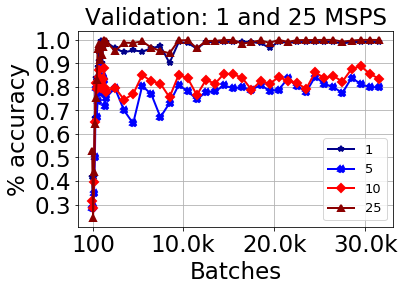

In [13]:
formatter = FuncFormatter(kilo_samples)
lim1 = 1500
a = np.arange(0,lim1,100) # Start at index position 1
lim2 = 300000
b = np.arange(1500,lim2,1000) # Start at index position 1
x = np.concatenate((a, b), axis=0)
a = 0
num = 46
# x = np.arange(0,num,1) # Start at index position 1
plt.rcParams.update({'font.size': 23})
# plt.figure(figsize=(9, 6))

# fig2 = plt.figure()

fig2, ax = plt.subplots()
ax.xaxis.set_major_formatter(formatter)



# ax = plt.subplot(111)
# Shrink current axis by 20%
# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

plt.plot(x[a:num],resnet50_plot_1msps[a:num], '-*', c='darkblue',markersize=6, linewidth=2,markerfacecolor='darkblue',markeredgecolor='darkblue',markeredgewidth=2, label='1')
plt.plot(x[a:num],resnet50_plot_5msps[a:num], '-X', c='blue', markersize=6, linewidth=2,markerfacecolor='blue',markeredgecolor='blue',markeredgewidth=2, label='5')
plt.plot(x[a:num],resnet50_plot_10msps[a:num], '-D', c='red', markersize=6, linewidth=2,markerfacecolor='red',markeredgecolor='red',markeredgewidth=2, label='10')
plt.plot(x[a:num],resnet50_plot_25msps[a:num], '-^', c='darkred', markersize=6, linewidth=2,markerfacecolor='darkred',markeredgecolor='darkred',markeredgewidth=2, label='25')
plt.legend(loc='lower right', fontsize=13)
# Put a legend to the right of the current axis
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Validation: 1 and 25 MSPS', fontsize=23)
plt.xlabel('Batches')
plt.ylabel('% accuracy')
plt.grid()
# plt.minorticks_on()
# plt.yticks(np.arange(.5,1, .1))
# plt.yticks([.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0])
plt.yticks([.3, .4, .5, .6, .7, .8, .9, 1.0])
# plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 10])
plt.xticks([100, 10000,20000, 30000])
# plt.tight_layout()
axes=plt.gca()
# ax.set_aspect('equal')
# axes.set_aspect(10)
plt.subplots_adjust(left=0.17)
plt.subplots_adjust(bottom=0.20)
# fig2.set_size_inches(8.27, 11.69)
fig2.set_size_inches(6.0, 4.0)
fig2.savefig('resnet50_1class_20220210_mix_msps.pdf', format="pdf")

#### original plot used in paper

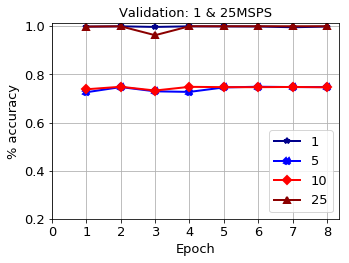

In [96]:
# num = len(resnet50_4D) # reduced rank by 1 for matrix math to work out
num = 9
x = np.arange(0,num,1) # Start at index position 1
plt.rcParams.update({'font.size': 13})
# plt.figure(figsize=(9, 6))

fig2 = plt.figure()
# ax = plt.subplot(111)
# Shrink current axis by 20%
# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

plt.plot(x[1:num],resnet50_plot_1msps[1:num], '-*', c='darkblue',markersize=6, linewidth=2,markerfacecolor='darkblue',markeredgecolor='darkblue',markeredgewidth=2, label='1')
plt.plot(x[1:num],resnet50_plot_5msps[1:num], '-X', c='blue', markersize=6, linewidth=2,markerfacecolor='blue',markeredgecolor='blue',markeredgewidth=2, label='5')
plt.plot(x[1:num],resnet50_plot_10msps[1:num], '-D', c='red', markersize=6, linewidth=2,markerfacecolor='red',markeredgecolor='red',markeredgewidth=2, label='10')
plt.plot(x[1:num],resnet50_plot_25msps[1:num], '-^', c='darkred', markersize=6, linewidth=2,markerfacecolor='darkred',markeredgecolor='darkred',markeredgewidth=2, label='25')
plt.legend(loc='lower right', fontsize=13)
# Put a legend to the right of the current axis
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Validation: 1 & 25MSPS', fontsize=13)
plt.xlabel('Epoch')
plt.ylabel('% accuracy')
plt.grid()
# plt.minorticks_on()
# plt.yticks(np.arange(.5,1, .1))
plt.yticks([.2, .4, .6, .8, 1.0])
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
# plt.tight_layout()
axes=plt.gca()
axes.set_aspect(7)
plt.subplots_adjust(left=0.15)
plt.subplots_adjust(bottom=0.20)
fig2.set_size_inches(6.0, 4.0)
fig2.savefig('resnet50_mix_1class_20220125_old.pdf', format="pdf")
# plt.show()

#### Training 2 classes per patch

In [119]:
batches = 64
classes = 2
batches = batches*classes

In [120]:
criterion = nn.BCEWithLogitsLoss()
lr= 1e-4 # .0004
optimizer = optim.Adam(model.parameters(), lr=lr)
model.train()

ResNet(
  (encoder): ResNetEncoder(
    (gate): Sequential(
      (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (blocks): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNetBottleNeckBlock(
            (blocks): Sequential(
              (0): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): ReLU()
              (2): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

#### seperated dataloaders

In [ ]:
# train_dataloader1 = RFDataset(path_1msps, limit=None)
# train_dataloader25 = RFDataset(path_25msps, limit=None)

In [ ]:
# training_data1 = data.DataLoader(train_dataloader1, batch_size=batches, shuffle=True)
# training_data25 = data.DataLoader(train_dataloader25, batch_size=batches, shuffle=True)

#### combined dataloaders (External drive)

In [106]:
train_dataloader = RFDataset(path, limit=None)

/media/david/Extreme Pro/data/combined_data/training_data/
list of patches = 361200


In [107]:
training_data = data.DataLoader(train_dataloader, batch_size=batches, shuffle=True)

In [ ]:
# val_patches = None
# rf_dataset_val = RFDataset(path_validation, limit=val_patches)
# validation_data = data.DataLoader(rf_dataset_val, batch_size=batches, shuffle=True)
# validation_data = [validation_data]

In [108]:
val_patches = None
rf_dataset_val1 = RFDataset(path_val_1msps, limit=val_patches)
rf_dataset_val5 = RFDataset(path_val_5msps, limit=val_patches)
rf_dataset_val10 = RFDataset(path_val_10msps, limit=val_patches)
rf_dataset_val25 = RFDataset(path_val_25msps, limit=val_patches)
validation_data1 = data.DataLoader(rf_dataset_val1, batch_size=batches, shuffle=True)
validation_data1 = [validation_data1]
validation_data5 = data.DataLoader(rf_dataset_val5, batch_size=batches, shuffle=True)
validation_data5 = [validation_data5]
validation_data10 = data.DataLoader(rf_dataset_val10, batch_size=batches, shuffle=True)
validation_data10 = [validation_data10]
validation_data25 = data.DataLoader(rf_dataset_val25, batch_size=batches, shuffle=True)
validation_data25 = [validation_data25]

/home/david/sigMF_ML/RF/RF_class/val_1msps/
list of patches = 24000
/home/david/sigMF_ML/RF/RF_class/val_5msps/
list of patches = 20004
/home/david/sigMF_ML/RF/RF_class/val_10msps/
list of patches = 20004
/home/david/sigMF_ML/RF/RF_class/val_25msps/
list of patches = 24000


In [140]:
total = 6
loss_plot2, total_plot2, plot_1msps2, plot_5msps2, plot_10msps2, plot_25msps2 = train_net_combined_data(total)

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

batches =  64
total patch count =  88008
training data length =  5644
iter epoch =  100
iter batch =  100
i_main =  100
batch time =  0.8542757428949699
************************* start *************************
Total 1msps correct = 47.52%
Total 5msps correct = 29.54%
Total 10msps correct = 33.73%


Epoch:   0%|          | 0/6 [07:19<?, ?it/s]

Total 25msps correct = 41.65%
Total % correct 38.70%
test time =  378.4072932730196
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.1143689379 
___________________________________________
iter epoch =  200
iter batch =  100
i_main =  200
batch time =  0.7962474670493975
************************* start *************************
Total 1msps correct = 35.20%
Total 5msps correct = 23.01%
Total 10msps correct = 25.34%


Epoch:   0%|          | 0/6 [13:38<?, ?it/s]

Total 25msps correct = 27.06%
Total % correct 27.97%
test time =  319.2628586179344
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.1769014895 
___________________________________________
iter epoch =  300
iter batch =  100
i_main =  300
batch time =  0.7975121919298545
************************* start *************************
Total 1msps correct = 48.83%
Total 5msps correct = 24.70%
Total 10msps correct = 35.43%


Epoch:   0%|          | 0/6 [19:50<?, ?it/s]

Total 25msps correct = 37.18%
Total % correct 37.12%
test time =  312.02880768908653
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.1342757344 
___________________________________________
iter epoch =  400
iter batch =  100
i_main =  400
batch time =  0.7855909049976617
************************* start *************************
Total 1msps correct = 73.00%
Total 5msps correct = 45.65%
Total 10msps correct = 47.33%


Epoch:   0%|          | 0/6 [26:01<?, ?it/s]

Total 25msps correct = 52.35%
Total % correct 55.31%
test time =  311.1049868199043
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0601985268 
___________________________________________
iter epoch =  500
iter batch =  100
i_main =  500
batch time =  0.8423188260057941
************************* start *************************
Total 1msps correct = 67.08%
Total 5msps correct = 43.87%
Total 10msps correct = 48.88%


Epoch:   0%|          | 0/6 [32:14<?, ?it/s]

Total 25msps correct = 74.96%
Total % correct 59.82%
test time =  312.1982128380332
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0483578555 
___________________________________________
iter epoch =  600
iter batch =  100
i_main =  600
batch time =  0.789198521990329
************************* start *************************
Total 1msps correct = 89.71%
Total 5msps correct = 50.77%
Total 10msps correct = 67.62%


Epoch:   0%|          | 0/6 [38:27<?, ?it/s]

Total 25msps correct = 82.41%
Total % correct 73.85%
test time =  313.1464911419898
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0437269956 
___________________________________________
iter epoch =  700
iter batch =  100
i_main =  700
batch time =  0.829573140013963
************************* start *************************
Total 1msps correct = 87.60%
Total 5msps correct = 49.52%
Total 10msps correct = 67.41%


Epoch:   0%|          | 0/6 [44:40<?, ?it/s]

Total 25msps correct = 94.24%
Total % correct 76.16%
test time =  313.59312103304546
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0258344822 
___________________________________________
iter epoch =  800
iter batch =  100
i_main =  800
batch time =  0.7983567819464952
************************* start *************************
Total 1msps correct = 94.60%
Total 5msps correct = 59.69%
Total 10msps correct = 77.46%


Epoch:   0%|          | 0/6 [50:52<?, ?it/s]

Total 25msps correct = 95.07%
Total % correct 82.90%
test time =  312.15830264403485
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0124200061 
___________________________________________
iter epoch =  900
iter batch =  100
i_main =  900
batch time =  0.7869214550592005
************************* start *************************
Total 1msps correct = 92.39%
Total 5msps correct = 60.18%
Total 10msps correct = 90.13%


Epoch:   0%|          | 0/6 [57:04<?, ?it/s]

Total 25msps correct = 98.63%
Total % correct 86.26%
test time =  311.6640164969722
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0274061672 
___________________________________________
iter epoch =  1000
iter batch =  100
i_main =  1000
batch time =  0.784330127062276
************************* start *************************
Total 1msps correct = 56.25%
Total 5msps correct = 24.69%
Total 10msps correct = 30.18%


Epoch:   0%|          | 0/6 [1:03:16<?, ?it/s]

Total 25msps correct = 36.41%
Total % correct 37.74%
test time =  311.93795683793724
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.2229702324 
___________________________________________
iter epoch =  1100
iter batch =  100
i_main =  1100
batch time =  0.8303580270148814
************************* start *************************
Total 1msps correct = 82.75%
Total 5msps correct = 47.90%
Total 10msps correct = 64.54%


Epoch:   0%|          | 0/6 [1:09:28<?, ?it/s]

Total 25msps correct = 85.15%
Total % correct 71.35%
test time =  312.7351629040204
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0380139574 
___________________________________________
iter epoch =  1200
iter batch =  100
i_main =  1200
batch time =  0.7894394360482693
************************* start *************************
Total 1msps correct = 75.52%
Total 5msps correct = 46.02%
Total 10msps correct = 67.33%


Epoch:   0%|          | 0/6 [1:15:42<?, ?it/s]

Total 25msps correct = 86.85%
Total % correct 70.04%
test time =  313.8182384420652
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0563440621 
___________________________________________
iter epoch =  1300
iter batch =  100
i_main =  1300
batch time =  0.7890534119214863
************************* start *************************
Total 1msps correct = 86.05%
Total 5msps correct = 62.76%
Total 10msps correct = 76.72%


Epoch:   0%|          | 0/6 [1:21:55<?, ?it/s]

Total 25msps correct = 92.36%
Total % correct 80.36%
test time =  313.0489100329578
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0147202276 
___________________________________________
iter epoch =  1400
iter batch =  100
i_main =  1400
batch time =  0.7913402820704505
************************* start *************************
Total 1msps correct = 91.10%
Total 5msps correct = 64.79%
Total 10msps correct = 77.94%


Epoch:   0%|          | 0/6 [1:28:09<?, ?it/s]

Total 25msps correct = 95.49%
Total % correct 83.33%
test time =  313.03962411603425
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0137910247 
___________________________________________
iter epoch =  2000
iter batch =  1000
i_main =  2000
batch time =  0.8039480790030211
************************* start *************************
Total 1msps correct = 90.58%
Total 5msps correct = 61.39%
Total 10msps correct = 74.49%


Epoch:   0%|          | 0/6 [1:39:24<?, ?it/s]

Total 25msps correct = 93.47%
Total % correct 81.07%
test time =  316.885737482924
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0367958210 
___________________________________________
iter epoch =  3000
iter batch =  1000
i_main =  3000
batch time =  0.8228448230074719
************************* start *************************
Total 1msps correct = 92.15%
Total 5msps correct = 75.20%
Total 10msps correct = 80.18%


Epoch:   0%|          | 0/6 [1:54:50<?, ?it/s]

Total 25msps correct = 99.72%
Total % correct 87.64%
test time =  331.3512665149756
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0003595683 
___________________________________________
iter epoch =  4000
iter batch =  1000
i_main =  4000
batch time =  0.8117338459705934
************************* start *************************
Total 1msps correct = 87.85%
Total 5msps correct = 69.34%
Total 10msps correct = 74.41%


Epoch:   0%|          | 0/6 [2:10:14<?, ?it/s]

Total 25msps correct = 77.30%
Total % correct 77.71%
test time =  328.294455596013
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0634045303 
___________________________________________
iter epoch =  5000
iter batch =  1000
i_main =  5000
batch time =  0.7925363479880616
************************* start *************************
Total 1msps correct = 94.66%
Total 5msps correct = 68.04%
Total 10msps correct = 76.03%


Epoch:   0%|          | 0/6 [2:25:44<?, ?it/s]

Total 25msps correct = 97.18%
Total % correct 85.06%
test time =  332.3113362110453
*************************** end ***************************
___________________________________________
Epoch 1 Loss 0.0070929392 
___________________________________________
left over patches =  48


Epoch:  17%|█▋        | 1/6 [2:32:07<12:40:37, 9127.48s/it]

iter epoch =  356
iter batch =  1000
i_main =  6000
batch time =  0.8166323369368911
************************* start *************************
Total 1msps correct = 98.91%
Total 5msps correct = 72.91%
Total 10msps correct = 77.21%


Epoch:  17%|█▋        | 1/6 [2:40:50<12:40:37, 9127.48s/it]

Total 25msps correct = 99.67%
Total % correct 88.27%
test time =  319.17380337801296
*************************** end ***************************
___________________________________________
Epoch 2 Loss 0.0001535366 
___________________________________________
iter epoch =  1356
iter batch =  1000
i_main =  7000
batch time =  0.7907431710045785
************************* start *************************
Total 1msps correct = 99.11%
Total 5msps correct = 82.33%
Total 10msps correct = 80.86%


Epoch:  17%|█▋        | 1/6 [2:56:15<12:40:37, 9127.48s/it]

Total 25msps correct = 99.81%
Total % correct 91.34%
test time =  333.84438144695014
*************************** end ***************************
___________________________________________
Epoch 2 Loss 0.0000098877 
___________________________________________
iter epoch =  2356
iter batch =  1000
i_main =  8000
batch time =  0.8336683480301872
************************* start *************************
Total 1msps correct = 96.33%
Total 5msps correct = 75.44%
Total 10msps correct = 82.24%


Epoch:  17%|█▋        | 1/6 [3:11:44<12:40:37, 9127.48s/it]

Total 25msps correct = 97.69%
Total % correct 88.75%
test time =  333.74959161900915
*************************** end ***************************
___________________________________________
Epoch 2 Loss 0.0025273613 
___________________________________________
iter epoch =  3356
iter batch =  1000
i_main =  9000
batch time =  0.8032851909520105
************************* start *************************
Total 1msps correct = 91.92%
Total 5msps correct = 71.22%
Total 10msps correct = 77.89%


Epoch:  17%|█▋        | 1/6 [3:27:13<12:40:37, 9127.48s/it]

Total 25msps correct = 99.01%
Total % correct 85.96%
test time =  333.267885586014
*************************** end ***************************
___________________________________________
Epoch 2 Loss 0.0055562397 
___________________________________________
iter epoch =  4356
iter batch =  1000
i_main =  10000
batch time =  0.8285176359349862
************************* start *************************
Total 1msps correct = 97.38%
Total 5msps correct = 73.05%
Total 10msps correct = 74.39%


Epoch:  17%|█▋        | 1/6 [3:42:44<12:40:37, 9127.48s/it]

Total 25msps correct = 98.92%
Total % correct 87.04%
test time =  334.5581556650577
*************************** end ***************************
___________________________________________
Epoch 2 Loss 0.0041630003 
___________________________________________
iter epoch =  5356
iter batch =  1000
i_main =  11000
batch time =  0.8154760430334136
************************* start *************************
Total 1msps correct = 99.04%
Total 5msps correct = 74.27%
Total 10msps correct = 76.17%


Epoch:  17%|█▋        | 1/6 [3:58:11<12:40:37, 9127.48s/it]

Total 25msps correct = 99.95%
Total % correct 88.46%
test time =  331.5807210460771
*************************** end ***************************
___________________________________________
Epoch 2 Loss 0.0001358651 
___________________________________________
left over patches =  48


Epoch:  33%|███▎      | 2/6 [4:01:02<8:52:38, 7989.63s/it] 

iter epoch =  712
iter batch =  1000
i_main =  12000
batch time =  0.8085828210460022
************************* start *************************
Total 1msps correct = 98.26%
Total 5msps correct = 75.30%
Total 10msps correct = 75.78%


Epoch:  33%|███▎      | 2/6 [4:13:24<8:52:38, 7989.63s/it]

Total 25msps correct = 99.03%
Total % correct 88.14%
test time =  328.74551824701484
*************************** end ***************************
___________________________________________
Epoch 3 Loss 0.0032410889 
___________________________________________
iter epoch =  1712
iter batch =  1000
i_main =  13000
batch time =  0.7905491890851408
************************* start *************************
Total 1msps correct = 99.13%
Total 5msps correct = 70.86%
Total 10msps correct = 73.77%


Epoch:  33%|███▎      | 2/6 [4:28:53<8:52:38, 7989.63s/it]

Total 25msps correct = 99.85%
Total % correct 87.14%
test time =  336.0431678610621
*************************** end ***************************
___________________________________________
Epoch 3 Loss 0.0000901384 
___________________________________________
iter epoch =  2712
iter batch =  1000
i_main =  14000
batch time =  0.8512921429937705
************************* start *************************
Total 1msps correct = 98.79%
Total 5msps correct = 76.81%
Total 10msps correct = 76.20%


Epoch:  33%|███▎      | 2/6 [4:44:19<8:52:38, 7989.63s/it]

Total 25msps correct = 99.24%
Total % correct 88.78%
test time =  329.7994671140332
*************************** end ***************************
___________________________________________
Epoch 3 Loss 0.0004077372 
___________________________________________
iter epoch =  3712
iter batch =  1000
i_main =  15000
batch time =  0.811685387045145
************************* start *************************
Total 1msps correct = 98.82%
Total 5msps correct = 79.45%
Total 10msps correct = 75.92%


Epoch:  33%|███▎      | 2/6 [4:59:46<8:52:38, 7989.63s/it]

Total 25msps correct = 99.53%
Total % correct 89.41%
test time =  331.14055534196086
*************************** end ***************************
___________________________________________
Epoch 3 Loss 0.0003458313 
___________________________________________
iter epoch =  4712
iter batch =  1000
i_main =  16000
batch time =  0.7959081920562312
************************* start *************************
Total 1msps correct = 98.99%
Total 5msps correct = 81.32%
Total 10msps correct = 77.85%


Epoch:  33%|███▎      | 2/6 [5:15:15<8:52:38, 7989.63s/it]

Total 25msps correct = 99.69%
Total % correct 90.36%
test time =  334.74965460097883
*************************** end ***************************
___________________________________________
Epoch 3 Loss 0.0001319742 
___________________________________________
left over patches =  48


Epoch:  50%|█████     | 3/6 [5:24:27<5:54:43, 7094.49s/it]

iter epoch =  68
iter batch =  1000
i_main =  17000
batch time =  0.7955953510245308
************************* start *************************
Total 1msps correct = 99.25%
Total 5msps correct = 79.16%
Total 10msps correct = 77.28%


Epoch:  50%|█████     | 3/6 [5:30:41<5:54:43, 7094.49s/it]

Total 25msps correct = 98.49%
Total % correct 89.49%
test time =  334.3392848720541
*************************** end ***************************
___________________________________________
Epoch 4 Loss 0.0175386854 
___________________________________________
iter epoch =  1068
iter batch =  1000
i_main =  18000
batch time =  0.8368020419729874
************************* start *************************
Total 1msps correct = 98.51%
Total 5msps correct = 72.76%
Total 10msps correct = 77.23%


Epoch:  50%|█████     | 3/6 [5:46:05<5:54:43, 7094.49s/it]

Total 25msps correct = 99.87%
Total % correct 88.19%
test time =  338.2926080089528
*************************** end ***************************
___________________________________________
Epoch 4 Loss 0.0003303055 
___________________________________________
iter epoch =  2068
iter batch =  1000
i_main =  19000
batch time =  0.8436895430786535
************************* start *************************
Total 1msps correct = 99.30%
Total 5msps correct = 75.85%
Total 10msps correct = 78.58%


Epoch:  50%|█████     | 3/6 [6:01:38<5:54:43, 7094.49s/it]

Total 25msps correct = 99.42%
Total % correct 89.29%
test time =  338.60623512696475
*************************** end ***************************
___________________________________________
Epoch 4 Loss 0.0004862811 
___________________________________________
iter epoch =  3068
iter batch =  1000
i_main =  20000
batch time =  0.8165926410583779
************************* start *************************
Total 1msps correct = 97.59%
Total 5msps correct = 74.15%
Total 10msps correct = 77.24%


Epoch:  50%|█████     | 3/6 [6:17:04<5:54:43, 7094.49s/it]

Total 25msps correct = 96.97%
Total % correct 87.47%
test time =  331.09356993599795
*************************** end ***************************
___________________________________________
Epoch 4 Loss 0.0188733377 
___________________________________________
iter epoch =  4068
iter batch =  1000
i_main =  21000
batch time =  0.8252357048913836
************************* start *************************
Total 1msps correct = 99.19%
Total 5msps correct = 74.48%
Total 10msps correct = 72.03%


Epoch:  50%|█████     | 3/6 [6:32:31<5:54:43, 7094.49s/it]

Total 25msps correct = 99.04%
Total % correct 87.36%
test time =  329.97842260997277
*************************** end ***************************
___________________________________________
Epoch 4 Loss 0.0000287867 
___________________________________________
iter epoch =  5068
iter batch =  1000
i_main =  22000
batch time =  0.7982797909062356
************************* start *************************
Total 1msps correct = 99.11%
Total 5msps correct = 79.95%
Total 10msps correct = 75.75%


Epoch:  50%|█████     | 3/6 [6:47:56<5:54:43, 7094.49s/it]

Total 25msps correct = 99.75%
Total % correct 89.62%
test time =  331.73507989698555
*************************** end ***************************
___________________________________________
Epoch 4 Loss 0.0000124190 
___________________________________________
left over patches =  48


Epoch:  67%|██████▋   | 4/6 [6:53:37<3:39:02, 6571.06s/it]

iter epoch =  424
iter batch =  1000
i_main =  23000
batch time =  0.8406637600855902
************************* start *************************
Total 1msps correct = 98.82%
Total 5msps correct = 71.67%
Total 10msps correct = 74.21%


Epoch:  67%|██████▋   | 4/6 [7:03:06<3:39:02, 6571.06s/it]

Total 25msps correct = 99.88%
Total % correct 87.34%
test time =  325.17760936997365
*************************** end ***************************
___________________________________________
Epoch 5 Loss 0.0000481985 
___________________________________________
iter epoch =  1424
iter batch =  1000
i_main =  24000
batch time =  0.8782665439648554
************************* start *************************
Total 1msps correct = 99.09%
Total 5msps correct = 74.73%
Total 10msps correct = 72.73%


Epoch:  67%|██████▋   | 4/6 [7:18:36<3:39:02, 6571.06s/it]

Total 25msps correct = 98.72%
Total % correct 87.46%
test time =  338.3201330859447
*************************** end ***************************
___________________________________________
Epoch 5 Loss 0.0000888508 
___________________________________________
iter epoch =  2424
iter batch =  1000
i_main =  25000
batch time =  0.7922706750687212
************************* start *************************
Total 1msps correct = 98.99%
Total 5msps correct = 75.12%
Total 10msps correct = 71.85%


Epoch:  67%|██████▋   | 4/6 [7:34:03<3:39:02, 6571.06s/it]

Total 25msps correct = 99.07%
Total % correct 87.42%
test time =  331.6759395529516
*************************** end ***************************
___________________________________________
Epoch 5 Loss 0.0000526300 
___________________________________________
iter epoch =  3424
iter batch =  1000
i_main =  26000
batch time =  0.7975846400950104
************************* start *************************
Total 1msps correct = 99.19%
Total 5msps correct = 76.22%
Total 10msps correct = 75.26%


Epoch:  67%|██████▋   | 4/6 [7:49:32<3:39:02, 6571.06s/it]

Total 25msps correct = 99.64%
Total % correct 88.65%
test time =  334.04201404191554
*************************** end ***************************
___________________________________________
Epoch 5 Loss 0.0001293983 
___________________________________________
iter epoch =  4424
iter batch =  1000
i_main =  27000
batch time =  0.7952391339931637
************************* start *************************
Total 1msps correct = 99.55%
Total 5msps correct = 76.48%
Total 10msps correct = 75.32%


Epoch:  67%|██████▋   | 4/6 [8:04:59<3:39:02, 6571.06s/it]

Total 25msps correct = 99.87%
Total % correct 88.89%
test time =  331.4833786659874
*************************** end ***************************
___________________________________________
Epoch 5 Loss 0.0000769514 
___________________________________________
iter epoch =  5424
iter batch =  1000
i_main =  28000
batch time =  0.8064211269374937
************************* start *************************
Total 1msps correct = 99.08%
Total 5msps correct = 75.05%
Total 10msps correct = 71.22%


Epoch:  67%|██████▋   | 4/6 [8:20:23<3:39:02, 6571.06s/it]

Total 25msps correct = 99.05%
Total % correct 87.28%
test time =  328.5781100189779
*************************** end ***************************
___________________________________________
Epoch 5 Loss 0.0000729195 
___________________________________________
left over patches =  48


Epoch:  83%|████████▎ | 5/6 [8:22:33<1:43:20, 6200.47s/it]

iter epoch =  780
iter batch =  1000
i_main =  29000
batch time =  0.8376079850131646
************************* start *************************
Total 1msps correct = 99.21%
Total 5msps correct = 74.22%
Total 10msps correct = 77.12%


Epoch:  83%|████████▎ | 5/6 [8:35:31<1:43:20, 6200.47s/it]

Total 25msps correct = 99.28%
Total % correct 88.53%
test time =  325.58044267003424
*************************** end ***************************
___________________________________________
Epoch 6 Loss 0.0001666178 
___________________________________________
iter epoch =  1780
iter batch =  1000
i_main =  30000
batch time =  0.8012292989296839
************************* start *************************
Total 1msps correct = 99.65%
Total 5msps correct = 76.39%
Total 10msps correct = 71.59%


Epoch:  83%|████████▎ | 5/6 [8:51:00<1:43:20, 6200.47s/it]

Total 25msps correct = 99.05%
Total % correct 87.82%
test time =  333.4561681979103
*************************** end ***************************
___________________________________________
Epoch 6 Loss 0.0000288653 
___________________________________________
iter epoch =  2780
iter batch =  1000
i_main =  31000
batch time =  0.8071768389781937
************************* start *************************
Total 1msps correct = 98.82%
Total 5msps correct = 71.70%
Total 10msps correct = 71.44%


Epoch:  83%|████████▎ | 5/6 [9:06:23<1:43:20, 6200.47s/it]

Total 25msps correct = 98.88%
Total % correct 86.45%
test time =  328.36805094999727
*************************** end ***************************
___________________________________________
Epoch 6 Loss 0.0000764182 
___________________________________________
iter epoch =  3780
iter batch =  1000
i_main =  32000
batch time =  0.8019239330897108
************************* start *************************
Total 1msps correct = 99.04%
Total 5msps correct = 71.65%
Total 10msps correct = 71.97%


Epoch:  83%|████████▎ | 5/6 [9:21:47<1:43:20, 6200.47s/it]

Total 25msps correct = 99.76%
Total % correct 86.86%
test time =  329.1257902070647
*************************** end ***************************
___________________________________________
Epoch 6 Loss 0.0001613240 
___________________________________________
iter epoch =  4780
iter batch =  1000
i_main =  33000
batch time =  0.7895632459549233
************************* start *************************
Total 1msps correct = 99.25%
Total 5msps correct = 73.78%
Total 10msps correct = 72.44%


Epoch:  83%|████████▎ | 5/6 [9:37:14<1:43:20, 6200.47s/it]

Total 25msps correct = 99.82%
Total % correct 87.52%
test time =  331.6401035800809
*************************** end ***************************
___________________________________________
Epoch 6 Loss 0.0002899316 
___________________________________________
left over patches =  48


Epoch: 100%|██████████| 6/6 [9:45:47<00:00, 5857.86s/it]  


In [114]:
resnet50_plot_1msps2

array([0.0295    , 0.11883333, 0.16708333, 0.26708333, 0.32091667,
       0.46583333, 0.41758333, 0.56866667, 0.63933333, 0.64291667,
       0.65241667, 0.688     , 0.62691667, 0.71133333, 0.80775   ,
       0.85816667, 0.87383333, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

### PLOTTING 2 classes/patch

In [112]:
path_plot_fig = "/home/david/sigMF_ML/RF/RF_class/plot_data/" # ACE
os.chdir(path_plot_fig)
np.save('resnet50_4ch_total_plot2_20220202', np.asarray(total_plot2))
np.save('resnet50_4ch_plot_1msps2_20220202', np.asarray(plot_1msps2))
np.save('resnet50_4ch_plot_5msps2_20220202', np.asarray(plot_5msps2))
np.save('resnet50_4ch_plot_10msps2_20220202', np.asarray(plot_10msps2))
np.save('resnet50_4ch_plot_25msps2_20220202', np.asarray(plot_25msps2))

In [113]:
path_plot_fig = "/home/david/sigMF_ML/RF/RF_class/plot_data/" # ACE
os.chdir(path_plot_fig)
resnet50_total_plot2 = np.load('resnet50_4ch_total_plot2_20220202.npy')
resnet50_plot_1msps2 = np.load('resnet50_4ch_plot_1msps2_20220202.npy')
resnet50_plot_5msps2 = np.load('resnet50_4ch_plot_5msps2_20220202.npy')
resnet50_plot_10msps2 = np.load('resnet50_4ch_plot_10msps2_20220202.npy')
resnet50_plot_25msps2 = np.load('resnet50_4ch_plot_25msps2_20220202.npy')

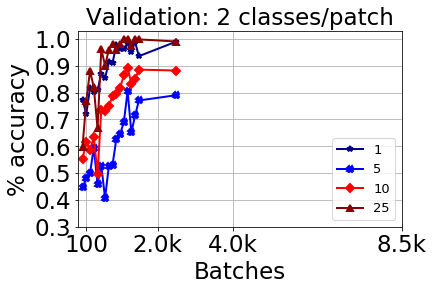

In [115]:
formatter = FuncFormatter(kilo_samples)
lim1 = 1500
a = np.arange(0,lim1,100) # Start at index position 1
lim2 = 11000
b = np.arange(1500,lim2,1000) # Start at index position 1
x = np.concatenate((a, b), axis=0)
a = 0
num = 17
# x = np.arange(0,num,1) # Start at index position 1
plt.rcParams.update({'font.size': 23})
fig2, ax = plt.subplots()
ax.xaxis.set_major_formatter(formatter)

plt.plot(x[a:num],resnet50_plot_1msps[a:num], '-*', c='darkblue',markersize=6, linewidth=2,markerfacecolor='darkblue',markeredgecolor='darkblue',markeredgewidth=2, label='1')
plt.plot(x[a:num],resnet50_plot_5msps[a:num], '-X', c='blue', markersize=6, linewidth=2,markerfacecolor='blue',markeredgecolor='blue',markeredgewidth=2, label='5')
plt.plot(x[a:num],resnet50_plot_10msps[a:num], '-D', c='red', markersize=6, linewidth=2,markerfacecolor='red',markeredgecolor='red',markeredgewidth=2, label='10')
plt.plot(x[a:num],resnet50_plot_25msps[a:num], '-^', c='darkred', markersize=6, linewidth=2,markerfacecolor='darkred',markeredgecolor='darkred',markeredgewidth=2, label='25')
plt.legend(loc='lower right', fontsize=13)
# Put a legend to the right of the current axis
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Validation: 2 classes/patch', fontsize=23)
plt.xlabel('Batches')
plt.ylabel('% accuracy')
plt.grid()
# plt.minorticks_on()
# plt.yticks(np.arange(.5,1, .1))
# plt.yticks([.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0])
plt.yticks([.3, .4, .5, .6, .7, .8, .9, 1.0])
# plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 10])
plt.xticks([100, 2000,4000, 8500])
# plt.tight_layout()
axes=plt.gca()
# ax.set_aspect('equal')
# axes.set_aspect(10)
plt.subplots_adjust(left=0.15)
plt.subplots_adjust(bottom=0.20)
# fig2.set_size_inches(8.27, 11.69)
fig2.set_size_inches(6.0, 4.0)
fig2.savefig('resnet50_2classes_20220202.pdf', format="pdf")

#### original 2 class/patch plot

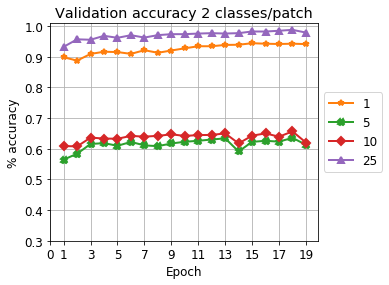

In [81]:
# num = len(resnet50_4D) # reduced rank by 1 for matrix math to work out
num = 20
plt.rcParams.update({'font.size': 12})
x = np.arange(0,num,1) # Start at index position 1
# plt.figure(figsize=(9, 6))

fig2 = plt.figure()
ax = plt.subplot(111)
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# plt.plot(x[0:num],resnet50_total_plot2[:num], '-o', c='#1f77b4',markersize=6, linewidth=2,markerfacecolor='#1f77b4',markeredgecolor='#1f77b4',markeredgewidth=2,label='total')
plt.plot(x[1:num],resnet50_plot_1msps2[1:num], '-*', c='#ff7f0e',markersize=6, linewidth=2,markerfacecolor='#ff7f0e',markeredgecolor='#ff7f0e',markeredgewidth=2, label='1')
plt.plot(x[1:num],resnet50_plot_5msps2[1:num], '-X', c='#2ca02c', markersize=6, linewidth=2,markerfacecolor='#2ca02c',markeredgecolor='#2ca02c',markeredgewidth=2, label='5')
plt.plot(x[1:num],resnet50_plot_10msps2[1:num], '-D', c='#d62728', markersize=6, linewidth=2,markerfacecolor='#d62728',markeredgecolor='#d62728',markeredgewidth=2, label='10')
plt.plot(x[1:num],resnet50_plot_25msps2[1:num], '-^', c='#9467bd', markersize=6, linewidth=2,markerfacecolor='#9467bd',markeredgecolor='#9467bd',markeredgewidth=2, label='25')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.legend(loc='center right')
plt.title('Validation accuracy 2 classes/patch')
plt.xlabel('Epoch')
plt.ylabel('% accuracy')
plt.grid()
# plt.minorticks_on()
# plt.yticks(np.arange(.1,1, .1))
plt.yticks([.3, .4,.5, .6, .7, .8, .9, 1.0])
plt.xticks([0, 1, 3, 5, 7, 9, 11,13,15,17,19])
fig2.savefig('resnet50_4ch_20211223_2classes.pdf', format="pdf")
plt.show()

#### Training for 3 classes per patch

In [73]:
batches = 64
classes = 3
batches = batches*classes

In [70]:
criterion = nn.BCEWithLogitsLoss()
lr= 1e-4 # .0004
optimizer = optim.Adam(model.parameters(), lr=lr)
model.train()

#### seperated dataloaders

In [ ]:
# train_dataloader1 = RFDataset(path_1msps, limit=None)
# train_dataloader25 = RFDataset(path_25msps, limit=None)

In [ ]:
# training_data1 = data.DataLoader(train_dataloader1, batch_size=batches, shuffle=True)
# training_data25 = data.DataLoader(train_dataloader25, batch_size=batches, shuffle=True)

#### combined dataloaders (External drive)

In [63]:
train_dataloader = RFDataset(path, limit=None)

/media/david/Extreme Pro/data/combined_data/training_data/
list of patches = 361200


In [64]:
training_data = data.DataLoader(train_dataloader, batch_size=batches, shuffle=True)

In [ ]:
# val_patches = None
# rf_dataset_val = RFDataset(path_validation, limit=val_patches)
# validation_data = data.DataLoader(rf_dataset_val, batch_size=batches, shuffle=True)
# validation_data = [validation_data]

In [65]:
val_patches = None
rf_dataset_val1 = RFDataset(path_val_1msps, limit=val_patches)
rf_dataset_val5 = RFDataset(path_val_5msps, limit=val_patches)
rf_dataset_val10 = RFDataset(path_val_10msps, limit=val_patches)
rf_dataset_val25 = RFDataset(path_val_25msps, limit=val_patches)
validation_data1 = data.DataLoader(rf_dataset_val1, batch_size=batches, shuffle=True)
validation_data1 = [validation_data1]
validation_data5 = data.DataLoader(rf_dataset_val5, batch_size=batches, shuffle=True)
validation_data5 = [validation_data5]
validation_data10 = data.DataLoader(rf_dataset_val10, batch_size=batches, shuffle=True)
validation_data10 = [validation_data10]
validation_data25 = data.DataLoader(rf_dataset_val25, batch_size=batches, shuffle=True)
validation_data25 = [validation_data25]

/home/david/sigMF_ML/RF/RF_class/val_1msps/
list of patches = 24000
/home/david/sigMF_ML/RF/RF_class/val_5msps/
list of patches = 20004
/home/david/sigMF_ML/RF/RF_class/val_10msps/
list of patches = 20004
/home/david/sigMF_ML/RF/RF_class/val_25msps/
list of patches = 24000


In [90]:
total = 10
loss_plot3, total_plot3, plot_1msps3, plot_5msps3, plot_10msps3, plot_25msps3 = train_net_combined_data(total)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

batches =  192
total patch count =  1496
training data length =  1882
iteration =  500
batch time =  0.3815989530121442
************************* start *************************
Total 1msps correct = 78.19%
Total 5msps correct = 57.05%
Total 10msps correct = 62.67%
Total 25msps correct = 88.91%
Total % correct 63.94%
test time =  35.49947536399122
*************************** end ***************************


Epoch:   0%|          | 0/10 [09:01<?, ?it/s]

___________________________________________
Epoch 1 Loss 0.0510134809 
___________________________________________
iteration =  1000
batch time =  0.37147446401650086
************************* start *************************
Total 1msps correct = 79.84%
Total 5msps correct = 53.30%
Total 10msps correct = 57.05%
Total 25msps correct = 87.86%
Total % correct 61.98%
test time =  35.36880451301113
*************************** end ***************************


Epoch:   0%|          | 0/10 [18:16<?, ?it/s]

___________________________________________
Epoch 1 Loss 0.0276108757 
___________________________________________
iteration =  1500
batch time =  0.36780297302175313
************************* start *************************
Total 1msps correct = 82.23%
Total 5msps correct = 54.87%
Total 10msps correct = 61.47%
Total 25msps correct = 89.28%
Total % correct 64.17%
test time =  34.80921125400346
*************************** end ***************************


Epoch:   0%|          | 0/10 [27:34<?, ?it/s]

___________________________________________
Epoch 1 Loss 0.0454869196 
___________________________________________
left over patches =  48


Epoch:  10%|█         | 1/10 [34:08<5:07:20, 2048.93s/it]

iteration =  500
batch time =  0.3790887590148486
************************* start *************************
Total 1msps correct = 82.76%
Total 5msps correct = 60.04%
Total 10msps correct = 65.82%
Total 25msps correct = 91.08%
Total % correct 66.81%
test time =  36.44255950101069
*************************** end ***************************


Epoch:  10%|█         | 1/10 [43:03<5:07:20, 2048.93s/it]

___________________________________________
Epoch 2 Loss 0.0515664220 
___________________________________________
iteration =  1000
batch time =  0.3696421130152885
************************* start *************************
Total 1msps correct = 78.19%
Total 5msps correct = 60.94%
Total 10msps correct = 65.44%
Total 25msps correct = 90.18%
Total % correct 65.71%
test time =  26.0318091789959
*************************** end ***************************


Epoch:  10%|█         | 1/10 [52:37<5:07:20, 2048.93s/it]

___________________________________________
Epoch 2 Loss 0.0390933715 
___________________________________________
iteration =  1500
batch time =  0.36915058598970063
************************* start *************************
Total 1msps correct = 82.76%
Total 5msps correct = 60.04%
Total 10msps correct = 62.22%
Total 25msps correct = 91.00%
Total % correct 65.99%
test time =  25.652275564003503
*************************** end ***************************


Epoch:  10%|█         | 1/10 [1:02:16<5:07:20, 2048.93s/it]

___________________________________________
Epoch 2 Loss 0.0385068655 
___________________________________________
left over patches =  48


Epoch:  20%|██        | 2/10 [1:09:16<4:35:31, 2066.46s/it]

iteration =  500
batch time =  0.4280357709794771
************************* start *************************
Total 1msps correct = 84.86%
Total 5msps correct = 60.19%
Total 10msps correct = 62.22%
Total 25msps correct = 93.93%
Total % correct 67.15%
test time =  29.81255907099694
*************************** end ***************************


Epoch:  20%|██        | 2/10 [1:18:00<4:35:31, 2066.46s/it]

___________________________________________
Epoch 3 Loss 0.0407531150 
___________________________________________
iteration =  1000
batch time =  0.39406573498854414
************************* start *************************
Total 1msps correct = 82.38%
Total 5msps correct = 57.80%
Total 10msps correct = 55.70%
Total 25msps correct = 90.10%
Total % correct 63.75%
test time =  30.945675526978448
*************************** end ***************************


Epoch:  20%|██        | 2/10 [1:29:08<4:35:31, 2066.46s/it]

___________________________________________
Epoch 3 Loss 0.0405443422 
___________________________________________
iteration =  1500
batch time =  0.4131394360156264
************************* start *************************
Total 1msps correct = 83.96%
Total 5msps correct = 60.12%
Total 10msps correct = 63.49%
Total 25msps correct = 91.38%
Total % correct 66.64%
test time =  32.97711553701083
*************************** end ***************************


Epoch:  20%|██        | 2/10 [1:39:15<4:35:31, 2066.46s/it]

___________________________________________
Epoch 3 Loss 0.0243919995 
___________________________________________
left over patches =  48


Epoch:  30%|███       | 3/10 [1:46:30<4:06:57, 2116.83s/it]

iteration =  500
batch time =  0.3823583979974501
************************* start *************************
Total 1msps correct = 85.31%
Total 5msps correct = 61.62%
Total 10msps correct = 65.89%
Total 25msps correct = 94.15%
Total % correct 68.43%
test time =  37.74892058200203
*************************** end ***************************


Epoch:  30%|███       | 3/10 [1:56:11<4:06:57, 2116.83s/it]

___________________________________________
Epoch 4 Loss 0.0392726660 
___________________________________________
iteration =  1000
batch time =  0.40460446701035835
************************* start *************************
Total 1msps correct = 84.48%
Total 5msps correct = 59.37%
Total 10msps correct = 57.35%
Total 25msps correct = 90.33%
Total % correct 64.99%
test time =  38.0547577959951
*************************** end ***************************


Epoch:  30%|███       | 3/10 [2:06:21<4:06:57, 2116.83s/it]

___________________________________________
Epoch 4 Loss 0.0467145108 
___________________________________________
iteration =  1500
batch time =  0.372897830005968
************************* start *************************
Total 1msps correct = 83.43%
Total 5msps correct = 63.79%
Total 10msps correct = 67.32%
Total 25msps correct = 88.91%
Total % correct 67.65%
test time =  27.814564413012704
*************************** end ***************************


Epoch:  30%|███       | 3/10 [2:16:15<4:06:57, 2116.83s/it]

___________________________________________
Epoch 4 Loss 0.0424152389 
___________________________________________
left over patches =  48


Epoch:  40%|████      | 4/10 [2:23:27<3:34:41, 2146.95s/it]

iteration =  500
batch time =  0.423000251990743
************************* start *************************
Total 1msps correct = 84.93%
Total 5msps correct = 62.29%
Total 10msps correct = 60.57%
Total 25msps correct = 96.70%
Total % correct 67.88%
test time =  37.432062005012995
*************************** end ***************************


Epoch:  40%|████      | 4/10 [2:32:59<3:34:41, 2146.95s/it]

___________________________________________
Epoch 5 Loss 0.0239899084 
___________________________________________
iteration =  1000
batch time =  0.4118775689858012
************************* start *************************
Total 1msps correct = 86.28%
Total 5msps correct = 60.94%
Total 10msps correct = 60.72%
Total 25msps correct = 94.45%
Total % correct 67.41%
test time =  37.420709909987636
*************************** end ***************************


Epoch:  40%|████      | 4/10 [2:43:04<3:34:41, 2146.95s/it]

___________________________________________
Epoch 5 Loss 0.0242351927 
___________________________________________
iteration =  1500
batch time =  0.3779871790029574
************************* start *************************
Total 1msps correct = 82.38%
Total 5msps correct = 63.27%
Total 10msps correct = 61.47%
Total 25msps correct = 92.65%
Total % correct 66.83%
test time =  36.7949819000205
*************************** end ***************************


Epoch:  40%|████      | 4/10 [2:53:13<3:34:41, 2146.95s/it]

___________________________________________
Epoch 5 Loss 0.0573592894 
___________________________________________
left over patches =  48


Epoch:  50%|█████     | 5/10 [3:00:22<3:00:36, 2167.28s/it]

iteration =  500
batch time =  0.38289787399116904
************************* start *************************
Total 1msps correct = 85.23%
Total 5msps correct = 60.19%
Total 10msps correct = 59.75%
Total 25msps correct = 96.03%
Total % correct 67.15%
test time =  37.52908554801252
*************************** end ***************************


Epoch:  50%|█████     | 5/10 [3:10:00<3:00:36, 2167.28s/it]

___________________________________________
Epoch 6 Loss 0.0410472974 
___________________________________________
iteration =  1000
batch time =  0.39325597099377774
************************* start *************************
Total 1msps correct = 85.31%
Total 5msps correct = 63.42%
Total 10msps correct = 67.62%
Total 25msps correct = 94.90%
Total % correct 69.39%
test time =  35.670836100005545
*************************** end ***************************


Epoch:  50%|█████     | 5/10 [3:20:04<3:00:36, 2167.28s/it]

___________________________________________
Epoch 6 Loss 0.0507650375 
___________________________________________
iteration =  1500
batch time =  0.3704652830201667
************************* start *************************
Total 1msps correct = 84.03%
Total 5msps correct = 56.82%
Total 10msps correct = 54.20%
Total 25msps correct = 95.50%
Total % correct 64.77%
test time =  35.737535373016726
*************************** end ***************************


Epoch:  50%|█████     | 5/10 [3:30:09<3:00:36, 2167.28s/it]

___________________________________________
Epoch 6 Loss 0.0323572084 
___________________________________________
left over patches =  48


Epoch:  60%|██████    | 6/10 [3:37:25<2:25:36, 2184.02s/it]

iteration =  500
batch time =  0.38931647400022484
************************* start *************************
Total 1msps correct = 86.58%
Total 5msps correct = 60.34%
Total 10msps correct = 63.64%
Total 25msps correct = 96.55%
Total % correct 68.47%
test time =  29.105284325021785
*************************** end ***************************


Epoch:  60%|██████    | 6/10 [3:46:55<2:25:36, 2184.02s/it]

___________________________________________
Epoch 7 Loss 0.0448137447 
___________________________________________
iteration =  1000
batch time =  0.4261412870255299
************************* start *************************
Total 1msps correct = 84.11%
Total 5msps correct = 57.65%
Total 10msps correct = 62.67%
Total 25msps correct = 95.73%
Total % correct 66.91%
test time =  33.559162723016925
*************************** end ***************************


Epoch:  60%|██████    | 6/10 [3:56:58<2:25:36, 2184.02s/it]

___________________________________________
Epoch 7 Loss 0.0327515639 
___________________________________________
iteration =  1500
batch time =  0.37098057600087486
************************* start *************************
Total 1msps correct = 85.83%
Total 5msps correct = 52.25%
Total 10msps correct = 52.62%
Total 25msps correct = 95.28%
Total % correct 63.75%
test time =  37.46523080198676
*************************** end ***************************


Epoch:  60%|██████    | 6/10 [4:07:11<2:25:36, 2184.02s/it]

___________________________________________
Epoch 7 Loss 0.0433392227 
___________________________________________
left over patches =  48


Epoch:  70%|███████   | 7/10 [4:14:27<1:49:46, 2195.37s/it]

iteration =  500
batch time =  0.40861373601364903
************************* start *************************
Total 1msps correct = 87.63%
Total 5msps correct = 65.37%
Total 10msps correct = 66.79%
Total 25msps correct = 96.55%
Total % correct 70.52%
test time =  37.051611075992696
*************************** end ***************************


Epoch:  70%|███████   | 7/10 [4:24:01<1:49:46, 2195.37s/it]

___________________________________________
Epoch 8 Loss 0.0352350995 
___________________________________________
iteration =  1000
batch time =  0.3722601759945974
************************* start *************************
Total 1msps correct = 84.18%
Total 5msps correct = 59.37%
Total 10msps correct = 55.62%
Total 25msps correct = 95.95%
Total % correct 65.79%
test time =  28.778996725013712
*************************** end ***************************


Epoch:  70%|███████   | 7/10 [4:33:57<1:49:46, 2195.37s/it]

___________________________________________
Epoch 8 Loss 0.0241330396 
___________________________________________
iteration =  1500
batch time =  0.4180352719849907
************************* start *************************
Total 1msps correct = 85.31%
Total 5msps correct = 49.10%
Total 10msps correct = 46.55%
Total 25msps correct = 95.43%
Total % correct 61.61%
test time =  35.00130423900555
*************************** end ***************************


Epoch:  70%|███████   | 7/10 [4:44:04<1:49:46, 2195.37s/it]

___________________________________________
Epoch 8 Loss 0.0300420225 
___________________________________________
left over patches =  48


Epoch:  80%|████████  | 8/10 [4:51:20<1:13:21, 2200.52s/it]

iteration =  500
batch time =  0.4359046689933166
************************* start *************************
Total 1msps correct = 88.31%
Total 5msps correct = 66.12%
Total 10msps correct = 62.97%
Total 25msps correct = 99.93%
Total % correct 70.74%
test time =  37.53626889100997
*************************** end ***************************


Epoch:  80%|████████  | 8/10 [5:00:56<1:13:21, 2200.52s/it]

___________________________________________
Epoch 9 Loss 0.0494295731 
___________________________________________


Epoch:  80%|████████  | 8/10 [5:10:02<1:17:30, 2325.36s/it]


KeyboardInterrupt: 

### PLOTTING 3 classes/patch

In [77]:
path_plot_fig = "/home/david/sigMF_ML/RF/RF_class/plot_data/" # ACE
os.chdir(path_plot_fig)
np.save('resnet50_sub_epoch_total_plot3_20220127', np.asarray(total_plot3))
np.save('resnet50_sub_epoch_plot_1msps3_20220127', np.asarray(plot_1msps3))
np.save('resnet50_sub_epoch_plot_5msps3_20220127', np.asarray(plot_5msps3))
np.save('resnet50_sub_epoch_plot_10msps3_20220127', np.asarray(plot_10msps3))
np.save('resnet50_sub_epoch_plot_25msps3_20220127', np.asarray(plot_25msps3))

In [78]:
os.chdir(path_plot_fig)
resnet50_total_plot3 = np.load('resnet50_sub_epoch_total_plot3_20220127.npy')
resnet50_plot_1msps3 = np.load('resnet50_sub_epoch_plot_1msps3_20220127.npy')
resnet50_plot_5msps3 = np.load('resnet50_sub_epoch_plot_5msps3_20220127.npy')
resnet50_plot_10msps3 = np.load('resnet50_sub_epoch_plot_10msps3_20220127.npy')
resnet50_plot_25msps3 = np.load('resnet50_sub_epoch_plot_25msps3_20220127.npy')

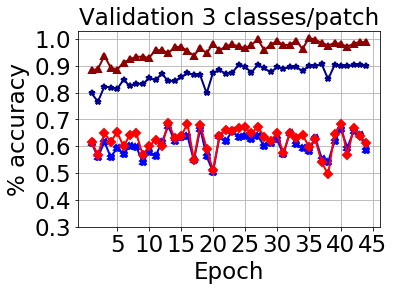

In [86]:
formatter = FuncFormatter(kilo_samples)
lim1 = 1500
a = np.arange(0,lim1,100) # Start at index position 1
lim2 = 11000
b = np.arange(1500,lim2,1000) # Start at index position 1
x = np.concatenate((a, b), axis=0)
a = 0
num = 23
# x = np.arange(0,num,1) # Start at index position 1
plt.rcParams.update({'font.size': 23})
fig2, ax = plt.subplots()
ax.xaxis.set_major_formatter(formatter)

plt.plot(x[a:num],resnet50_plot_1msps[a:num], '-*', c='darkblue',markersize=6, linewidth=2,markerfacecolor='darkblue',markeredgecolor='darkblue',markeredgewidth=2, label='1')
plt.plot(x[a:num],resnet50_plot_5msps[a:num], '-X', c='blue', markersize=6, linewidth=2,markerfacecolor='blue',markeredgecolor='blue',markeredgewidth=2, label='5')
plt.plot(x[a:num],resnet50_plot_10msps[a:num], '-D', c='red', markersize=6, linewidth=2,markerfacecolor='red',markeredgecolor='red',markeredgewidth=2, label='10')
plt.plot(x[a:num],resnet50_plot_25msps[a:num], '-^', c='darkred', markersize=6, linewidth=2,markerfacecolor='darkred',markeredgecolor='darkred',markeredgewidth=2, label='25')
# plt.legend(loc='lower right', fontsize=13)
# Put a legend to the right of the current axis
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Validation: 3 classes/patch', fontsize=23)
plt.xlabel('Batches')
plt.ylabel('% accuracy')
plt.grid()
# plt.minorticks_on()
# plt.yticks(np.arange(.5,1, .1))
# plt.yticks([.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0])
plt.yticks([.3, .4, .5, .6, .7, .8, .9, 1.0])
# plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 10])
plt.xticks([100, 2000,4000, 8500])
# plt.tight_layout()
axes=plt.gca()
# ax.set_aspect('equal')
# axes.set_aspect(10)
plt.subplots_adjust(left=0.15)
plt.subplots_adjust(bottom=0.20)
# fig2.set_size_inches(8.27, 11.69)
fig2.set_size_inches(6.0, 4.0)
fig2.savefig('resnet50_3classes_20220131.pdf', format="pdf")

#### original 3 classes / patch

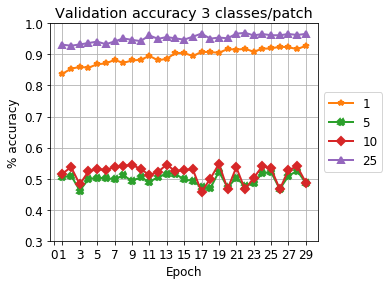

In [58]:
# num = len(resnet50_4D) # reduced rank by 1 for matrix math to work out
num = 30
plt.rcParams.update({'font.size': 12})
x = np.arange(0,num,1) # Start at index position 1
# plt.figure(figsize=(9, 6))

fig2 = plt.figure()
ax = plt.subplot(111)
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# plt.plot(x[0:num],resnet50_total_plot3[:num], '-o', c='#1f77b4',markersize=6, linewidth=2,markerfacecolor='#1f77b4',markeredgecolor='#1f77b4',markeredgewidth=2,label='total')
plt.plot(x[1:num],resnet50_plot_1msps3[1:num], '-*', c='#ff7f0e',markersize=6, linewidth=2,markerfacecolor='#ff7f0e',markeredgecolor='#ff7f0e',markeredgewidth=2, label='1')
plt.plot(x[1:num],resnet50_plot_5msps3[1:num], '-X', c='#2ca02c', markersize=6, linewidth=2,markerfacecolor='#2ca02c',markeredgecolor='#2ca02c',markeredgewidth=2, label='5')
plt.plot(x[1:num],resnet50_plot_10msps3[1:num], '-D', c='#d62728', markersize=6, linewidth=2,markerfacecolor='#d62728',markeredgecolor='#d62728',markeredgewidth=2, label='10')
plt.plot(x[1:num],resnet50_plot_25msps3[1:num], '-^', c='#9467bd', markersize=6, linewidth=2,markerfacecolor='#9467bd',markeredgecolor='#9467bd',markeredgewidth=2, label='25')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.legend(loc='center right')
plt.title('Validation accuracy 3 classes/patch')
plt.xlabel('Epoch')
plt.ylabel('% accuracy')
plt.grid()
# plt.minorticks_on()
# plt.yticks(np.arange(.1,1, .1))
plt.yticks([.3, .4, .5, .6, .7, .8, .9, 1.0])
plt.xticks([0, 1, 3, 5, 7, 9, 11,13,15,17,19,21,23,25,27,29])
fig2.savefig('resnet50_4ch_20211224_3classes.pdf', format="pdf")
plt.show()

## Testing test file combinations

In [59]:
path_test_10msps = "/media/david/Elements/sigMF_ML/RF/10msps_sample_test/" # multiclass testing

In [60]:
path_test_1msps = "/media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps/"

In [61]:
path_test_1msps_compact = "/media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/"
path_test_5msps_compact = "/media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/"
path_test_10msps_compact = "/media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/"
path_test_25msps_compact = "/media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/"

## Combination testing script 20211108

In [62]:
def multiclass_test(folder_meta):
    one_hot_label = np.zeros([12]).astype(int) # creating one hot vector
    i = 0
    for label_list in folder_meta:
        for label_path in label_list:
            with open(str(label_path)) as meta_data:
                metadata = json.load(meta_data)
                label = int(metadata["global"]["core:class"])
#                 print('label = ', label)
            one_hot_label[label] = 1
#     print(one_hot_label)
    return one_hot_label

### Choose 3

In [69]:
N = 10
k = 3
scipy.special.comb(N, k).astype(int)

120

In [70]:
msps = 1
N_choose_K = 3
data_IQ_folder_list_test = sorted(pathlib.Path(path_test_1msps_compact).glob('*/'))
folder_combo = it.combinations(data_IQ_folder_list_test, N_choose_K) # combinations of all folders
combo_tot = scipy.special.comb(10, N_choose_K).astype(int)
i = 0
j= 0
folder_iq = [[],[],[]]
folder_meta = [[],[],[]]
total_ground_truth_count = 0
for x in folder_combo: # start of 1 combination of folders
    print('***************************** Start of combined file test *************************************')
#     print('folders = ', x)
    i = 0
    for y in x: # Cycle through all combinations of data files per particular folder combination
        print('individual folder = ', y)
        folder_iq[i] = sorted(pathlib.Path(y).rglob('*.sigmf-data'))
#         folder_meta[i] = sorted(pathlib.Path(y).rglob('*.sigmf-meta'))
        folder_meta[i] = list(pathlib.Path(y).rglob('*.sigmf-meta'))
        i = i+1
    labels = multiclass_test(folder_meta)
    combo = [y for y in it.product(*folder_iq)]
#     print('combo length = ', len(combo))
    for trial in combo:
        print('Test iteration = ', j)
        j = j+1
        center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
#         data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps)
        results_count = testing_live(center_freq_file, trial, labels, load_net)
        total_ground_truth_count = total_ground_truth_count+results_count
        # testing_file(msps)
        torch.cuda.empty_cache() 
print('*************************************************************************')
print('Total test set percent count = {:.2f}%'.format((total_ground_truth_count/combo_tot)*100))
print('*************************************************************************')      

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/click
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/gd55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/light
Test iteration =  0
GD55
clickndig
GD55
clickndig
light switch
GD55
clickndig
GD55
clickndig
light switch
GD55
clickndig
GD55
clickndig
light switch
GD55
clickndig
GD55
clickndig
light switch
GD55
clickndig
GD55
light switch
GD55
clickndig
GD55
light switch
GD55
clickndig
GD55
clickndig
light switch
GD55
clickndig
GD55
light switch
GD55
clickndig
GD55
light switch
GD55
clickndig
GD55
light switch
GD55
clickndig
GD55
clickndig
light switch
GD55
clickndig
GD55
light switch
GD55
clickndig
GD55
light switch
GD55
clickndig
GD55
TYT
light switch
GD55
clickndig
GD55
TYT
light switch
GD55
clickndig
GD55
TYT
light s

LoRa 250
GD55
LoRa 250
GD55
LoRa 250
GD55
LoRa 250
clickndig
LoRa 250
GD55
LoRa 250
clickndig
GD55
LoRa 250
clickndig
LoRa 250
GD55
LoRa 250
clickndig
GD55
LoRa 250
GD55
LoRa 250
clickndig
LoRa 250
GD55
LoRa 250
clickndig
GD55
LoRa 250
clickndig
GD55
LoRa 250
clickndig
GD55
LoRa 250
GD55
LoRa 250
clickndig
LoRa 250
GD55
LoRa 250
clickndig
LoRa 250
GD55
LoRa 250
clickndig
LoRa 250
GD55
LoRa 250
GD55
GD55
LoRa 250
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/click
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/gd55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/nfm
Test iteration =  3
GD55
clickndig
NFM
GD55
clickndig
NFM
clickndig
GD55
clickndig
NFM
GD55
NFM
clickndig
GD55
clickndig
NFM
clickndig
GD55
clickndig
NFM
GD55
clickndig
NFM
GD55
clickndig
NFM
GD55
cli

clickndig
GD55
Vodeson
clickndig
GD55
Vodeson
clickndig
GD55
Vodeson
clickndig
GD55
Vodeson
clickndig
GD55
clickndig
clickndig
GD55
clickndig
clickndig
GD55
clickndig
clickndig
GD55
Vodeson
clickndig
GD55
Vodeson
clickndig
GD55
Vodeson
clickndig
GD55
Vodeson
clickndig
GD55
Vodeson
GD55
Vodeson
clickndig
GD55
Vodeson
clickndig
GD55
Vodeson
clickndig
GD55
Vodeson
clickndig
GD55
clickndig
clickndig
GD55
clickndig
clickndig
GD55
Vodeson
clickndig
GD55
Vodeson
clickndig
GD55
Vodeson
clickndig
GD55
Vodeson
clickndig
GD55
Vodeson
clickndig
GD55
Vodeson
clickndig
GD55
Vodeson
clickndig
GD55
Vodeson
clickndig
GD55
Vodeson
clickndig
GD55
Vodeson
clickndig
GD55
clickndig
clickndig
GD55
clickndig
clickndig
GD55
TYT
Vodeson
clickndig
GD55
Vodeson
clickndig
GD55
Vodeson
clickndig
GD55
Vodeson
clickndig
GD55
Vodeson
clickndig
GD55
Vodeson
clickndig
GD55
Vodeson
clickndig
GD55
Vodeson
clickndig
GD55
Vodeson
clickndig
GD55
Vodeson
clickndig
GD55
clickndig
clickndig
GD55
clickndig
clickndig
GD55
Vodeson

GD55
TYT
LoRa 250
light switch
GD55
LoRa 250
light switch
GD55
LoRa 250
light switch
GD55
light switch
LoRa 250
light switch
GD55
LoRa 250
light switch
GD55
LoRa 250
light switch
GD55
clickndig
LoRa 250
light switch
GD55
LoRa 250
light switch
GD55
LoRa 250
light switch
GD55
LoRa 250
light switch
GD55
light switch
LoRa 250
light switch
GD55
LoRa 250
light switch
GD55
LoRa 250
light switch
GD55
LoRa 250
light switch
GD55
LoRa 250
light switch
GD55
LoRa 250
light switch
GD55
LoRa 250
light switch
GD55
LoRa 250
light switch
GD55
LoRa 250
light switch
GD55
LoRa 250
light switch
GD55
LoRa 250
light switch
GD55
clickndig
LoRa 250
light switch
GD55
LoRa 250
light switch
GD55
clickndig
LoRa 250
light switch
GD55
LoRa 250
light switch
GD55
LoRa 250
light switch
GD55
clickndig
LoRa 250
light switch
GD55
clickndig
LoRa 250
light switch
GD55
LoRa 250
light switch
GD55
LoRa 250
LoRa 250
light switch
GD55
LoRa 250
light switch
GD55
LoRa 250
light switch
GD55
clickndig
LoRa 250
light switch
GD55
LoRa 

Test iteration =  12
GD55
clickndig
TYT
light switch
GD55
clickndig
TYT
light switch
GD55
clickndig
TYT
light switch
GD55
TYT
light switch
GD55
clickndig
TYT
light switch
GD55
clickndig
TYT
light switch
GD55
clickndig
TYT
light switch
GD55
clickndig
TYT
light switch
GD55
TYT
light switch
GD55
TYT
light switch
GD55
clickndig
TYT
light switch
GD55
clickndig
TYT
light switch
GD55
clickndig
TYT
light switch
GD55
clickndig
TYT
light switch
GD55
TYT
light switch
GD55
clickndig
TYT
light switch
GD55
clickndig
light switch
TYT
light switch
GD55
clickndig
TYT
light switch
GD55
clickndig
TYT
light switch
GD55
TYT
light switch
GD55
clickndig
TYT
light switch
GD55
clickndig
TYT
Sado
light switch
GD55
clickndig
TYT
Sado
light switch
GD55
clickndig
TYT
light switch
GD55
TYT
light switch
GD55
clickndig
TYT
light switch
GD55
clickndig
TYT
light switch
GD55
clickndig
TYT
light switch
GD55
clickndig
TYT
light switch
GD55
TYT
light switch
GD55
TYT
light switch
GD55
clickndig
TYT
Sado
light switch
GD55
cl

NFM
light switch
GD55
clickndig
NFM
light switch
GD55
clickndig
NFM
light switch
YSF
GD55
clickndig
NFM
light switch
GD55
NFM
light switch
GD55
clickndig
NFM
light switch
YSF
GD55
clickndig
NFM
light switch
YSF
GD55
clickndig
NFM
light switch
GD55
clickndig
NFM
TYT
light switch
YSF
GD55
clickndig
NFM
light switch
YSF
GD55
clickndig
NFM
light switch
YSF
GD55
clickndig
NFM
light switch
YSF
GD55
clickndig
NFM
light switch
YSF
GD55
clickndig
NFM
light switch
GD55
clickndig
NFM
light switch
GD55
NFM
light switch
GD55
clickndig
NFM
light switch
YSF
GD55
clickndig
NFM
light switch
GD55
clickndig
NFM
light switch
YSF
GD55
clickndig
NFM
light switch
YSF
GD55
clickndig
NFM
light switch
YSF
GD55
clickndig
NFM
light switch
YSF
GD55
clickndig
NFM
light switch
YSF
GD55
clickndig
NFM
light switch
YSF
GD55
clickndig
NFM
light switch
YSF
GD55
clickndig
NFM
light switch
GD55
clickndig
NFM
light switch
GD55
clickndig
NFM
light switch
GD55
clickndig
NFM
light switch
GD55
clickndig
NFM
light switch
YSF
GD5

LoRa 125
Sado
GD55
clickndig
LoRa 125
Sado
clickndig
LoRa 125
Sado
GD55
LoRa 125
Sado
GD55
LoRa 125
Sado
LoRa 125
TYT
Sado
clickndig
LoRa 125
Sado
LoRa 125
Sado
LoRa 125
Sado
Sado
LoRa 125
Sado
LoRa 125
Sado
LoRa 125
Sado
GD55
clickndig
LoRa 125
Sado
GD55
clickndig
Sado
LoRa 125
Sado
GD55
clickndig
LoRa 125
Sado
GD55
clickndig
LoRa 125
Sado
GD55
clickndig
LoRa 125
Sado
GD55
clickndig
LoRa 125
Sado
GD55
clickndig
LoRa 125
Sado
GD55
clickndig
LoRa 125
Sado
GD55
clickndig
LoRa 125
Sado
GD55
clickndig
LoRa 125
Sado
GD55
clickndig
LoRa 125
Sado
LoRa 125
Sado
GD55
LoRa 125
Sado
Sado
LoRa 125
Sado
LoRa 125
Sado
clickndig
LoRa 125
Sado
LoRa 125
Sado
LoRa 125
Sado
GD55
LoRa 125
Sado
clickndig
Sado
LoRa 125
Sado
clickndig
Sado
LoRa 125
Sado
GD55
clickndig
LoRa 125
Sado
GD55
clickndig
Sado
LoRa 125
Sado
GD55
clickndig
LoRa 125
Sado
GD55
clickndig
LoRa 125
Sado
GD55
clickndig
Sado
LoRa 125
Sado
GD55
clickndig
LoRa 125
TYT
Sado
GD55
clickndig
LoRa 125
Sado
Sado
LoRa 125
Sado
LoRa 125
Sado
LoRa 125


LoRa 125
NFM
GD55
clickndig
LoRa 125
NFM
GD55
clickndig
LoRa 125
NFM
GD55
clickndig
LoRa 125
NFM
GD55
clickndig
LoRa 125
NFM
GD55
clickndig
LoRa 125
NFM
YSF
GD55
clickndig
LoRa 125
NFM
GD55
clickndig
LoRa 125
NFM
GD55
clickndig
LoRa 125
NFM
GD55
clickndig
LoRa 125
NFM
YSF
GD55
clickndig
LoRa 125
NFM
YSF
GD55
clickndig
LoRa 125
NFM
GD55
clickndig
LoRa 125
NFM
GD55
clickndig
LoRa 125
NFM
GD55
clickndig
LoRa 125
NFM
GD55
clickndig
LoRa 125
NFM
GD55
clickndig
LoRa 125
NFM
YSF
GD55
clickndig
LoRa 125
NFM
GD55
clickndig
LoRa 125
NFM
YSF
GD55
clickndig
LoRa 125
NFM
GD55
clickndig
LoRa 125
NFM
GD55
clickndig
LoRa 125
NFM
YSF
GD55
clickndig
LoRa 125
NFM
YSF
GD55
LoRa 125
NFM
GD55
clickndig
LoRa 125
NFM
GD55
clickndig
LoRa 125
NFM
GD55
clickndig
LoRa 125
NFM
GD55
clickndig
LoRa 125
NFM
YSF
GD55
clickndig
LoRa 125
NFM
GD55
clickndig
LoRa 125
NFM
GD55
clickndig
LoRa 125
NFM
GD55
clickndig
LoRa 125
NFM
GD55
clickndig
LoRa 125
NFM
GD55
clickndig
LoRa 125
NFM
GD55
clickndig
LoRa 125
NFM
GD55
clickndi

GD55
clickndig
LoRa 250
Vodeson
LoRa 250
LoRa 250
Vodeson
LoRa 250
clickndig
LoRa 250
Vodeson
LoRa 250
Vodeson
LoRa 250
Vodeson
LoRa 250
GD55
clickndig
LoRa 250
clickndig
LoRa 250
LoRa 250
clickndig
LoRa 250
clickndig
Vodeson
LoRa 250
LoRa 250
Vodeson
LoRa 250
Vodeson
LoRa 250
GD55
clickndig
Vodeson
LoRa 250
Vodeson
LoRa 250
GD55
Vodeson
Sado
LoRa 250
LoRa 250
Vodeson
LoRa 250
clickndig
LoRa 250
Vodeson
LoRa 250
clickndig
Vodeson
LoRa 250
clickndig
LoRa 250
GD55
clickndig
LoRa 250
LoRa 250
LoRa 250
LoRa 250
Vodeson
LoRa 250
clickndig
LoRa 250
Vodeson
LoRa 250
GD55
clickndig
Vodeson
LoRa 250
clickndig
Vodeson
LoRa 250
clickndig
Vodeson
LoRa 250
LoRa 250
Vodeson
LoRa 250
clickndig
LoRa 250
Vodeson
LoRa 250
GD55
Vodeson
LoRa 250
clickndig
Vodeson
LoRa 250
clickndig
LoRa 250
LoRa 250
LoRa 250
LoRa 250
LoRa 250
GD55
Vodeson
LoRa 250
clickndig
Vodeson
LoRa 250
LoRa 250
Vodeson
LoRa 250
Vodeson
LoRa 250
clickndig
LoRa 250
Vodeson
LoRa 250
clickndig
Vodeson
LoRa 250
clickndig
LoRa 250
Vodeson


GD55
clickndig
NFM
TYT
GD55
clickndig
NFM
TYT
GD55
clickndig
NFM
TYT
clickndig
GD55
clickndig
NFM
GD55
clickndig
NFM
TYT
GD55
clickndig
NFM
TYT
GD55
clickndig
NFM
TYT
GD55
clickndig
NFM
TYT
GD55
clickndig
NFM
TYT
GD55
clickndig
NFM
clickndig
GD55
clickndig
NFM
TYT
GD55
clickndig
NFM
TYT
GD55
clickndig
NFM
TYT
GD55
clickndig
NFM
TYT
GD55
clickndig
NFM
TYT
GD55
clickndig
NFM
TYT
GD55
clickndig
NFM
TYT
GD55
clickndig
NFM
TYT
GD55
clickndig
NFM
TYT
GD55
clickndig
NFM
TYT
GD55
clickndig
NFM
TYT
clickndig
GD55
clickndig
NFM
TYT
GD55
clickndig
NFM
TYT
GD55
clickndig
NFM
TYT
GD55
clickndig
NFM
TYT
GD55
clickndig
NFM
TYT
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/click
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/nfm
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/v

Sado
clickndig
Vodeson
Sado
clickndig
Vodeson
Sado
Sado
Vodeson
Sado
clickndig
Sado
Sado
Sado
Vodeson
Sado
Vodeson
Sado
Vodeson
Sado
Vodeson
Sado
Vodeson
Sado
Vodeson
Sado
Vodeson
Sado
Sado
Vodeson
Sado
Vodeson
Sado
Sado
clickndig
Sado
clickndig
Sado
clickndig
Vodeson
Sado
clickndig
Vodeson
Sado
clickndig
Vodeson
Sado
clickndig
Vodeson
Sado
clickndig
Vodeson
Sado
Vodeson
Sado
clickndig
Vodeson
Sado
clickndig
Vodeson
Sado
clickndig
Vodeson
Sado
Sado
Sado
Sado
Sado
Vodeson
Sado
Vodeson
Sado
Vodeson
Sado
Vodeson
Sado
Vodeson
Sado
Vodeson
Sado
Vodeson
Sado
clickndig
Vodeson
Sado
clickndig
Vodeson
Sado
clickndig
Sado
clickndig
Sado
clickndig
Vodeson
Sado
clickndig
Vodeson
Sado
clickndig
Vodeson
Sado
clickndig
Vodeson
Sado
clickndig
Vodeson
Sado
clickndig
Vodeson
Sado
clickndig
Sado
Vodeson
Sado
Vodeson
Sado
Vodeson
Sado
Sado
Sado
Vodeson
Sado
Vodeson
Sado
Vodeson
Sado
Sado
Vodeson
Sado
clickndig
Vodeson
Sado
clickndig
Vodeson
Sado
clickndig
Sado
Sado
clickndig
Sado
clickndig
Sado
clickndig


GD55
clickndig
NFM
Vodeson
GD55
clickndig
NFM
Vodeson
GD55
clickndig
NFM
Vodeson
GD55
NFM
Vodeson
GD55
clickndig
NFM
Vodeson
GD55
clickndig
NFM
Vodeson
GD55
clickndig
NFM
Vodeson
GD55
clickndig
NFM
Vodeson
GD55
clickndig
NFM
Vodeson
GD55
clickndig
NFM
YSF
GD55
clickndig
NFM
YSF
GD55
clickndig
NFM
Vodeson
GD55
clickndig
NFM
Vodeson
GD55
clickndig
NFM
Vodeson
GD55
clickndig
NFM
Vodeson
GD55
clickndig
NFM
Vodeson
GD55
clickndig
NFM
Vodeson
GD55
clickndig
NFM
Vodeson
GD55
clickndig
NFM
Vodeson
GD55
clickndig
NFM
Vodeson
GD55
clickndig
NFM
YSF
GD55
clickndig
NFM
YSF
GD55
clickndig
NFM
clickndig
YSF
GD55
clickndig
NFM
Vodeson
YSF
GD55
clickndig
NFM
Vodeson
GD55
clickndig
NFM
Vodeson
GD55
clickndig
NFM
Vodeson
GD55
clickndig
NFM
Vodeson
GD55
clickndig
NFM
Vodeson
GD55
clickndig
NFM
Vodeson
GD55
clickndig
NFM
Vodeson
GD55
clickndig
NFM
Vodeson
GD55
clickndig
NFM
YSF
GD55
clickndig
NFM
YSF
GD55
clickndig
NFM
Vodeson
YSF
GD55
clickndig
NFM
Vodeson
GD55
clickndig
NFM
Vodeson
GD55
clickndig
NFM
Vo

GD55
LoRa 250
light switch
GD55
GD55
LoRa 250
light switch
GD55
GD55
LoRa 250
light switch
GD55
GD55
LoRa 250
light switch
GD55
GD55
LoRa 250
light switch
GD55
GD55
LoRa 250
light switch
GD55
GD55
LoRa 250
light switch
GD55
GD55
LoRa 250
light switch
GD55
GD55
LoRa 250
light switch
GD55
GD55
LoRa 250
light switch
GD55
GD55
LoRa 250
light switch
GD55
GD55
LoRa 250
light switch
GD55
GD55
LoRa 250
light switch
GD55
GD55
LoRa 250
light switch
GD55
GD55
LoRa 250
light switch
GD55
GD55
LoRa 250
light switch
GD55
GD55
LoRa 250
light switch
GD55
GD55
LoRa 250
light switch
GD55
LoRa 250
GD55
LoRa 250
light switch
GD55
LoRa 250
GD55
LoRa 250
light switch
GD55
GD55
LoRa 250
light switch
GD55
GD55
LoRa 250
light switch
GD55
GD55
LoRa 250
light switch
GD55
GD55
LoRa 250
light switch
GD55
LoRa 250
GD55
LoRa 250
light switch
GD55
GD55
LoRa 250
light switch
GD55
GD55
LoRa 250
light switch
GD55
GD55
LoRa 250
light switch
GD55
light switch
GD55
LoRa 250
light switch
GD55
light switch
GD55
LoRa 250
light

GD55
light switch
GD55
TYT
light switch
GD55
light switch
GD55
TYT
light switch
GD55
light switch
GD55
TYT
light switch
GD55
light switch
GD55
TYT
light switch
GD55
light switch
GD55
TYT
light switch
GD55
light switch
GD55
TYT
light switch
GD55
light switch
GD55
TYT
light switch
GD55
light switch
GD55
TYT
light switch
GD55
light switch
GD55
NFM
TYT
light switch
GD55
light switch
GD55
TYT
light switch
GD55
light switch
GD55
TYT
light switch
GD55
light switch
GD55
TYT
light switch
GD55
light switch
GD55
TYT
light switch
GD55
GD55
TYT
light switch
GD55
light switch
GD55
TYT
light switch
GD55
light switch
GD55
TYT
light switch
GD55
light switch
GD55
TYT
light switch
GD55
light switch
GD55
TYT
light switch
GD55
light switch
GD55
TYT
light switch
GD55
light switch
GD55
TYT
light switch
GD55
light switch
GD55
TYT
light switch
GD55
light switch
GD55
TYT
light switch
GD55
light switch
GD55
TYT
light switch
GD55
light switch
GD55
TYT
light switch
GD55
GD55
TYT
light switch
GD55
light switch
GD55

NFM
light switch
YSF
GD55
light switch
NFM
light switch
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/gd55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/lora125
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/lora250
Test iteration =  43
LoRa 250
LoRa 125
GD55
LoRa 250
GD55
LoRa 125
GD55
LoRa 250
GD55
LoRa 250
LoRa 125
GD55
LoRa 250
LoRa 125
GD55
LoRa 250
LoRa 125
GD55
LoRa 250
LoRa 250
LoRa 125
GD55
LoRa 250
LoRa 250
LoRa 125
GD55
LoRa 250
LoRa 250
LoRa 125
GD55
LoRa 250
LoRa 125
GD55
LoRa 250
LoRa 250
LoRa 125
GD55
LoRa 250
LoRa 250
LoRa 125
GD55
LoRa 250
LoRa 250
LoRa 125
GD55
LoRa 250
LoRa 250
LoRa 125
GD55
LoRa 250
LoRa 125
GD55
LoRa 250
GD55
LoRa 125
GD55
LoRa 250
LoRa 250
LoRa 125
GD55
LoRa 250
LoRa 250
LoRa 125
GD55
LoRa 250
LoRa 250
LoRa 125
GD55
LoRa 

GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
GD55
TYT
GD55
LoRa 125
G

GD55
LoRa 250
LoRa 250
GD55
NFM
LoRa 250
LoRa 250
GD55
NFM
LoRa 250
GD55
LoRa 250
GD55
LoRa 250
GD55
NFM
LoRa 250
GD55
NFM
LoRa 250
LoRa 250
GD55
LoRa 250
LoRa 250
GD55
LoRa 250
LoRa 250
GD55
LoRa 250
GD55
GD55
LoRa 250
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/gd55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/lora250
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/sado
Test iteration =  50
LoRa 250
GD55
LoRa 250
GD55
Sado
LoRa 250
GD55
LoRa 250
Sado
GD55
LoRa 250
GD55
Sado
LoRa 250
Sado
GD55
Sado
LoRa 250
Sado
GD55
Sado
LoRa 250
Sado
GD55
LoRa 250
GD55
LoRa 250
GD55
GD55
LoRa 250
LoRa 250
GD55
LoRa 250
LoRa 250
GD55
LoRa 250
LoRa 250
GD55
LoRa 250
Sado
GD55
Sado
LoRa 250
GD55
LoRa 250
Sado
GD55
Sado
LoRa 250
Sado
LoRa 250
GD55
LoRa 250
Sado
LoRa 250
GD55


NFM
LoRa 250
YSF
LoRa 250
NFM
LoRa 250
YSF
LoRa 250
NFM
LoRa 250
YSF
NFM
TYT
LoRa 250
LoRa 250
NFM
LoRa 250
YSF
LoRa 250
NFM
LoRa 250
YSF
LoRa 250
NFM
LoRa 250
YSF
LoRa 250
NFM
LoRa 250
YSF
NFM
TYT
LoRa 250
YSF
LoRa 250
NFM
LoRa 250
YSF
GD55
LoRa 250
GD55
NFM
LoRa 250
YSF
GD55
LoRa 250
NFM
LoRa 250
YSF
LoRa 250
TYT
LoRa 250
YSF
GD55
NFM
LoRa 250
YSF
LoRa 250
NFM
LoRa 250
LoRa 250
NFM
LoRa 250
YSF
LoRa 250
GD55
NFM
LoRa 250
NFM
LoRa 250
YSF
NFM
LoRa 250
LoRa 250
GD55
NFM
LoRa 250
LoRa 250
NFM
LoRa 250
LoRa 250
NFM
LoRa 250
YSF
GD55
GD55
NFM
LoRa 250
GD55
GD55
NFM
LoRa 250
YSF
GD55
LoRa 250
GD55
NFM
LoRa 250
LoRa 250
NFM
LoRa 250
YSF
LoRa 250
NFM
LoRa 250
YSF
GD55
NFM
LoRa 250
YSF
NFM
LoRa 250
YSF
LoRa 250
NFM
LoRa 250
YSF
GD55
LoRa 250
NFM
LoRa 250
YSF
LoRa 250
NFM
LoRa 250
YSF
GD55
NFM
LoRa 250
YSF
LoRa 250
NFM
LoRa 250
YSF
LoRa 250
GD55
NFM
LoRa 250
GD55
LoRa 250
NFM
LoRa 250
LoRa 250
NFM
LoRa 250
YSF
GD55
NFM
TYT
LoRa 250
YSF
LoRa 250
GD55
NFM
TYT
LoRa 250
LoRa 250
NFM
LoRa 250
LoRa 

Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado
Sado
GD55
TYT
Sado

NFM
YSF
GD55
NFM
GD55
NFM
GD55
NFM
GD55
NFM
YSF
GD55
NFM
GD55
NFM
GD55
NFM
GD55
NFM
YSF
GD55
NFM
GD55
NFM
GD55
NFM
YSF
GD55
NFM
YSF
GD55
NFM
GD55
NFM
GD55
NFM
GD55
NFM
GD55
NFM
GD55
NFM
GD55
NFM
YSF
GD55
NFM
GD55
NFM
YSF
GD55
NFM
GD55
NFM
GD55
NFM
GD55
NFM
YSF
GD55
NFM
GD55
NFM
GD55
NFM
GD55
NFM
GD55
NFM
YSF
GD55
NFM
YSF
GD55
NFM
GD55
NFM
GD55
NFM
YSF
GD55
NFM
GD55
NFM
GD55
NFM
GD55
NFM
GD55
NFM
GD55
NFM
GD55
NFM
YSF
GD55
NFM
YSF
GD55
NFM
GD55
NFM
YSF
GD55
NFM
GD55
NFM
YSF
GD55
NFM
GD55
NFM
GD55
NFM
GD55
NFM
GD55
NFM
GD55
NFM
GD55
NFM
YSF
GD55
NFM
YSF
GD55
NFM
YSF
GD55
NFM
YSF
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/gd55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/vod
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/ysf
Test iteration =  63
GD55
NFM
Vode

GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
l

LoRa 125
TYT
light switch
GD55
light switch
LoRa 125
TYT
light switch
GD55
light switch
LoRa 125
TYT
light switch
GD55
light switch
LoRa 125
TYT
light switch
GD55
light switch
LoRa 125
TYT
light switch
GD55
light switch
LoRa 125
TYT
light switch
GD55
light switch
LoRa 125
TYT
light switch
GD55
light switch
LoRa 125
TYT
light switch
GD55
light switch
LoRa 125
TYT
light switch
GD55
light switch
LoRa 125
TYT
light switch
GD55
light switch
LoRa 125
TYT
light switch
GD55
light switch
LoRa 125
TYT
light switch
GD55
light switch
LoRa 125
TYT
light switch
GD55
light switch
LoRa 125
TYT
light switch
GD55
light switch
LoRa 125
TYT
light switch
GD55
light switch
LoRa 125
TYT
light switch
GD55
light switch
LoRa 125
TYT
light switch
GD55
light switch
LoRa 125
TYT
light switch
GD55
light switch
LoRa 125
TYT
light switch
GD55
light switch
LoRa 125
TYT
light switch
GD55
light switch
LoRa 125
TYT
light switch
GD55
light switch
LoRa 125
TYT
light switch
GD55
light switch
LoRa 125
TYT
light switch
GD55
l

LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
light switch
LoRa 125
NFM
light switch
GD55
l

GD55
Sado
Sado
LoRa 250
light switch
GD55
Sado
LoRa 250
light switch
GD55
Sado
Sado
LoRa 250
light switch
GD55
Sado
LoRa 250
light switch
GD55
Sado
Sado
LoRa 250
light switch
GD55
Sado
light switch
Sado
LoRa 250
light switch
GD55
Sado
LoRa 250
light switch
GD55
Sado
LoRa 250
light switch
GD55
Sado
light switch
Sado
LoRa 250
light switch
GD55
Sado
LoRa 250
light switch
GD55
Sado
LoRa 250
light switch
GD55
Sado
Sado
LoRa 250
light switch
GD55
Sado
Sado
LoRa 250
light switch
GD55
LoRa 250
Sado
LoRa 250
light switch
GD55
Sado
Sado
LoRa 250
light switch
GD55
Sado
LoRa 250
light switch
GD55
Sado
Sado
LoRa 250
light switch
GD55
Sado
LoRa 250
light switch
GD55
Sado
Sado
LoRa 250
light switch
GD55
light switch
Sado
LoRa 250
light switch
GD55
Sado
Sado
LoRa 250
light switch
GD55
light switch
Sado
LoRa 250
light switch
GD55
Sado
light switch
Sado
LoRa 250
light switch
GD55
light switch
Sado
LoRa 250
light switch
GD55
Sado
LoRa 250
light switch
GD55
Sado
Sado
LoRa 250
light switch
GD55
Sado
LoRa 2

LoRa 250
light switch
GD55
LoRa 250
light switch
GD55
LoRa 250
light switch
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/light
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/lora250
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/ysf
Test iteration =  74
NFM
LoRa 250
light switch
YSF
GD55
light switch
NFM
LoRa 250
light switch
YSF
GD55
light switch
NFM
LoRa 250
light switch
YSF
GD55
light switch
NFM
LoRa 250
light switch
YSF
GD55
NFM
LoRa 250
light switch
YSF
light switch
NFM
LoRa 250
light switch
YSF
light switch
NFM
LoRa 250
light switch
YSF
light switch
NFM
LoRa 250
light switch
YSF
GD55
light switch
NFM
LoRa 250
light switch
YSF
GD55
light switch
NFM
LoRa 250
light switch
YSF
light switch
NFM
LoRa 250
light switch
YSF
LoRa 250
NFM
LoRa 250
light switch
YSF


GD55
light switch
NFM
TYT
light switch
GD55
light switch
NFM
TYT
light switch
GD55
light switch
NFM
TYT
light switch
GD55
light switch
NFM
TYT
light switch
GD55
light switch
NFM
TYT
light switch
GD55
light switch
NFM
TYT
light switch
GD55
light switch
NFM
light switch
GD55
light switch
NFM
TYT
light switch
GD55
light switch
NFM
TYT
light switch
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
GD55
light switch
NFM
TYT
light switch
GD55
light switch
NFM
TYT
light switch
GD55
light switch
NFM
TYT
light switch
GD55
light switch
NFM
TYT
light switch
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
GD55
light switch
NFM
TYT
light switch
GD55
light switch
NFM
TYT
light switch
GD55
light switch
NFM
TYT
light switch
GD55
light switch
NFM
TYT
light switch
GD55
light switch
NFM
TYT
light switch
GD55
light switch
NFM
TYT
light switch
GD55
light switch
NFM
light switch
GD55
light switch
NFM
TYT
light switch
GD55
light swi

GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
GD55
light switch
NFM
TYT
light switch
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
YSF
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
GD55
light s

Sado
Vodeson
Sado
light switch
GD55
Sado
Sado
light switch
GD55
Sado
Sado
light switch
GD55
Sado
Sado
light switch
GD55
Sado
Sado
light switch
GD55
Sado
Sado
light switch
GD55
Sado
Sado
light switch
GD55
Sado
Sado
light switch
GD55
Sado
Sado
light switch
GD55
Sado
Sado
light switch
GD55
Sado
Sado
light switch
GD55
Sado
Sado
light switch
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/light
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/sado
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/ysf
Test iteration =  81
GD55
Sado
NFM
light switch
GD55
Sado
NFM
Sado
light switch
GD55
Sado
NFM
Sado
light switch
YSF
GD55
Sado
NFM
light switch
GD55
Sado
NFM
Sado
light switch
YSF
GD55
Sado
NFM
Sado
light switch
GD55
Sado
light switch
NFM
Sado
light switch
YSF
GD55
Sado
NFM
Sad

light switch
GD55
light switch
NFM
light switch
YSF
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
YSF
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
YSF
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
YSF
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
YSF
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
YSF
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
YSF
GD55
light switch
NFM
light switch
YSF
GD55
light switch
NFM
light switch
YSF
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
GD55
light switch
NFM
light switch
YSF
GD55
light switch
NFM
light switch
GD

GD55
LoRa 250
LoRa 125
NFM
LoRa 250
GD55
LoRa 125
NFM
LoRa 250
GD55
LoRa 125
NFM
LoRa 250
GD55
LoRa 250
LoRa 125
NFM
LoRa 250
GD55
LoRa 250
LoRa 125
NFM
LoRa 250
GD55
LoRa 250
LoRa 125
NFM
LoRa 250
GD55
LoRa 125
NFM
LoRa 250
GD55
LoRa 125
NFM
LoRa 250
GD55
LoRa 250
LoRa 125
NFM
LoRa 250
GD55
LoRa 250
LoRa 125
NFM
LoRa 250
GD55
LoRa 250
LoRa 125
NFM
LoRa 250
GD55
LoRa 125
NFM
LoRa 250
GD55
LoRa 125
NFM
LoRa 250
GD55
LoRa 250
LoRa 125
NFM
LoRa 250
GD55
LoRa 250
LoRa 125
NFM
LoRa 250
GD55
LoRa 250
LoRa 125
NFM
LoRa 250
GD55
LoRa 125
NFM
LoRa 250
GD55
LoRa 125
NFM
LoRa 250
GD55
LoRa 250
LoRa 125
NFM
LoRa 250
GD55
LoRa 250
LoRa 125
NFM
LoRa 250
GD55
LoRa 125
NFM
LoRa 250
GD55
LoRa 125
NFM
LoRa 250
GD55
LoRa 125
NFM
LoRa 250
GD55
LoRa 250
LoRa 125
NFM
LoRa 250
GD55
LoRa 250
LoRa 125
NFM
LoRa 250
GD55
LoRa 250
LoRa 125
NFM
LoRa 250
GD55
LoRa 125
NFM
LoRa 250
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elemen

LoRa 125
LoRa 250
GD55
LoRa 125
Vodeson
LoRa 250
LoRa 250
LoRa 125
Vodeson
LoRa 250
GD55
LoRa 250
LoRa 125
Vodeson
LoRa 250
GD55
LoRa 250
LoRa 125
LoRa 250
LoRa 250
LoRa 125
Vodeson
LoRa 250
LoRa 125
LoRa 250
LoRa 250
LoRa 125
LoRa 250
LoRa 250
LoRa 125
LoRa 250
LoRa 250
LoRa 125
Vodeson
LoRa 250
LoRa 250
LoRa 125
LoRa 250
LoRa 125
LoRa 250
LoRa 250
LoRa 125
LoRa 250
LoRa 250
LoRa 125
Vodeson
LoRa 250
LoRa 250
LoRa 125
Vodeson
LoRa 250
LoRa 250
LoRa 125
Vodeson
LoRa 250
GD55
LoRa 125
Vodeson
LoRa 250
GD55
LoRa 250
LoRa 125
Vodeson
LoRa 250
LoRa 250
LoRa 125
Vodeson
LoRa 250
LoRa 250
LoRa 125
LoRa 250
LoRa 125
Vodeson
LoRa 250
GD55
LoRa 125
LoRa 250
GD55
LoRa 250
LoRa 125
LoRa 250
LoRa 250
LoRa 125
LoRa 250
LoRa 250
LoRa 125
LoRa 250
LoRa 125
Vodeson
LoRa 250
LoRa 125
Vodeson
LoRa 250
LoRa 250
LoRa 125
Vodeson
LoRa 250
GD55
LoRa 250
LoRa 125
LoRa 250
GD55
LoRa 250
LoRa 125
Vodeson
LoRa 250
LoRa 125
LoRa 250
GD55
LoRa 125
LoRa 250
LoRa 250
LoRa 125
LoRa 250
GD55
LoRa 250
LoRa 125
LoRa 25

GD55
LoRa 125
NFM
GD55
LoRa 125
NFM
TYT
GD55
LoRa 125
NFM
GD55
LoRa 125
NFM
TYT
GD55
LoRa 125
NFM
TYT
GD55
LoRa 125
NFM
TYT
GD55
LoRa 125
NFM
TYT
GD55
LoRa 125
NFM
TYT
GD55
LoRa 125
NFM
GD55
LoRa 125
NFM
TYT
GD55
LoRa 125
NFM
GD55
LoRa 125
NFM
TYT
GD55
LoRa 125
NFM
TYT
GD55
LoRa 125
NFM
TYT
GD55
LoRa 125
NFM
TYT
GD55
LoRa 125
NFM
TYT
GD55
LoRa 125
NFM
GD55
LoRa 125
NFM
TYT
GD55
LoRa 125
NFM
TYT
GD55
LoRa 125
NFM
TYT
GD55
LoRa 125
NFM
GD55
LoRa 125
NFM
GD55
LoRa 125
NFM
GD55
LoRa 125
NFM
TYT
GD55
LoRa 125
NFM
GD55
LoRa 125
NFM
TYT
GD55
LoRa 125
NFM
TYT
GD55
LoRa 125
NFM
TYT
GD55
LoRa 125
NFM
TYT
GD55
LoRa 125
NFM
TYT
GD55
LoRa 125
NFM
GD55
LoRa 125
NFM
TYT
GD55
LoRa 125
NFM
GD55
LoRa 125
NFM
TYT
GD55
LoRa 125
NFM
TYT
GD55
LoRa 125
NFM
TYT
GD55
LoRa 125
NFM
TYT
GD55
LoRa 125
NFM
TYT
GD55
LoRa 125
NFM
TYT
GD55
LoRa 125
NFM
TYT
GD55
LoRa 125
NFM
TYT
GD55
LoRa 125
NFM
GD55
LoRa 125
NFM
TYT
GD55
LoRa 125
NFM
TYT
GD55
LoRa 125
NFM
GD55
LoRa 125
NFM
TYT
GD55
LoRa 125
NFM
**********************

Sado
LoRa 125
Vodeson
Sado
Sado
LoRa 125
Vodeson
Sado
Sado
LoRa 125
Vodeson
Sado
Sado
LoRa 125
Vodeson
Sado
Sado
LoRa 125
Sado
Sado
LoRa 125
Sado
Sado
LoRa 125
Sado
Sado
LoRa 125
Sado
Sado
LoRa 125
Vodeson
Sado
Sado
LoRa 125
Vodeson
Sado
Sado
LoRa 125
Vodeson
Sado
Sado
LoRa 125
Vodeson
Sado
Sado
LoRa 125
Vodeson
Sado
Sado
LoRa 125
Vodeson
Sado
Sado
LoRa 125
Vodeson
Sado
Sado
LoRa 125
Vodeson
Sado
Sado
LoRa 125
Sado
Sado
LoRa 125
Sado
Sado
LoRa 125
Sado
Sado
LoRa 125
Sado
Sado
LoRa 125
Vodeson
Sado
Sado
LoRa 125
Vodeson
Sado
Sado
LoRa 125
Sado
Sado
LoRa 125
Vodeson
Sado
Sado
LoRa 125
Vodeson
Sado
Sado
LoRa 125
Vodeson
Sado
Sado
LoRa 125
Vodeson
Sado
Sado
LoRa 125
Vodeson
Sado
Sado
LoRa 125
Sado
Sado
LoRa 125
Sado
Sado
LoRa 125
Sado
Sado
LoRa 125
Vodeson
Sado
Sado
LoRa 125
Vodeson
Sado
Sado
LoRa 125
Vodeson
Sado
Sado
LoRa 125
Vodeson
Sado
Sado
LoRa 125
Vodeson
Sado
Sado
LoRa 125
Vodeson
Sado
Sado
LoRa 125
Vodeson
Sado
Sado
LoRa 125
Vodeson
Sado
Sado
LoRa 125
Vodeson
Sado
Sado
LoRa 125
Sa

GD55
LoRa 125
NFM
GD55
LoRa 125
NFM
Vodeson
GD55
LoRa 125
NFM
Vodeson
GD55
LoRa 125
NFM
Vodeson
GD55
LoRa 125
NFM
Vodeson
GD55
LoRa 125
NFM
Vodeson
GD55
LoRa 125
NFM
Vodeson
GD55
LoRa 125
NFM
GD55
LoRa 125
NFM
GD55
LoRa 125
NFM
YSF
GD55
LoRa 125
NFM
GD55
LoRa 125
NFM
GD55
LoRa 125
NFM
GD55
LoRa 125
NFM
Vodeson
GD55
LoRa 125
NFM
GD55
LoRa 125
NFM
Vodeson
GD55
LoRa 125
NFM
Vodeson
GD55
LoRa 125
NFM
GD55
LoRa 125
NFM
Vodeson
GD55
LoRa 125
NFM
Vodeson
GD55
LoRa 125
NFM
GD55
LoRa 125
NFM
GD55
LoRa 125
NFM
YSF
GD55
LoRa 125
NFM
GD55
LoRa 125
NFM
Vodeson
GD55
LoRa 125
NFM
Vodeson
GD55
LoRa 125
NFM
GD55
LoRa 125
NFM
Vodeson
GD55
LoRa 125
NFM
Vodeson
GD55
LoRa 125
NFM
Vodeson
GD55
LoRa 125
NFM
Vodeson
GD55
LoRa 125
NFM
Vodeson
GD55
LoRa 125
NFM
GD55
LoRa 125
NFM
GD55
LoRa 125
NFM
GD55
LoRa 125
NFM
GD55
LoRa 125
NFM
Vodeson
GD55
LoRa 125
NFM
Vodeson
GD55
LoRa 125
NFM
Sado
GD55
LoRa 125
NFM
Vodeson
GD55
LoRa 125
NFM
GD55
LoRa 125
NFM
GD55
LoRa 125
NFM
Vodeson
GD55
LoRa 125
NFM
Vodeson
GD55
LoRa 1

LoRa 250
NFM
Vodeson
LoRa 250
GD55
LoRa 250
NFM
Vodeson
LoRa 250
GD55
NFM
Vodeson
LoRa 250
GD55
LoRa 250
NFM
Vodeson
LoRa 250
LoRa 250
NFM
Vodeson
LoRa 250
LoRa 250
NFM
Vodeson
LoRa 250
NFM
Vodeson
LoRa 250
GD55
NFM
LoRa 250
LoRa 250
NFM
LoRa 250
LoRa 250
NFM
LoRa 250
LoRa 250
NFM
Vodeson
LoRa 250
NFM
Vodeson
LoRa 250
NFM
Vodeson
LoRa 250
LoRa 250
NFM
Vodeson
LoRa 250
GD55
LoRa 250
NFM
Vodeson
LoRa 250
GD55
LoRa 250
NFM
Vodeson
LoRa 250
NFM
LoRa 250
GD55
NFM
LoRa 250
LoRa 250
NFM
LoRa 250
LoRa 250
NFM
LoRa 250
GD55
LoRa 250
NFM
LoRa 250
NFM
LoRa 250
NFM
LoRa 250
LoRa 250
NFM
LoRa 250
LoRa 250
NFM
LoRa 250
LoRa 250
NFM
LoRa 250
GD55
NFM
LoRa 250
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/lora250
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/nfm
individual folder =  /media/david/Elements/sigMF_ML/RF/RF

NFM
LoRa 250
YSF
NFM
LoRa 250
YSF
NFM
LoRa 250
YSF
NFM
LoRa 250
YSF
NFM
LoRa 250
YSF
Sado
NFM
LoRa 250
YSF
NFM
Sado
LoRa 250
YSF
Sado
NFM
LoRa 250
YSF
NFM
LoRa 250
YSF
GD55
NFM
LoRa 250
YSF
LoRa 250
NFM
LoRa 250
YSF
LoRa 250
NFM
LoRa 250
YSF
NFM
LoRa 250
YSF
Sado
NFM
LoRa 250
YSF
NFM
LoRa 250
YSF
Sado
NFM
Sado
LoRa 250
YSF
LoRa 250
NFM
LoRa 250
YSF
NFM
Sado
LoRa 250
YSF
Sado
NFM
LoRa 250
YSF
Sado
NFM
LoRa 250
YSF
NFM
LoRa 250
YSF
NFM
LoRa 250
YSF
NFM
LoRa 250
YSF
Sado
NFM
LoRa 250
YSF
NFM
LoRa 250
YSF
Sado
NFM
LoRa 250
YSF
NFM
LoRa 250
YSF
NFM
LoRa 250
YSF
LoRa 250
YSF
Sado
NFM
LoRa 250
YSF
NFM
LoRa 250
YSF
Sado
NFM
LoRa 250
YSF
NFM
LoRa 250
YSF
NFM
LoRa 250
YSF
NFM
LoRa 250
YSF
NFM
LoRa 250
YSF
NFM
LoRa 250
YSF
NFM
LoRa 250
YSF
Sado
NFM
LoRa 250
YSF
NFM
LoRa 250
YSF
NFM
LoRa 250
YSF
Sado
NFM
LoRa 250
YSF
NFM
LoRa 250
YSF
NFM
LoRa 250
YSF
NFM
LoRa 250
YSF
NFM
LoRa 250
YSF
NFM
LoRa 250
YSF
Sado
NFM
Sado
LoRa 250
YSF
NFM
LoRa 250
YSF
Sado
NFM
LoRa 250
YSF
NFM
LoRa 250
YSF
NFM
LoRa 250
YS

LoRa 250
NFM
Vodeson
LoRa 250
YSF
NFM
LoRa 250
YSF
NFM
LoRa 250
YSF
LoRa 250
NFM
LoRa 250
YSF
LoRa 250
Vodeson
LoRa 250
LoRa 250
NFM
Vodeson
LoRa 250
GD55
NFM
Vodeson
LoRa 250
YSF
GD55
Vodeson
LoRa 250
YSF
GD55
NFM
Vodeson
LoRa 250
YSF
LoRa 250
NFM
Vodeson
LoRa 250
LoRa 250
NFM
Vodeson
LoRa 250
GD55
Vodeson
LoRa 250
YSF
LoRa 250
Vodeson
LoRa 250
YSF
LoRa 250
NFM
LoRa 250
YSF
GD55
LoRa 250
NFM
LoRa 250
YSF
LoRa 250
NFM
LoRa 250
YSF
GD55
Vodeson
LoRa 250
YSF
LoRa 250
Vodeson
LoRa 250
YSF
GD55
LoRa 250
Vodeson
LoRa 250
GD55
LoRa 250
NFM
Vodeson
LoRa 250
YSF
LoRa 250
Vodeson
LoRa 250
YSF
GD55
Vodeson
LoRa 250
YSF
LoRa 250
Vodeson
LoRa 250
YSF
LoRa 250
Vodeson
LoRa 250
YSF
LoRa 250
NFM
Vodeson
LoRa 250
YSF
LoRa 250
NFM
LoRa 250
YSF
NFM
LoRa 250
YSF
LoRa 250
NFM
Vodeson
LoRa 250
YSF
LoRa 250
NFM
Vodeson
LoRa 250
YSF
LoRa 250
Vodeson
LoRa 250
GD55
LoRa 250
Vodeson
LoRa 250
YSF
GD55
Vodeson
LoRa 250
YSF
GD55
LoRa 250
NFM
Vodeson
LoRa 250
YSF
LoRa 250
NFM
Vodeson
LoRa 250
YSF
LoRa 250
Vodeson
L

GD55
NFM
TYT
Vodeson
GD55
NFM
TYT
Vodeson
GD55
NFM
TYT
Vodeson
GD55
NFM
TYT
Vodeson
GD55
NFM
TYT
GD55
NFM
TYT
GD55
NFM
TYT
GD55
NFM
TYT
Vodeson
GD55
NFM
TYT
Vodeson
GD55
NFM
Vodeson
GD55
NFM
TYT
Vodeson
GD55
NFM
Vodeson
GD55
NFM
TYT
Vodeson
GD55
NFM
TYT
Vodeson
GD55
NFM
TYT
Vodeson
GD55
NFM
TYT
Vodeson
GD55
NFM
TYT
GD55
NFM
TYT
GD55
NFM
TYT
GD55
NFM
TYT
Vodeson
GD55
NFM
Vodeson
GD55
NFM
TYT
Vodeson
GD55
NFM
Vodeson
GD55
NFM
TYT
Vodeson
GD55
NFM
TYT
Vodeson
GD55
NFM
Vodeson
GD55
NFM
TYT
Vodeson
GD55
NFM
TYT
Vodeson
GD55
NFM
TYT
GD55
NFM
TYT
GD55
NFM
TYT
Vodeson
GD55
NFM
TYT
Vodeson
GD55
NFM
TYT
Vodeson
GD55
NFM
Vodeson
GD55
NFM
Vodeson
GD55
NFM
TYT
Vodeson
GD55
NFM
Vodeson
GD55
NFM
TYT
Vodeson
GD55
NFM
TYT
Vodeson
GD55
NFM
TYT
GD55
NFM
TYT
GD55
NFM
TYT
GD55
NFM
Vodeson
GD55
NFM
TYT
Vodeson
GD55
NFM
Vodeson
GD55
NFM
TYT
Vodeson
GD55
NFM
TYT
Vodeson
GD55
NFM
TYT
Vodeson
GD55
NFM
TYT
GD55
NFM
TYT
GD55
NFM
TYT
GD55
NFM
TYT
GD55
NFM
TYT
GD55
NFM
TYT
GD55
NFM
TYT
GD55
NFM
TYT
GD55
NFM
TYT
GD5

Sado
NFM
Vodeson
Sado
NFM
Vodeson
Sado
NFM
Vodeson
Sado
NFM
Vodeson
Sado
NFM
Vodeson
Sado
NFM
Vodeson
Sado
NFM
Vodeson
Sado
NFM
Vodeson
Sado
NFM
Vodeson
Sado
Sado
NFM
Sado
YSF
Sado
NFM
Sado
YSF
Sado
NFM
Vodeson
Sado
NFM
Vodeson
Sado
NFM
Vodeson
Sado
NFM
Vodeson
Sado
NFM
Vodeson
YSF
Sado
NFM
Vodeson
Sado
NFM
Vodeson
Sado
NFM
Vodeson
Sado
NFM
Vodeson
Sado
NFM
Sado
YSF
Sado
NFM
Sado
Sado
NFM
Sado
YSF
Sado
NFM
Vodeson
Sado
NFM
Vodeson
Sado
NFM
Vodeson
Sado
NFM
Vodeson
Sado
NFM
Vodeson
Sado
NFM
Vodeson
Sado
NFM
Vodeson
Sado
NFM
Vodeson
Sado
NFM
Vodeson
Sado
NFM
Sado
YSF
Sado
NFM
Sado
YSF
Sado
NFM
Sado
YSF
Sado
NFM
Vodeson
Sado
NFM
Vodeson
Sado
NFM
Vodeson
Sado
NFM
Vodeson
Sado
NFM
Vodeson
Sado
NFM
Vodeson
Sado
NFM
Vodeson
Sado
NFM
Vodeson
Sado
NFM
Vodeson
Sado
Sado
NFM
Sado
YSF
Sado
NFM
Sado
YSF
Sado
NFM
Sado
YSF
Sado
NFM
Vodeson
Sado
NFM
Vodeson
Sado
NFM
Vodeson
Sado
NFM
Vodeson
Sado
NFM
Vodeson
Sado
NFM
Vodeson
Sado
NFM
Vodeson
Sado
NFM
Vodeson
Sado
NFM
Vodeson
Sado
Sado
NFM
Sado
YSF
Sado

In [73]:
msps = 5
N_choose_K = 3
data_IQ_folder_list_test = sorted(pathlib.Path(path_test_5msps_compact).glob('*/'))
folder_combo = it.combinations(data_IQ_folder_list_test, N_choose_K) # combinations of all folders
combo_tot = scipy.special.comb(10, N_choose_K).astype(int)
i = 0
j= 0
folder_iq = [[],[],[]]
folder_meta = [[],[],[]]
total_ground_truth_count = 0
for x in folder_combo: # start of 1 combination of folders
    print('***************************** Start of combined file test *************************************')
#     print('folders = ', x)
    i = 0
    for y in x: # Cycle through all combinations of data files per particular folder combination
        print('individual folder = ', y)
        folder_iq[i] = sorted(pathlib.Path(y).rglob('*.sigmf-data'))
#         folder_meta[i] = sorted(pathlib.Path(y).rglob('*.sigmf-meta'))
        folder_meta[i] = list(pathlib.Path(y).rglob('*.sigmf-meta'))
        i = i+1
    labels = multiclass_test(folder_meta)
    combo = [y for y in it.product(*folder_iq)]
#     print('combo length = ', len(combo))
    for trial in combo:
        print('Test iteration = ', j)
        j = j+1
        center_freq_file = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
#         data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps)
        results_count = testing_live(center_freq_file, trial, labels, load_net)
        total_ground_truth_count = total_ground_truth_count+results_count
        # testing_file(msps)
        torch.cuda.empty_cache() 
print('*************************************************************************')
print('Total test set percent count = {:.2f}%'.format((total_ground_truth_count/combo_tot)*100))
print('*************************************************************************')   

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/TYT
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/UV5R
Test iteration =  0
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/TYT
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/YSF
Test iteration =  1
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/GD55
ind

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/click
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/light
Test iteration =  21
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/click
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/lora125
Test iteration =  22
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compa

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/TYT
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/UV5R
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/vod
Test iteration =  42
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/TYT
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/YSF
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/click
Test iteration =  43
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/TYT
in

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/TYT
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/sado
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/vod
Test iteration =  63
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/UV5R
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/YSF
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/click
Test iteration =  64
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/UV5R


***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/UV5R
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/sado
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/vod
Test iteration =  84
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/YSF
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/click
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/light
Test iteration =  85
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/YSF

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/click
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/lora125
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/sado
Test iteration =  105
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/click
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/lora125
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/vod
Test iteration =  106
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_co

In [74]:
msps = 10
N_choose_K = 3
data_IQ_folder_list_test = sorted(pathlib.Path(path_test_10msps_compact).glob('*/'))
folder_combo = it.combinations(data_IQ_folder_list_test, N_choose_K) # combinations of all folders
combo_tot = scipy.special.comb(10, N_choose_K).astype(int)
i = 0
j= 0
folder_iq = [[],[],[]]
folder_meta = [[],[],[]]
total_ground_truth_count = 0
for x in folder_combo: # start of 1 combination of folders
    print('***************************** Start of combined file test *************************************')
#     print('folders = ', x)
    i = 0
    for y in x: # Cycle through all combinations of data files per particular folder combination
        print('individual folder = ', y)
        folder_iq[i] = sorted(pathlib.Path(y).rglob('*.sigmf-data'))
#         folder_meta[i] = sorted(pathlib.Path(y).rglob('*.sigmf-meta'))
        folder_meta[i] = list(pathlib.Path(y).rglob('*.sigmf-meta'))
        i = i+1
    labels = multiclass_test(folder_meta)
    combo = [y for y in it.product(*folder_iq)]
#     print('combo length = ', len(combo))
    for trial in combo:
        print('Test iteration = ', j)
        j = j+1
        center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
#         data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps)
        results_count = testing_live(center_freq_file, trial, labels, load_net)
        total_ground_truth_count = total_ground_truth_count+results_count
        # testing_file(msps)
        torch.cuda.empty_cache() 
print('*************************************************************************')
print('Total test set percent count = {:.2f}%'.format((total_ground_truth_count/combo_tot)*100))
print('*************************************************************************')   

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/TYT
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/UV5R
Test iteration =  0
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/TYT
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/YSF
Test iteration =  1
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/G

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/click
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/light
Test iteration =  21
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/click
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/lora125
Test iteration =  22
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msp

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/TYT
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/UV5R
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/sado
Test iteration =  41
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/TYT
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/UV5R
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/vod
Test iteration =  42
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/TYT
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/lora250
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/vod
Test iteration =  62
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/TYT
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/sado
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/vod
Test iteration =  63
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compa

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/UV5R
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/lora250
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/vod
Test iteration =  83
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/UV5R
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/sado
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/vod
Test iteration =  84
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_com

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/click
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/light
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/vod
Test iteration =  103
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/click
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/lora125
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/lora250
Test iteration =  104
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1

In [75]:
msps = 25
N_choose_K = 3
data_IQ_folder_list_test = sorted(pathlib.Path(path_test_25msps_compact).glob('*/'))
combo_tot = scipy.special.comb(10, N_choose_K).astype(int)
folder_combo = it.combinations(data_IQ_folder_list_test, N_choose_K) # combinations of all folders
i = 0
j= 0
folder_iq = [[],[],[]]
folder_meta = [[],[],[]]
total_ground_truth_count = 0
for x in folder_combo: # start of 1 combination of folders
    print('***************************** Start of combined file test *************************************')
#     print('folders = ', x)
    i = 0
    for y in x: # Cycle through all combinations of data files per particular folder combination
        print('individual folder = ', y)
        folder_iq[i] = sorted(pathlib.Path(y).rglob('*.sigmf-data'))
#         folder_meta[i] = sorted(pathlib.Path(y).rglob('*.sigmf-meta'))
        folder_meta[i] = list(pathlib.Path(y).rglob('*.sigmf-meta'))
        i = i+1
    labels = multiclass_test(folder_meta)
    combo = [y for y in it.product(*folder_iq)]
#     print('combo length = ', len(combo))
    for trial in combo:
        print('Test iteration = ', j)
        j = j+1
        center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
#         data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps)
        results_count = testing_live(center_freq_file, trial, labels, load_net)
        total_ground_truth_count = total_ground_truth_count+results_count
        # testing_file(msps)
        torch.cuda.empty_cache() 
print('*************************************************************************')
print('Total test set percent count = {:.2f}%'.format((total_ground_truth_count/combo_tot)*100))
print('*************************************************************************')   

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/TYT
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/UV5R
Test iteration =  0
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/TYT
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/YSF
Test iteration =  1
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/G

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/click
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/light
Test iteration =  21
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/click
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/lora125
Test iteration =  22
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msp

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/TYT
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/UV5R
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/sado
Test iteration =  41
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/TYT
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/UV5R
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/vod
Test iteration =  42
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/TYT
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/lora250
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/vod
Test iteration =  62
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/TYT
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/sado
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/vod
Test iteration =  63
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compa

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/UV5R
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/lora250
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/vod
Test iteration =  83
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/UV5R
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/sado
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/vod
Test iteration =  84
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_com

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/click
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/light
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/vod
Test iteration =  103
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/click
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/lora125
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/lora250
Test iteration =  104
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_2

### Choose 2

In [76]:
msps = 1
N_choose_K = 2
data_IQ_folder_list_test = sorted(pathlib.Path(path_test_1msps_compact).glob('*/'))
folder_combo = it.combinations(data_IQ_folder_list_test, N_choose_K) # combinations of all folders
combo_tot = scipy.special.comb(10, N_choose_K).astype(int)
i = 0
j= 0
if (N_choose_K==3):
    folder_iq = [[],[],[]]
    folder_meta = [[],[],[]]
if (N_choose_K==2):
    folder_iq = [[],[]]
    folder_meta = [[],[]]    
total_ground_truth_count = 0
for x in folder_combo: # start of 1 combination of folders
    print('***************************** Start of combined file test *************************************')
#     print('folders = ', x)
    i = 0
    for y in x: # Cycle through all combinations of data files per particular folder combination
        print('individual folder = ', y)
        folder_iq[i] = sorted(pathlib.Path(y).rglob('*.sigmf-data'))
#         print('iq = ', folder_iq[i])
#         folder_meta[i] = sorted(pathlib.Path(y).rglob('*.sigmf-meta'))
        folder_meta[i] = list(pathlib.Path(y).rglob('*.sigmf-meta'))
#         print('meta = ', folder_meta[i])
        i = i+1
    labels = multiclass_test(folder_meta)
    combo = [y for y in it.product(*folder_iq)]
    for trial in combo:
        print('Test iteration = ', j)
        j = j+1
        center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
#         data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps)
        results_count = testing_live(center_freq_file, trial, labels, load_net)
        total_ground_truth_count = total_ground_truth_count+results_count
        # testing_file(msps)
        torch.cuda.empty_cache() 
print('*************************************************************************')
print('Total test set percent count = {:.2f}%'.format((total_ground_truth_count/combo_tot)*100))
print('*************************************************************************')      

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/click
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/gd55
Test iteration =  0
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/click
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/light
Test iteration =  1
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/click
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/lora125
Test iteration =  2
***************************** Start of combined file test ***********

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/lora125
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/tyt
Test iteration =  27
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/lora125
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/vod
Test iteration =  28
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/lora125
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_1msps_compact/ysf
Test iteration =  29
***************************** Start of combined file test *********

In [77]:
msps = 5
N_choose_K = 2
data_IQ_folder_list_test = sorted(pathlib.Path(path_test_5msps_compact).glob('*/'))
folder_combo = it.combinations(data_IQ_folder_list_test, N_choose_K) # combinations of all folders
combo_tot = scipy.special.comb(10, N_choose_K).astype(int)
i = 0
j= 0
if (N_choose_K==3):
    folder_iq = [[],[],[]]
    folder_meta = [[],[],[]]
if (N_choose_K==2):
    folder_iq = [[],[]]
    folder_meta = [[],[]]  
total_ground_truth_count = 0
for x in folder_combo: # start of 1 combination of folders
    print('***************************** Start of combined file test *************************************')
#     print('folders = ', x)
    i = 0
    for y in x: # Cycle through all combinations of data files per particular folder combination
        print('individual folder = ', y)
        folder_iq[i] = sorted(pathlib.Path(y).rglob('*.sigmf-data'))
#         folder_meta[i] = sorted(pathlib.Path(y).rglob('*.sigmf-meta'))
        folder_meta[i] = list(pathlib.Path(y).rglob('*.sigmf-meta'))
        i = i+1
    labels = multiclass_test(folder_meta)
    combo = [y for y in it.product(*folder_iq)]
#     print('combo length = ', len(combo))
    for trial in combo:
        print('Test iteration = ', j)
        j = j+1
        center_freq_file = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
#         data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps)
        results_count = testing_live(center_freq_file, trial, labels, load_net)
        total_ground_truth_count = total_ground_truth_count+results_count
        # testing_file(msps)
        torch.cuda.empty_cache() 
print('*************************************************************************')
print('Total test set percent count = {:.2f}%'.format((total_ground_truth_count/combo_tot)*100))
print('*************************************************************************')   

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/TYT
Test iteration =  0
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/UV5R
Test iteration =  1
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/YSF
Test iteration =  2
***************************** Start of combined file test ********************

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/YSF
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/lora250
Test iteration =  27
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/YSF
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/sado
Test iteration =  28
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/YSF
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_5msps_compact/vod
Test iteration =  29
***************************** Start of combined file test ****************

In [78]:
msps = 10
N_choose_K = 2
data_IQ_folder_list_test = sorted(pathlib.Path(path_test_10msps_compact).glob('*/'))
folder_combo = it.combinations(data_IQ_folder_list_test, N_choose_K) # combinations of all folders
combo_tot = scipy.special.comb(10, N_choose_K).astype(int)
i = 0
j= 0
if (N_choose_K==3):
    folder_iq = [[],[],[]]
    folder_meta = [[],[],[]]
if (N_choose_K==2):
    folder_iq = [[],[]]
    folder_meta = [[],[]]  
total_ground_truth_count = 0
for x in folder_combo: # start of 1 combination of folders
    print('***************************** Start of combined file test *************************************')
#     print('folders = ', x)
    i = 0
    for y in x: # Cycle through all combinations of data files per particular folder combination
        print('individual folder = ', y)
        folder_iq[i] = sorted(pathlib.Path(y).rglob('*.sigmf-data'))
#         folder_meta[i] = sorted(pathlib.Path(y).rglob('*.sigmf-meta'))
        folder_meta[i] = list(pathlib.Path(y).rglob('*.sigmf-meta'))
        i = i+1
    labels = multiclass_test(folder_meta)
    combo = [y for y in it.product(*folder_iq)]
#     print('combo length = ', len(combo))
    for trial in combo:
        print('Test iteration = ', j)
        j = j+1
        center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
#         data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps)
        results_count = testing_live(center_freq_file, trial, labels, load_net)
        total_ground_truth_count = total_ground_truth_count+results_count
        # testing_file(msps)
        torch.cuda.empty_cache() 
print('*************************************************************************')
print('Total test set percent count = {:.2f}%'.format((total_ground_truth_count/combo_tot)*100))
print('*************************************************************************')   

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/TYT
Test iteration =  0
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/UV5R
Test iteration =  1
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/YSF
Test iteration =  2
***************************** Start of combined file test **************

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/YSF
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/lora250
Test iteration =  27
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/YSF
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/sado
Test iteration =  28
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/YSF
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_10msps_compact/vod
Test iteration =  29
***************************** Start of combined file test **********

In [79]:
msps = 25
N_choose_K = 2
data_IQ_folder_list_test = sorted(pathlib.Path(path_test_25msps_compact).glob('*/'))
folder_combo = it.combinations(data_IQ_folder_list_test, N_choose_K) # combinations of all folders
combo_tot = scipy.special.comb(10, N_choose_K).astype(int)
i = 0
j= 0
if (N_choose_K==3):
    folder_iq = [[],[],[]]
    folder_meta = [[],[],[]]
if (N_choose_K==2):
    folder_iq = [[],[]]
    folder_meta = [[],[]]  
total_ground_truth_count = 0
for x in folder_combo: # start of 1 combination of folders
    print('***************************** Start of combined file test *************************************')
#     print('folders = ', x)
    i = 0
    for y in x: # Cycle through all combinations of data files per particular folder combination
        print('individual folder = ', y)
        folder_iq[i] = sorted(pathlib.Path(y).rglob('*.sigmf-data'))
#         folder_meta[i] = sorted(pathlib.Path(y).rglob('*.sigmf-meta'))
        folder_meta[i] = list(pathlib.Path(y).rglob('*.sigmf-meta'))
        i = i+1
    labels = multiclass_test(folder_meta)
    combo = [y for y in it.product(*folder_iq)]
#     print('combo length = ', len(combo))
    for trial in combo:
        print('Test iteration = ', j)
        j = j+1
        center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
#         data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps)
        results_count = testing_live(center_freq_file, trial, labels, load_net)
        total_ground_truth_count = total_ground_truth_count+results_count
        # testing_file(msps)
        torch.cuda.empty_cache() 
print('*************************************************************************')
print('Total test set percent count = {:.2f}%'.format((total_ground_truth_count/combo_tot)*100))
print('*************************************************************************')   

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/TYT
Test iteration =  0
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/UV5R
Test iteration =  1
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/GD55
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/YSF
Test iteration =  2
***************************** Start of combined file test **************

***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/YSF
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/lora250
Test iteration =  27
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/YSF
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/sado
Test iteration =  28
***************************** Start of combined file test *************************************
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/YSF
individual folder =  /media/david/Elements/sigMF_ML/RF/RF_class/testing_data_25msps_compact/vod
Test iteration =  29
***************************** Start of combined file test **********

In [ ]:
data = iq_read_test_live_combine(combo_list_10msps,msps) # 20211025
print('iq data shape = ', data.shape) 

In [ ]:
# os.chdir(path_plot_fig)
# temp = np.load('resnet50_acc_plot2.npy')

In [ ]:
# ymin = 70
# ymax = 100
# axes = plt.gca()
# # axes.set_xlim([xmin,xmax])
# axes.set_ylim([ymin,ymax])


In [ ]:
# os.chdir(path_fig)
# plt.figure(figsize=(9, 6))
# fig = plt.figure()
# plt.plot(total_plot[:20],c='r', label='Total patches correct')
# plt.legend(loc='lower right')
# plt.title('Total % correct vs batches')
# plt.xlabel('Batch number')
# plt.ylabel('% correct')
# plt.grid()
# fig.savefig('RF_class_resnet50_4D.pdf', format="pdf")
# plt.show()

In [ ]:
# os.chdir(path_fig)
# plt.figure(figsize=(9, 6))
# fig = plt.figure()
# plt.plot(loss_plot,c='r', label='Loss curve')
# plt.legend(loc='upper right')
# plt.title('Loss vs Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.grid()
# fig.savefig('RF_class_v56_loss_4D.pdf', format="pdf")
# plt.show()

## Transform saved data

In [116]:
rf_model = 'ResNet50_multiclass_20220130_mix_autosave_GPU1_1class_sub_2epoch_1e4'
PATH = path_save+rf_model
criterion = nn.BCEWithLogitsLoss()
lr= 1e-6
model = resnet50(4,12)
optimizer = optim.Adam(model.parameters(), lr=lr)
device = torch.device(cuda)
model.to(device)

ResNet(
  (encoder): ResNetEncoder(
    (gate): Sequential(
      (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (blocks): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNetBottleNeckBlock(
            (blocks): Sequential(
              (0): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): ReLU()
              (2): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [117]:
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

#### Save for scoring

In [67]:
rf_model = 'ResNet50_multiclass_20211224_3classes_mix_sample_score'
PATH = path_save+rf_model
torch.save(model.state_dict(), PATH)

In [68]:
load_net = 'ResNet50_multiclass_20211224_3classes_mix_sample_score'

#### Testing from saved recording data

### LIVE inferencing

In [ ]:
# !python3 /home/david/sigMF_ML/gnuradio/record_live.py

In [ ]:
# load_net = 'ResNet50_multiclass_20210914_score'

###  TESTING

In [ ]:
# msps = 10
# center_freq_live = 433.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
# !python3 /home/david/sigMF_ML/gnuradio/record_live_25to10.py
# # !python3 /home/david/sigMF_ML/gnuradio/record_live1msps.py
# # usrp_data_collect_1MSPS()
# data_IQ_list_val, meta_list_val = inference_read(msps)
# testing_live(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
# # testing_live(msps, load_net)
# torch.cuda.empty_cache()

#### 1msps

In [ ]:
# updating 20210611 memory saving, STFT stays on GPU
msps = 1
center_freq_live = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
# !python3 /home/david/sigMF_ML/gnuradio/record_live_25to1.py # decimated sampler
!python3 /home/david/sigMF_ML/gnuradio/record_live_1msps.py #**********************************************
# !python3 /home/david/sigMF_ML/gnuradio/record_live1msps.py
# usrp_data_collect_1MSPS()
data_IQ_list_val, meta_list_val = inference_read(msps)
testing_live2(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
# testing_live(msps, load_net)
torch.cuda.empty_cache()

In [ ]:
# # old call
# msps = 1
# center_freq_live = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
# !python3 /home/david/sigMF_ML/gnuradio/record_live_1msps.py
# # !python3 /home/david/sigMF_ML/gnuradio/record_live1msps.py
# # usrp_data_collect_1MSPS()
# data_IQ_list_val, meta_list_val = inference_read_old(msps)
# testing_live_original(msps, load_net)
# torch.cuda.empty_cache()

#### 5 msps rate

In [ ]:
msps = 5
center_freq_live = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
!python3 /home/david/sigMF_ML/gnuradio/record_live_5msps.py
# !python3 /home/david/sigMF_ML/gnuradio/record_live1msps.py
# usrp_data_collect_1MSPS()
data_IQ_list_val, meta_list_val = inference_read(msps)
testing_live2(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()

In [ ]:
# msps = 5
# center_freq_live = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
# !python3 /home/david/sigMF_ML/gnuradio/record_live_25to5.py
# # !python3 /home/david/sigMF_ML/gnuradio/record_live1msps.py
# # usrp_data_collect_1MSPS()
# data_IQ_list_val, meta_list_val = inference_read(msps)
# testing_live(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
# torch.cuda.empty_cache()

#### 10 msps rate

In [ ]:
msps = 10
center_freq_live = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
!python3 /home/david/sigMF_ML/gnuradio/record_live_10msps.py
# !python3 /home/david/sigMF_ML/gnuradio/record_live1msps.py
# usrp_data_collect_1MSPS()
data_IQ_list_val, meta_list_val = inference_read(msps)
testing_live2(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()

In [ ]:
# msps = 10
# center_freq_live = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
# !python3 /home/david/sigMF_ML/gnuradio/record_live_25to10.py
# # !python3 /home/david/sigMF_ML/gnuradio/record_live1msps.py
# # usrp_data_collect_1MSPS()
# data_IQ_list_val, meta_list_val = inference_read(msps)
# testing_live(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
# torch.cuda.empty_cache()

##### 25msps

In [ ]:
msps = 25
center_freq_live = 428.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
!python3 /home/david/sigMF_ML/gnuradio/record_live_25msps.py #***********************************************
# !python3 /home/david/sigMF_ML/gnuradio/record_live1msps.py
# usrp_data_collect_1MSPS()
data_IQ_list_val, meta_list_val = inference_read(msps)
testing_live2(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
torch.cuda.empty_cache()

#### TESTING Live sample rate differences.

In [ ]:
# load_net = 'ResNet50_20210415_scoring'

In [ ]:
msps = 1
center_freq_live = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
# try 25msps decimation to 1msps
!python3 /home/david/sigMF_ML/gnuradio/record_live_25to1.py
# !python3 /home/david/sigMF_ML/gnuradio/record_live_1msps.py
# usrp_data_collect_1MSPS()
data_IQ_list_val, meta_list_val = inference_read(msps)
testing_live(msps, load_net)
torch.cuda.empty_cache()

In [ ]:
# msps = 1
# center_freq_live = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
# # !python3 /home/david/sigMF_ML/gnuradio/record_live_25to1.py
# !python3 /home/david/sigMF_ML/gnuradio/record_live_1msps.py
# # usrp_data_collect_1MSPS()
# data_IQ_list_val, meta_list_val = inference_read(msps)
# testing_live(msps,load_net)
# torch.cuda.empty_cache()

In [ ]:
torch.cuda.empty_cache()

## testing pre-recorded files in /home/david/sigMF_ML/RF/RF_class/testing_data

In [ ]:
# msps = 5
# center_freq_file = 433.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
# data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_5msps)
# testing_file(msps)
# torch.cuda.empty_cache()

In [ ]:
# msps = 25
# center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
# data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_25msps)
# testing_live(msps,load_net)
# torch.cuda.empty_cache()

### 1MSPS combined files

In [ ]:
msps = 1
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps)
testing_live(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
# testing_file(msps)
torch.cuda.empty_cache()

### 5MSPS combined files

In [ ]:
msps = 5
center_freq_file = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_5msps)
testing_live(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
# testing_file(msps)
torch.cuda.empty_cache()

### 10MSPS combined files

In [ ]:
msps = 10
center_freq_file = 433.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_10msps)
testing_live(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
# testing_file(msps)
torch.cuda.empty_cache()

### 25MSPS combined files

In [ ]:
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_25msps)
testing_live(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
# testing_file(msps)
torch.cuda.empty_cache()

In [ ]:
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_25msps)
testing_live(center_freq_file, data_IQ_list_val, meta_list_val, load_net)
# testing_file(msps)
torch.cuda.empty_cache()

In [ ]:
torch.cuda.empty_cache()

#### Save and Load model data

In [ ]:
# rf_model = 'ResNet50_v56_20210208_4D_20dB_autosave'

In [ ]:
# PATH = path_save+rf_model

In [ ]:
load_model()

#### save

In [ ]:
# torch.save(model.state_dict(), PATH)

#### load

In [ ]:
# device = torch.device("cuda:0")
# model = resnet50(4, 12)
# model.load_state_dict(torch.load(PATH))
# model.to(device)
# model.eval()

In [ ]:
# # Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())

In [ ]:
# # Print optimizer's state_dict
# print("Optimizer's state_dict:")
# for var_name in optimizer.state_dict():
#     print(var_name, "\t", optimizer.state_dict()[var_name])

In [ ]:
# # SAVE MODEL
# os.chdir(path_save)
# torch.save({
#            'epoch': epoch,
#            'model_state_dict': model.state_dict(),
#            'optimizer_state_dict': optimizer.state_dict(),
#            'loss': loss,
#            }, path_save+rf_model)

In [ ]:
# # LOAD MODEL
# checkpoint = torch.load(path_save+rf_model, map_location=device)


# # STATUS
# checkpoint.keys()

# epoch = checkpoint['epoch']
# model_state_dict = checkpoint['model_state_dict']
# optimizer_state_dict = checkpoint['optimizer_state_dict']
# loss = checkpoint['loss']

# optimizer_state_dict.keys()

# optimizer_state_dict['param_groups']

# loss

# model.load_state_dict(model_state_dict)   

In [ ]:
# loss

In [ ]:
# optimizer_state_dict.keys()